<a href="https://colab.research.google.com/github/RyanBalshaw/Nonlinear_ICA_implementations/blob/main/Nonlinear_ICA_using_iVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

In [ ]:
# The goal here is to implement the iVAE on some toy problems.
#First step: implement datasets (done)
#Second step: implement models 
#Third step: implement objective function
#Fourth step: compare to TCL (same labels, so it should be ok)

\begin{equation}
p_{\mathbf{T}, \mathbf{\lambda}}(\mathbf{z}\vert\mathbf{u}) = \prod_i \frac{Q_i(z_i)}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k T_{i,j}(z_i)\lambda_{i,j}(\mathbf{u}) \right]
\end{equation}

for $k=1$ we choose $T_{i,j}(z_i) = z_i^2$:
\begin{equation}
\begin{aligned}
p_{\mathbf{T}, \mathbf{\lambda}}(\mathbf{z}\vert\mathbf{u}) &= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k z_i^2 \lambda_{true, i}(\mathbf{u}) \right] \\
&= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k (z_i - \mu)^2 / (1 / \lambda_{true, i}(\mathbf{u})) \right] \\
&= \prod_i \frac{1}{Z_i(\mathbf{u})} \exp \left[ \sum_{j=1}^k \frac{(z_i - \mu)^2}{(\lambda_{true, i}^{-1}(\mathbf{u}))} \right]
\end{aligned}
\end{equation}

reduces to sampling from a Gaussian as $Z_i(\mathbf{u}) = \frac{\sqrt{2\pi}}{\sqrt{\lambda_{true, i}(\mathbf{u})}} = \sqrt{2\pi\lambda_{true, i}^{-1}(\mathbf{u})} $

for $k=2$ we choose $T_{i,j}(z_i) = [T_{i,1}(\mathbf{u}) - T_{i,2}(\mathbf{u})]^2$ and the same thing can be shown.

In [ ]:
def apply_MLP_to_source(source,
                        num_layer,
                        num_segment = None,
                        iter4condthresh = 10000,
                        cond_thresh_ratio = 0.25,
                        layer_name_base = 'ip',
                        save_layer_data = False,
                        Arange=None,
                        nonlinear_type = 'ReLU',
                        negative_slope = 0.2,
                        random_seed=0):
    """Generate MLP and Apply it to source signal.
    Args:
        source: source signals. 2D ndarray [num_comp, num_data]
        num_layer: number of layers
        num_segment: (option) number of segments (only used to modulate random_seed)
        iter4condthresh: (option) number of random iteration to decide the threshold of condition number of mixing matrices
        cond_thresh_ratio: (option) percentile of condition number to decide its threshold
        layer_name_base: (option) layer name
        save_layer_data: (option) if true, save activities of all layers
        Arange: (option) range of value of mixing matrices
        nonlinear_type: (option) type of nonlinearity
        negative_slope: (option) parameter of leaky-ReLU
        random_seed: (option) random seed
    Returns:
        mixedsig: sensor signals. 2D ndarray [num_comp, num_data]
        mixlayer: parameters of mixing layers
    """
    if Arange is None:
        Arange = [-1, 1]
    #print("Generating sensor signal...")

    # Subfuction to normalize mixing matrix
    def l2normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat*Amat,axis))
        Amat = Amat / l2norm
        return Amat

    # Initialize random generator
    np.random.seed(random_seed)

    # To change random_seed based on num_layer and num_segment
    for i in range(num_layer):
        np.random.rand()

    if num_segment is not None:
        for i in range(num_segment):
            np.random.rand()

    num_comp = source.shape[0]

    # Determine condThresh ------------------------------------
    condList = np.zeros([iter4condthresh])
    
    for i in range(iter4condthresh):
        A = np.random.uniform(Arange[0],Arange[1],[num_comp,num_comp])
        A = l2normalize(A, axis=0)
        condList[i] = np.linalg.cond(A)

    condList.sort() # Ascending order
    condThresh = condList[int(iter4condthresh * cond_thresh_ratio)]
    #print("    cond thresh: {0:f}".format(condThresh))

    # Generate mixed signal -----------------------------------
    mixedsig = source.copy()
    mixlayer = []
    for ln in range(num_layer-1,-1,-1):

        # Apply nonlinearity ----------------------------------
        if ln < num_layer-1: # No nolinearity for the first layer (source signal)
            if nonlinear_type == "ReLU": # Leaky-ReLU
                mixedsig[mixedsig<0] = negative_slope * mixedsig[mixedsig<0]
            else:
                raise ValueError

        # Generate mixing matrix ------------------------------
        condA = condThresh + 1
        while condA > condThresh:
            A = np.random.uniform(Arange[0], Arange[1], [num_comp, num_comp])
            A = l2normalize(A)  # Normalize (column)
            condA = np.linalg.cond(A)
            #print("    L{0:d}: cond={1:f}".format(ln, condA))
        # Bias
        b = np.zeros([num_comp]).reshape([1,-1]).T

        # Apply bias and mixing matrix ------------------------
        mixedsig = mixedsig + b
        mixedsig = np.dot(A, mixedsig)

        # Storege ---------------------------------------------
        layername = layer_name_base + str(ln+1)
        mixlayer.append({"name":layername, "A":A.copy(), "b":b.copy()})
        # Storege data
        if save_layer_data:
            mixlayer[-1]["x"] = mixedsig.copy()

    return mixedsig, mixlayer

In [ ]:
# Datasets
class mixing_MLP(nn.Module): #Depreciated, no longer used.
    def __init__(self, n_size, n_layers):
        super(mixing_MLP, self).__init__()
        
        self.layers = []
        self.activation = nn.LeakyReLU(negative_slope = 0.5)
        
        for i in range(n_layers):
            self.layers.append(nn.Linear(n_size, n_size))
            self.layers.append(self.activation)
        
        #self.layers.pop(-1)
        
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, x):
        with torch.no_grad():
            return self.model(x)
        
class iVAE_datasets(object):
    
    def __init__(self, n, M, Lsegments, k, batch_size = 64, randomise = True, random_seed = False, mod_flag = False, mix_L = 1, Gauss_source = True, seed = True):
        """
        n = size of latent space
        M = no. classes
        Lsegments = no. samples per class
        k = no. of prior parameters
            k = 1: variance Gaussian
            k = 2: mean and variance gaussian
        mod_flag = case where one signal has mean modulation and the other doesn't
        """
        self.latent_size = n
        self.no_classes = M
        self.no_samples = Lsegments
        self.k = k
        self.batch_size = batch_size #specifies the batch size
        self.randomise = randomise #Specifies that sample must be obtained randomly (not uniformly)
        self.random_seed = random_seed #If random_seed = True - specifies that a random sample is required and the counter is not increased!
        self.mod_flag = mod_flag
        self.mix_L = mix_L
        self.Gauss_source = Gauss_source

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Define mixing model (Unused)
        #self.mixing_model = mixing_MLP(self.latent_size, 1)
        #self.mixing_model.to(self.device)
        #print(self.mixing_model)
        
        if self.k == 1 and not self.mod_flag:
            #print("\nVariance modulated sources.\n")
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
        elif self.k == 2 and not self.mod_flag:
            #print("\nMean and variance modulated sources.\n")
            if seed:
                np.random.seed(2**13 + 4)

            self.mu_centers = np.random.rand(self.no_classes, self.latent_size) * 10 - 5         # in range (-5, 5)
            #self.mu_centers += np.sign(self.mu_centers) * 0.5 #Shift centers a outwards a little
       
        else:
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
            list_range = np.arange(0, self.no_classes, 1)
            np.random.shuffle(list_range) #random permutation gamma(u)
            
            a = np.random.random() * 10 - 5
            
            self.mu_centers[:, 1] =  a * list_range
            
        if not hasattr(self, "std_centers"):
            self.std_centers = np.random.rand(self.no_classes, self.latent_size) * 2.5 + 0.5      # in range (0.5, 3)
        
        #Make the sample labels
        self.sample_labels = []
        for i in range(self.no_classes):
            self.sample_labels += [i] * self.no_samples
        self.sample_labels = np.array(self.sample_labels)

        self.data = torch.from_numpy(self.sample()).to(self.device)
        
        #Normalise      
        self.data_mean = torch.mean(self.data, dim = 0)
        self.data_std = torch.std(self.data, dim = 0)
        
        #self.data = (self.data - self.data_mean) / self.data_std

        mixed_data, mix_layer = apply_MLP_to_source(self.data.cpu().numpy().T, self.mix_L, num_segment = self.no_classes)
        mixed_data = torch.from_numpy(mixed_data.T).float()

        self.mix_layer = mix_layer 

        if self.mod_flag:
            self.mixed_data = torch.hstack((mixed_data[:, [0]], self.data[:, [1]]))
        
        else:
            self.mixed_data = mixed_data
        
        #Add noise
        self.mixed_data += torch.randn_like(self.mixed_data) * 0.01
        
        self.data_tuples = list(zip(self.data, self.sample_labels)) #list of tuples
        self.mixed_data_tuples = list(zip(self.mixed_data, self.sample_labels)) #list of tuples

        #shuffle mixed_data
        self.shuffled_data_index = np.arange(0, self.mixed_data.size(0), 1, dtype = int)

        if self.random_seed:
            np.random.shuffle(self.shuffled_data_index)

        #Convert self.sample_labels to torch.tensor
        self.sample_labels = torch.from_numpy(self.sample_labels)
    
    def sample(self):
        selected_centers = self.sample_labels
        
        latent_sample = self.mu_centers[selected_centers, :]

        if self.Gauss_source:
            latent_sample += np.random.randn(len(selected_centers), self.latent_size) * self.std_centers[selected_centers, :]
        elif not self.Gauss_source and self.latent_size == 2:
            s1 = np.random.laplace(loc = 0, scale = self.std_centers[selected_centers, 0]).reshape(-1, 1)
            s2 = np.random.laplace(loc = 0, scale = self.std_centers[selected_centers, 1]).reshape(-1, 1)
            latent_sample += np.hstack((s1, s2))
        return latent_sample.astype(np.float32)
    
    #turn the class into an iterator
    def __iter__(self):
        
        self.iter_cnt = 0 #initialises the iterator
        return self #returns the iterator object
    
    def __next__(self):

        if not self.random_seed:
            start = self.iter_cnt * self.batch_size
            end = start + self.batch_size

            index = self.shuffled_data_index[start:end]

            if end <= len(self.mixed_data_tuples):

                self.iter_cnt += 1
                
                data = self.mixed_data[index, :]
                labels = self.sample_labels[index]
                
                return data, labels

            else:
                self.iter_cnt= 0
                raise StopIteration

        else:
              print("Random sampler is not implemented.")
              raise SystemExit


def MCC_estimation(real_sources, estimated_sources, PLOT = True, save_fig = False, save_label = None):
    #real_sources 2D ndarray [n_points, n_comp]

    assert (real_sources.shape[0] == estimated_sources.shape[0]), "\n*****The number of points in the sources are not the same size. Please check.****\n"
    
    n_points, n_comp = real_sources.shape
    _, n_source = estimated_sources.shape

    corr_mat = np.zeros((n_comp, n_source))
    
    for i in range(n_comp):
        s1 = real_sources[:, i]

        for j in range(n_source):
            s2 = estimated_sources[:, j]

            corr_mat[i, j] = np.abs(np.corrcoef(s1, s2))[0,1] #The correlation coefficient

    #Perform LSAP to obtain optimal source configuration
    row_ind, col_ind = linear_sum_assignment(corr_mat, maximize = True) #col_ind is what you want
    
    MCC = np.mean(corr_mat[row_ind, col_ind])

    if PLOT:

        plt.figure()
        plt.title("Correlation matrix; MCC: {:.2f}%".format(MCC * 100))
        plt.imshow(corr_mat)
        plt.colorbar()
        plt.xticks(range(0, data_size + 1, 1))
        plt.yticks(range(0, data_size + 1, 1))
        plt.tight_layout()
        plt.xlabel("Estimated sources")
        plt.ylabel("Recovered sources")

        if save_fig:
            plt.tight_layout()
            plt.savefig("./tmp_figures/correlation_matrix_" + save_label + ".png")
        plt.show()

        print("\n")
        col_size = min(4, n_comp) #Assume that we have at least 4, this is sub-optimal but will work generally.
        row_size = n_comp // col_size + 1

        fig, ax = plt.subplots(n_comp, 1, figsize = (12, 8))
        ax = ax.flatten()
        for i, j in zip(range(n_comp), col_ind):
          ax[i].set_title("Signal {}; correlation: {:.2f}%".format(i, corr_mat[i, j] * 100))
          ax[i].plot(real_sources[:, i])
          ax[i].plot(estimated_sources[:, j])

        plt.tight_layout()

        if save_fig:
            plt.tight_layout()
            plt.savefig("./tmp_figures/correlated_signals_" + save_label + ".png")
        plt.show()

        print("\n")
        fig, ax = plt.subplots(n_comp, 1, figsize = (12, 8))
        ax = ax.flatten()

        for i, j in zip(range(n_comp), col_ind):
          ax[i].set_title("Signal {}".format(i))
          ax[i].scatter(real_sources[:, i], estimated_sources[:, j])

        plt.tight_layout()

        if save_fig:
            plt.tight_layout()
            plt.savefig("./tmp_figures/correlated_signals_scatter_" + save_label + ".png")
        plt.show()
    
    return MCC, corr_mat[row_ind, col_ind]

In [ ]:
class GaussianLoss(nn.Module):
    def __init__(self):
        super(GaussianLoss, self).__init__()
    
    def forward(self, x, x_recon):

        if isinstance(x_recon, tuple):
            #Learnt a variance on the output
            mu_recon, var_recon = x_recon

        else:
            #No learnt variance on the output
            mu_recon = x_recon
            var_recon = torch.ones_like(x_recon).requires_grad_(False)
        
        error = x - mu_recon

        B, N = x.size()
        #Assuming diagonalised covariance:
        gauss_log_loss = torch.mul(error.pow(2), 1/(2 * var_recon + 1e-12)) #2x100 error vector is needed to do normal multiplication
        gauss_log_loss = torch.sum(gauss_log_loss)
        gauss_log_loss +=  1/2 * torch.sum( torch.log(var_recon + 1e-12) )

        #Normalise value
        gauss_log_loss =  gauss_log_loss / (B * N)

        return gauss_log_loss


class KL_divergence(nn.Module):
    def __init__(self, std_normal = False):
        super(KL_divergence, self).__init__()

        self.std_normal = std_normal #A flag to check whether the loss

    def forward(self, mu_0, var_0, mu_1 = None, var_1 = None):

        if self.std_normal:
            mu_1 = torch.zeros_like(mu_0).requires_grad_(False)
            var_1 = torch.ones_like(var_0).requires_grad_(False)

        #perform everything elementwise and then 
        Dkl = var_0 / var_1 + ((mu_1 - mu_0)**2) / var_1 - 1 + torch.log(var_1 / var_0)

        Dkl = 0.5 * torch.sum(Dkl, dim = 1, keepdim = True)

        return torch.sum(Dkl) #Unnormalised

class VAE_loss(nn.Module):
    #No ability to learn a variance, variance is controlled by the noise distribution for iVAE
    def __init__(self, loss_name = "L2", gamma = 1, beta = 1, std_normal = False):
        super(VAE_loss, self).__init__()

        self.gamma = gamma
        self.beta = beta

        self.loss_name = loss_name

        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss()
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss()
        
        else:
            print("Unknown loss entered.")
            raise SystemExit
        

        self.kl_loss = KL_divergence(std_normal)
    
    def forward(self, x, recon_x, mu_0, var_0, mu_1 = None, var_1 = None):
        
        B, N = x.size()

        if isinstance(recon_x, tuple) and self.loss_name.lower() == "l1": #Check if it is a tuple, will be this by default when it is fed in.
            recon_x = recon_x[0]


        Lrecon = self.recon_loss(x, recon_x)
        Lkl = 1 / (B * N)  * self.kl_loss(mu_0, var_0, mu_1, var_1) #Normalised with same values reconstruction loss (Pytorch does this automatically unless you specify)
        
        Ltotal = self.gamma * Lrecon + self.beta * Lkl

        return Ltotal, Lrecon, Lkl

In [ ]:
#Implement similarly to the manner I had previously
#Dict to define layers
#Checks for FF and Convolution
#Add in ability to have variance generating component in decoder (unused at this point)

class Unflatten(nn.Module):
    def __init__(self, ModelDict):
        super(Unflatten, self).__init__()
        self.ModelDict = ModelDict
        
    def forward(self, input_tensor):
        
        First_no_channels = self.ModelDict["channels"][0]

        input_tensor = input_tensor.view(-1, First_no_channels, int(input_tensor.size(1) / First_no_channels))
        
        return input_tensor

class Flatten(nn.Module): #Same name as tensorflow tf.keras.Flatten()
    def __init__(self, DisDict):
        super(Flatten, self).__init__()
        self.DisDict = DisDict
        
    def forward(self, input_tensor):

        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        
        return input_tensor

class Encoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, encode_dict):
        super(Encoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.encode_dict = encode_dict
        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Check if it is a standard VAE through Usize
        if self.Usize == 0:
            self.standard_flag = True

        else:
            self.standard_flag = False

        self.layers = [] #Initialise layers 

        if self.encode_dict["conv_flag"]:
            
            for i in range(len(self.encode_dict["channels"]) - 1):

                #append the layer
                self.layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
            
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Flatten(self.encode_dict))
      
        for i in range(len(self.encode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)

        self.layers.pop(-1)
        self.encode_net = nn.Sequential(*self.layers)
        self.mu_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1])
        self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        self.encode_net.apply(self.init_weights)
        self.mu_layer.apply(self.init_weights)
        self.var_layer.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)

            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
  
    def forward(self, x, labels = None, cont_input = None):
        #Takes in both the x and u variables
        #Just so that you don't forget, you coded this so that it takes both inputs in, combines them and then spits out the output
        #Always stack as [continuous, discrete]

        if cont_input is not None and not self.standard_flag:
            x_input = torch.hstack((x, cont_input))

        if labels is not None and not self.standard_flag:
            u_input = self.one_hot_encode(labels)
            x_input = torch.hstack((x, u_input))

        else:
            x_input = x

        encode = self.encode_net(x_input)
        mu_z = self.mu_layer(encode)
        var_z = self.var_layer(encode)

        return mu_z, var_z
        
class Decoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, decode_dict, var_flag = False):
        super(Decoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.decode_dict = decode_dict
        self.var_flag = var_flag
        self.activation = nn.LeakyReLU(0.1)    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.layers = [] #Initialise layers 

        for i in range(len(self.decode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)
        
        if self.decode_dict["conv_flag"]:
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Unflatten(self.decode_dict))
            
            for i in range(len(self.decode_dict["channels"]) - 1):

                #append the layer
                self.layers.append( nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][i], out_channels = self.decode_dict["channels"][i + 1], kernel_size = self.decode_dict["kernel_size"][i], stride = self.decode_dict["stride"][i], padding = self.decode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
        
        self.layers.pop(-1) #remove the final activation for linear outputs

        self.decode_net = nn.Sequential(*self.layers)
        self.gen_layer = nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1])

        self.decode_net.apply(self.init_weights)
        self.gen_layer.apply(self.init_weights)

        if self.var_flag:
            self.var_layer = nn.Sequential(nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1]), nn.Softplus())
            self.var_layer.apply(self.init_weights)
        

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)

    @staticmethod
    def reparametrisation_trick(mu_data, var_data):
        with torch.no_grad():
            eta = torch.randn_like(mu_data)

        return mu_data + eta * torch.sqrt(var_data)

    def forward(self, mu_latent, var_latent):

        z_latent = self.reparametrisation_trick(mu_latent, var_latent)

        decode_out = self.decode_net(z_latent)

        x_out = self.gen_layer(decode_out)

        if self.var_flag:
            var_out = self.var_layer(decode_out)
            
        else:
            var_out = torch.ones_like(x_out).requires_grad_(False)
        
        return x_out, var_out

        
  
class ConditionalPrior(nn.Module):
    #Can adapt to have parametric densities... (only a mean and variance parameter depending on the class)
    def __init__(self, latent_size, Usize, data_size, prior_dict, continuous_prior = True):
        super(ConditionalPrior, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.prior_dict = prior_dict
        self.continuous_prior = continuous_prior

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #Check if it is a standard VAE, if so, set continuous_prior to False and then set distribution to N(0, I)
        if self.Usize == 0:
            self.continuous_prior = False

        self.layers = [] #Initialise layers 
        
        if self.continuous_prior:
            #Define model - essentially another generator but with only FF layers, by design

            for i in range(len(self.prior_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.prior_dict["ff_layers"][i], out_features = self.prior_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
          
            self.layers.pop(-1)
            self.prior_net = nn.Sequential(*self.layers)
            self.prior_mu = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])
            self.prior_var = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])

            self.prior_net.apply(self.init_weights)
            self.prior_mu.apply(self.init_weights)
            self.prior_var.apply(self.init_weights)
      
        else:
            #Lambda functions that just return the mean and variance parameters at all the class locations of interest!

            self.prior_net = lambda U: U
            
            
            if self.Usize == 0:
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))

            else:
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))#torch.ones(self.Usize, self.latent_size).to(self.device)#

                self.prior_mu = lambda U: self._prior_mu_[U, :]
                self.prior_var = lambda U: self._prior_var_[U, :]

            with torch.no_grad(): #initialise parameters
                if self.Usize == 0:
                    #Set to N(0, I)
                    self._prior_mu_.fill_(0)
                    self._prior_var_.fill_(1)
                    #Turn off gradient flag
                    self._prior_mu_.requires_grad_(False)
                    self._prior_var_.requires_grad_(False)
                    
                else:
                    self._prior_mu_.normal_(0, 0.1)
                    self._prior_var_.normal_(0, 0.1)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
    
    def forward(self, labels = None, cont_input = None):
        #Always stack as [continuous, discrete]
        if self.Usize == 0:
            return self._prior_mu_, self._prior_var_

        else:
            if self.continuous_prior:
                u_input = self.one_hot_encode(labels)
            
            else:
                u_input = labels
            
            if cont_input is not None:
                u_input = torch.hstack((cont_input, u_input))

            prior_net = self.prior_net(u_input)
            mu = self.prior_mu(prior_net)
            var = self.var_activation(self.prior_var(prior_net)) 
            
            return mu, var


In [ ]:
class VAE_model(nn.Module):
    def __init__(self, input_size, latent_size, U_size = None, EncodeDict = None, DecodeDict = None, PriorDict = None, var_decode = False, continuous_prior = True):
        super(VAE_model, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        self.U_size = U_size
        self.encode_dict = EncodeDict
        self.decode_dict = DecodeDict
        self.prior_dict = PriorDict
        self.var_decode = var_decode
        self.continuous_prior = continuous_prior

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model_HI_names = ["HI_1"]

        self.encoder = Encoder(self.latent_size, self.U_size, self.input_size, self.encode_dict)
        self.decoder = Decoder(self.latent_size, self.U_size, self.input_size, self.decode_dict, var_flag = var_decode)
        self.prior = ConditionalPrior(self.latent_size, self.U_size, self.input_size, self.prior_dict, continuous_prior = self.continuous_prior)

        #print("\n\nVisualising the models\n¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯\n")
        #print(self.encoder)
        #print(self.decoder)
        #print(self.prior)

        if self.U_size == 0:
            print("\nInitialising a normal VAE!\n")
            self.standard_flag = True
        
        else:
            self.standard_flag = False 
  
    def train(self):
        self.encoder.train()
        self.decoder.train()
        self.prior.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.prior.eval()

    def to(self, device):
        self.encoder.to(device)
        self.decoder.to(device)
        self.prior.to(device)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat

    def compute_HIs(self, x, labels = None, cont_input = None): #Only useful if you are performing anomaly detection (specific to another project)
        with torch.no_grad():
            x_input = x

            if cont_input is not None:
                x_input = torch.hstack((x_input, cont_input))

            if labels is not None:
                x_input = torch.hstack((x_input, self.one_hot_encode(labels)))

            mu_latent, var_latent = self.encoder(x_input)

            x_recon1, var_decoder =  self.decoder(mu_latent, var_latent) 
            HI_1 = (1 / x_input.shape[1]) * torch.sum((x - x_recon1)**2 / (var_decoder), dim = 1) 

            return HI_1, mu_latent
    
class VAE_optimiser(object):
    def __init__(self, model, Params):
        print("Learning rate is just 1e-3. Need to feed in correct parameters.")
        ls = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.prior.parameters())
        self.VAE_opt = torch.optim.Adam(ls, lr = 1e-3)
    
    def step(self):
        self.VAE_opt.step()

    def zero_grad(self):
        self.VAE_opt.zero_grad()

class VAE_trainer(object):
    def __init__(self, VAE_model, VAE_optimiser, VAE_cost, training_iterator, validation_iterator, epochs):
        self.model = VAE_model
        self.optimiser = VAE_optimiser
        self.cost = VAE_cost
        self.train_iterator = iter(training_iterator)
        self.valid_iterator = iter(validation_iterator)
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def optimise(self, real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = True): #compute and return loss
        
        loss, recon, kl = self.cost(real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior)

        if update:
            loss.backward()
            self.optimiser.step()
            self.model.zero_grad()
        
        return loss, recon, kl
        
    def train_model(self): #train the models

        pbar = tqdm(total = self.epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

        cost_train_list = []
        cost_valid_list = []
        max_valid = np.inf

        for i in range(self.epochs):

            cost_train_total = 0
            cost_train_AE = 0
            cost_train_KL = 0
            cnt_train = 0

            cost_valid_total = 0
            cost_valid_AE = 0
            cost_valid_KL = 0
            cnt_valid = 0

            self.model.train()

            if self.train_iterator.random_seed: #Extracts random samples from the trainer
                print("Random iterator is not implemented.")
                raise SystemExit

            elif not self.train_iterator.random_seed: #Sequentially loops through data
                
                for data in self.train_iterator:
                    if isinstance(data, tuple): #Check to see if the input is a tuple with labels
                          #Separate data
                          Xdata, labels = data

                          #Push to GPU (if necessary)
                          Xdata = Xdata.to(self.device)
                          labels = labels.to(self.device)
                      
                    else:
                          #Push to GPU
                          Xdata = data.to(self.device)
                          labels = None

                    mu_z_prior, var_z_prior = self.model.prior(labels)
                    mu_z_encoder, var_z_encoder = self.model.encoder(Xdata, labels)

                    mu_recon, var_recon = self.model.decoder(mu_z_encoder, var_z_encoder)
                    Xrecon = (mu_recon, var_recon)
                    
                    loss, recon, kl = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = True)
                    
                    cost_train_total += loss.item()
                    cost_train_AE += recon.item()
                    cost_train_KL += kl.item()

                    cnt_train += 1
                
            #TODO - add in validation iterator component
            with torch.no_grad():
              if self.valid_iterator.random_seed: #Extracts random samples from the trainer
                  print("Random iterator is not implemented.")
                  raise SystemExit

              elif not self.valid_iterator.random_seed: #Sequentially loops through data
                  for data in self.valid_iterator:

                      if isinstance(data, tuple):
                          
                          #Separate data
                          Xdata, labels = data

                          #Push to GPU (if necessary)
                          Xdata = Xdata.to(self.device)
                          labels = labels.to(self.device)
                      
                      else:
                          Xdata = data.to(self.device)
                          labels = None

                      mu_z_prior, var_z_prior = self.model.prior(labels)
                      mu_z_encoder, var_z_encoder = self.model.encoder(Xdata, labels)

                      mu_recon, var_recon = self.model.decoder(mu_z_encoder, var_z_encoder)
                      Xrecon = (mu_recon, var_recon)
                      
                      loss, recon, kl = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = False)
                      
                      cost_valid_total += loss.item()
                      cost_valid_AE += recon.item()
                      cost_valid_KL += kl.item()

                      cnt_valid += 1
                    
            cost_train_list.append([np.round(cost_train_total / cnt_train, 5), np.round(cost_train_AE / cnt_train, 5), np.round(cost_train_KL / cnt_train, 5)])
            cost_valid_list.append([np.round(cost_valid_total / cnt_valid, 5), np.round(cost_valid_AE / cnt_valid, 5), np.round(cost_valid_KL / cnt_valid, 5)])

            if cost_valid_list[-1][0] < max_valid:
                max_valid = cost_valid_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = self.model.state_dict() #Save the optimal state dict
                self.index_min_valid = i

            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1], cost_valid_list[-1]))
            pbar.update(1)
        
        pbar.close()

        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list

        self.model.eval()
      
    def plotter(self):

      v1 = np.array(self.train_cost)
      v2 = np.array(self.valid_cost)

      fig, ax = plt.subplots(1, 2)
      ax = ax.flatten()

      for i in ax:
          i.grid()
          i.set_xlabel("Epochs")
          i.set_ylabel("Cost")
      
      ax[0].set_title("Training curves")
      ax[0].plot(v1[:, 0], label = "Total loss")
      ax[0].plot(v1[:, 1], label = "Gaussian loss")
      ax[0].plot(v1[:, 2], label = "KL divergence loss")
      ax[0].legend()

      ax[1].set_title("Validation curves")
      ax[1].plot(v2[:, 0], label = "Total loss")
      ax[1].plot(v2[:, 1], label = "Gaussian loss")
      ax[1].plot(v2[:, 2], label = "KL divergence loss")
      ax[1].scatter([self.index_min_valid] * 3, v2[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
      ax[1].legend()

      fig.tight_layout()
      plt.show()


In [ ]:
#Make a directory to save the figures
!mkdir tmp_figures

mkdir: cannot create directory ‘tmp_figures’: File exists


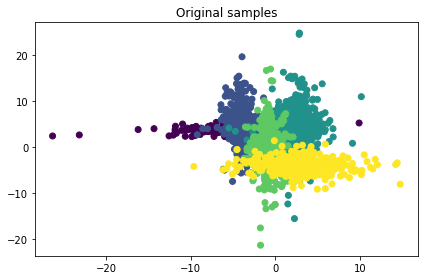

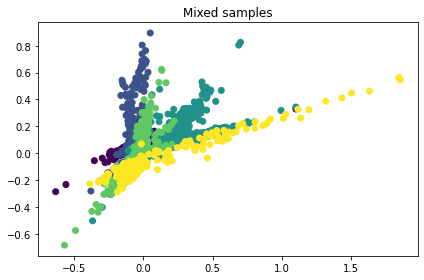

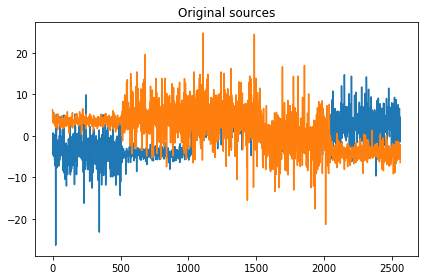

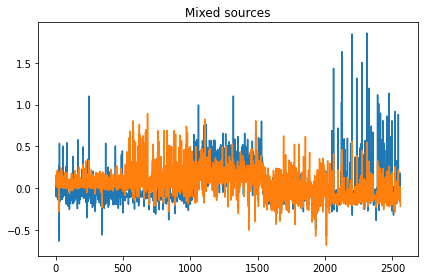

In [ ]:
data_size = 2
latent_size = 2
U_size = 5
k = 2
L = 512
mixL = 5
batch_size = 64

fig_label = "iVAE_toy_dataset_d={}_z={}_U={}_L={}_mixL={}".format(data_size, latent_size, U_size, L, mixL)
save_fig_flag = True

#Define dataset
data_sampler = iVAE_datasets(data_size, U_size, L, k, batch_size = batch_size, randomise = True, random_seed = False, mod_flag = False, mix_L = mixL, Gauss_source = False)

plt.figure()
plt.title("Original samples")
plt.scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)

if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/orig_samples_scatter.png")
plt.show()

plt.figure()
plt.title("Mixed samples")
plt.scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)

if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/mixed_samples_mixL={}_scatter.png".format(mixL))
plt.show()

plt.figure()
plt.title("Original sources")
plt.plot(data_sampler.data.cpu().numpy()[:, 0])
plt.plot(data_sampler.data.cpu().numpy()[:, 1])
if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/orig_samples.png")
plt.show()

plt.figure()
plt.title("Mixed sources")
plt.plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
plt.plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/mixed_samples_mixL={}.png".format(mixL))
plt.show()


# Version 1 - Using a OOP-based training approach (does not allow you to utilise the MCC per epoch).

In [ ]:
"""
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

model = VAE_model(data_size, latent_size, U_size, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False)
VAE_cost = VAE_loss("L2", gamma = 100, beta = 1, std_normal = False)

VAE_opt = VAE_optimiser(model, None)
my_trainer = VAE_trainer(model, VAE_opt, VAE_cost, data_sampler, data_sampler, epochs)

my_trainer.train_model()
my_trainer.plotter()
"""

'\nepochs = 100\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nencode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],\n                "conv_flag":False }\n\ndecode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],\n                "conv_flag":False }\n\nprior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],\n                "conv_flag":False }\n\nmodel = VAE_model(data_size, latent_size, U_size, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False)\nVAE_cost = VAE_loss("L2", gamma = 100, beta = 1, std_normal = False)\n\nVAE_opt = VAE_optimiser(model, None)\nmy_trainer = VAE_trainer(model, VAE_opt, VAE_cost, data_sampler, data_sampler, epochs)\n\nmy_trainer.train_model()\nmy_trainer.plotter()\n'

In [ ]:
"""
with torch.no_grad():

    #Prior outputs
    labels = torch.arange(0, U_size)
    mu, var = model.prior(labels.to(device))

    mu = mu.cpu().numpy()
    var = var.cpu().numpy()

    if model.U_size == 0: #Check to see if you perhaps trained a normal VAE!
        mu = np.repeat(mu, data_sampler.no_classes, axis = 0)
        var = np.repeat(var, data_sampler.no_classes, axis = 0)
    
    mu_new = mu[data_sampler.sample_labels.numpy(), :]
    var_new = var[data_sampler.sample_labels.numpy(), :]

    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 3, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")


    #Prior space p(z|u)
    ax[1].set_title("Prior space")
    ax[1].scatter(Z_new[:, 0], Z_new[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")

    #Encoder outputs
    z, var = model.encoder(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))

    z_scatter = z + torch.randn_like(z) * torch.sqrt(var)
    x_recon, var_recon = model.decoder(z, torch.zeros_like(var))

    error = torch.sum((x_recon - data_sampler.mixed_data.to(device))**2 / var_recon, dim = 1).numpy() / data_size

    x_recon = x_recon.cpu().numpy()
    z = z.cpu().numpy()

    #Latent space p(z|x, u)
    ax[2].set_title("Latent space")
    ax[2].scatter(z_scatter[:, 0], z_scatter[:, 1], c = data_sampler.sample_labels)
    ax[2].set_xlabel(r"$z_1$")
    ax[2].set_ylabel(r"$z_2$")
    plt.show()

    plt.figure()
    plt.scatter(np.arange(len(error)), error)
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(x_recon[:, 0], x_recon[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(x_recon[:, 0])
    ax[1].plot(x_recon[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources")
    ax[1].plot(z[:, 0])
    ax[1].plot(z[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()
    plt.show()

    
    #fig, ax = plt.subplots(5, 4, figsize = (10, 8))
    #ax  = ax.flatten()
    #fig.suptitle("Latent samples")
    #for cnt, i in enumerate(range(0, 512 * U_size, 512)):
    #    ax[4 * cnt].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 0])
    #    ax[4 * cnt + 1].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 1])
    #    ax[4 * cnt + 2].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 0])
    #    ax[4 * cnt + 3].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 1])
    #plt.tight_layout()
    #plt.show()
    


#########################################################
#CORRELATION
#########################################################
MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = True, save_fig = False)
"""

'\nwith torch.no_grad():\n\n    #Prior outputs\n    labels = torch.arange(0, U_size)\n    mu, var = model.prior(labels.to(device))\n\n    mu = mu.cpu().numpy()\n    var = var.cpu().numpy()\n\n    if model.U_size == 0: #Check to see if you perhaps trained a normal VAE!\n        mu = np.repeat(mu, data_sampler.no_classes, axis = 0)\n        var = np.repeat(var, data_sampler.no_classes, axis = 0)\n    \n    mu_new = mu[data_sampler.sample_labels.numpy(), :]\n    var_new = var[data_sampler.sample_labels.numpy(), :]\n\n    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)\n\n    #Latent space and prior spaces\n    fig, ax = plt.subplots(1, 3, figsize = (12, 8))\n    ax = ax.flatten()\n\n    #Original sources\n    ax[0].set_title("Original samples")\n    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)\n    ax[0].set_xlabel(r"$s_1$")\n    ax[0].set_ylabel(r"$s_2$")\n\n\n

# Version 2 - Using a loop-based training approach (no OOP but it does allow you to utilise the MCC per epoch).


cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Encoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (var_activation): Softplus(beta=1, threshold=20)
  (encode_net): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (mu_layer): Linear(in_features=128, out_features=2, bias=True)
  (var_layer): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)
Decoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (decode_net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (gen_layer): Linear(in_features=128, out_features=2


cost[MSE, KL]/MCC at epoch 0: [0.0252, 0.0277]/43.51%:   0%|          | 0/100 [00:00<?, ?it/s]
cost[MSE, KL]/MCC at epoch 0: [0.0252, 0.0277]/43.51%:   1%|          | 1/100 [00:00<00:22,  4.33it/s]
cost[MSE, KL]/MCC at epoch 1: [0.0239, 0.0858]/26.78%:   1%|          | 1/100 [00:00<00:22,  4.33it/s]
cost[MSE, KL]/MCC at epoch 1: [0.0239, 0.0858]/26.78%:   2%|▏         | 2/100 [00:00<00:23,  4.15it/s]
cost[MSE, KL]/MCC at epoch 2: [0.0218, 0.0401]/58.91%:   2%|▏         | 2/100 [00:00<00:23,  4.15it/s]
cost[MSE, KL]/MCC at epoch 2: [0.0218, 0.0401]/58.91%:   3%|▎         | 3/100 [00:00<00:23,  4.22it/s]
cost[MSE, KL]/MCC at epoch 3: [0.0205, 0.0399]/34.03%:   3%|▎         | 3/100 [00:00<00:23,  4.22it/s]
cost[MSE, KL]/MCC at epoch 3: [0.0205, 0.0399]/34.03%:   4%|▍         | 4/100 [00:00<00:23,  4.16it/s]
cost[MSE, KL]/MCC at epoch 4: [0.0121, 0.2165]/17.57%:   4%|▍         | 4/100 [00:01<00:23,  4.16it/s]
cost[MSE, KL]/MCC at epoch 4: [0.0121, 0.2165]/17.57%:   5%|▌         | 5/100 [0

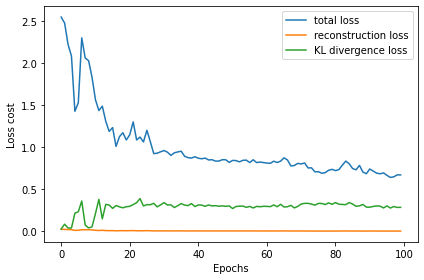

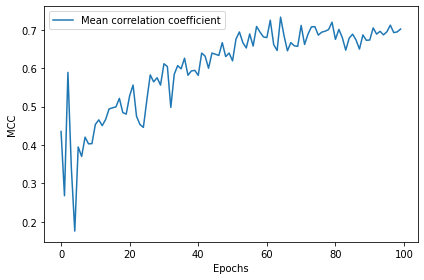

In [ ]:
#Setup model for optimisation

encode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],
                "conv_flag":False }

encoder_model = Encoder(latent_size, U_size, data_size, encode_dict)
decoder_model = Decoder(latent_size, U_size, data_size, decode_dict, var_flag = False)
prior_model = ConditionalPrior(latent_size, U_size, data_size, prior_dict, continuous_prior = False)

print(encoder_model)
print(decoder_model)
print(prior_model)

print(dir(prior_model))

####################
#PARAMETERS
####################
epochs = 100

Lr_init = 1e-3
Lr_end = 1e-3

Loss_type = "L2"
noise_var_decoder = 1/100
Beta_VAE = 1

gamma_scheduler = 10**(np.log10(Lr_end / Lr_init) / epochs)
##################################

#Push models to device
encoder_model.to(encoder_model.device)
decoder_model.to(decoder_model.device)
prior_model.to(prior_model.device)

data_iterator = iter(data_sampler)

loss = VAE_loss(loss_name = Loss_type, gamma = 1/noise_var_decoder, beta = Beta_VAE, std_normal = False)

ls = list(encoder_model.parameters()) + list(decoder_model.parameters()) + list(prior_model.parameters())
optim = torch.optim.Adam(ls, lr= Lr_init)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optim, gamma = gamma_scheduler, verbose = False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################
#TRAIN
######################
total_cost_list = []
recon_cost_list = []
kl_cost_list = []
MCC = []

pbar = tqdm(total = epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

for i in range(epochs):
    total_cost = 0
    recon_cost = 0
    kl_cost = 0
    N = 0
    for data in data_iterator:
      Xdata, labels = data
      
      mu_z_encoder, var_z_encoder = encoder_model(Xdata.to(device), labels.to(device))
      
      mu_z_prior, var_z_prior = prior_model(labels.to(device)) #labels).to(device)) #

      Xrecon = decoder_model(mu_z_encoder, var_z_encoder)

      loss_val, recon_loss, kl_loss = loss(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior)

      loss_val.backward()
      optim.step()
      optim.zero_grad()

      total_cost += loss_val.item()
      recon_cost += recon_loss.item()
      kl_cost += kl_loss.item()
      N += 1

    #Update scheduler
    scheduler.step()

    total_cost_list.append(total_cost / N)
    recon_cost_list.append(recon_cost / N)
    kl_cost_list.append(kl_cost / N)
    ###############
    #MCC for inputs, sub-optimal implementation, should rather loop through the elements in batches
    ###############
    with torch.no_grad():

      z, var = encoder_model(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))

      MCC_iter, _ = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = False)
      MCC.append(MCC_iter)

    pbar.set_description("cost[MSE, KL]/MCC at epoch {}: [{:.4f}, {:.4f}]/{:.2f}%".format(i, recon_cost_list[-1], kl_cost_list[-1], MCC_iter*100))
    pbar.update(1)

pbar.close()

plt.figure()
plt.plot(total_cost_list, label = "total loss")
plt.plot(recon_cost_list, label = "reconstruction loss")
plt.plot(kl_cost_list, label = "KL divergence loss")
plt.ylabel("Loss cost")
plt.xlabel("Epochs")
plt.legend()
if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/VAE_loss_" + fig_label + ".png")
plt.show()

plt.figure()
plt.plot(MCC, label = "Mean correlation coefficient")
plt.ylabel("MCC")
plt.xlabel("Epochs")
plt.legend()
if save_fig_flag:
    plt.tight_layout()
    plt.savefig("./tmp_figures/MCC_" + fig_label + ".png")
plt.show()

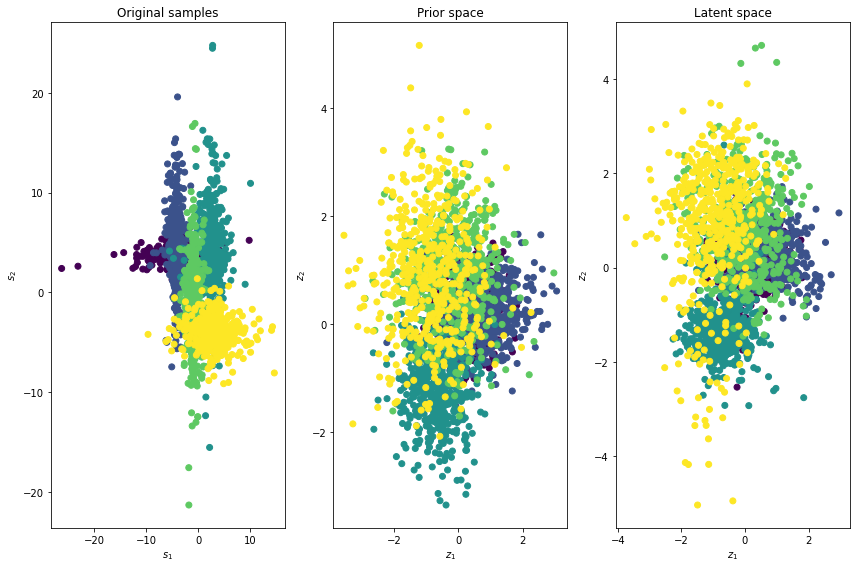

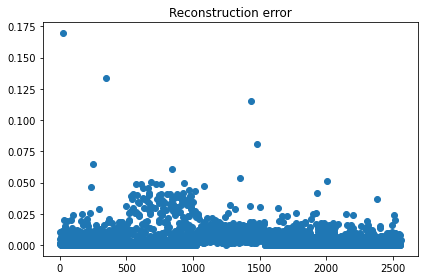

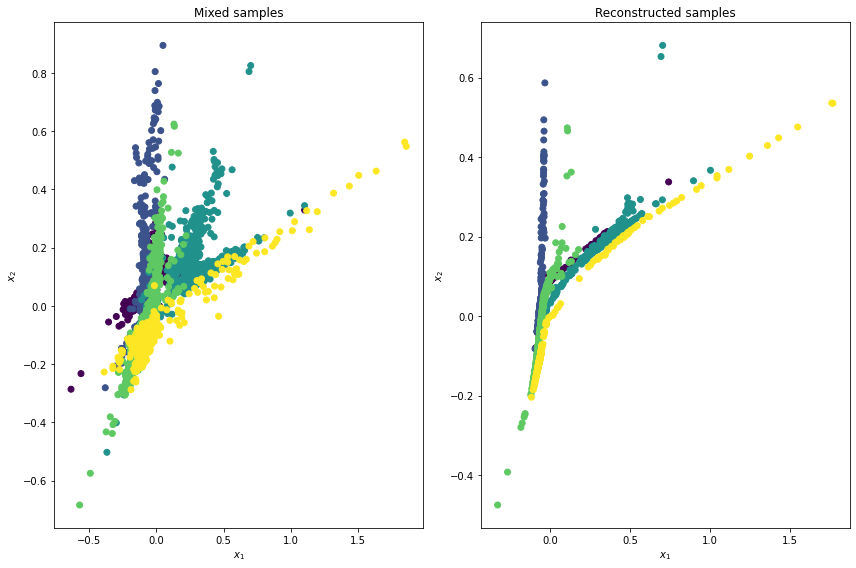

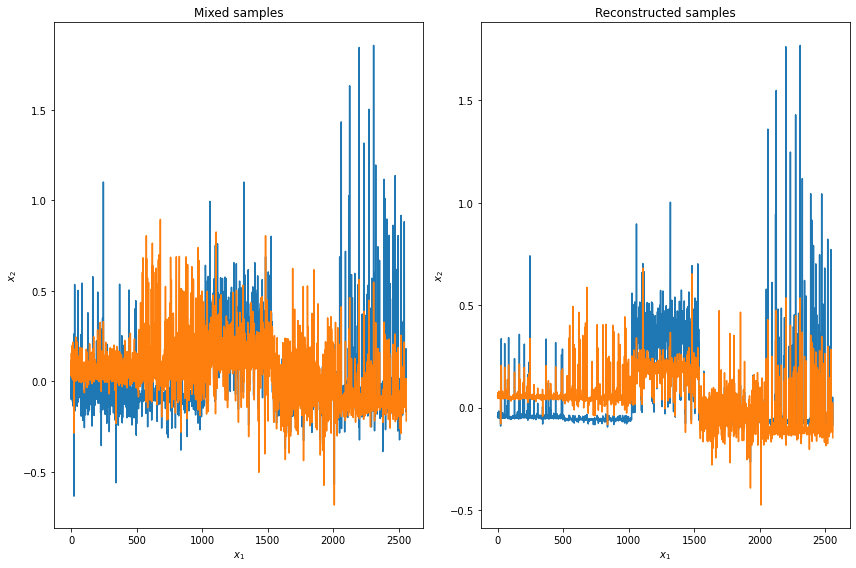

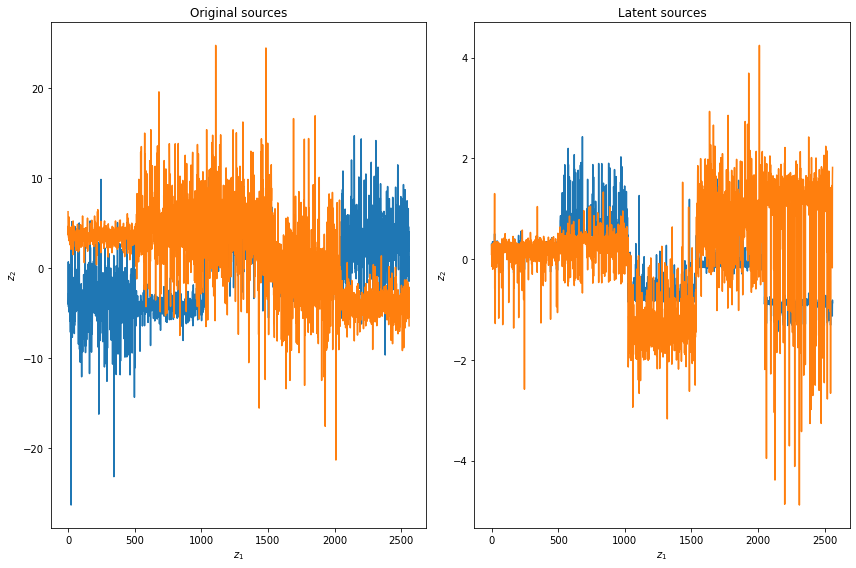

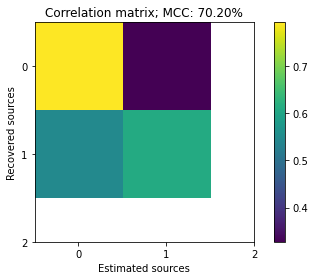

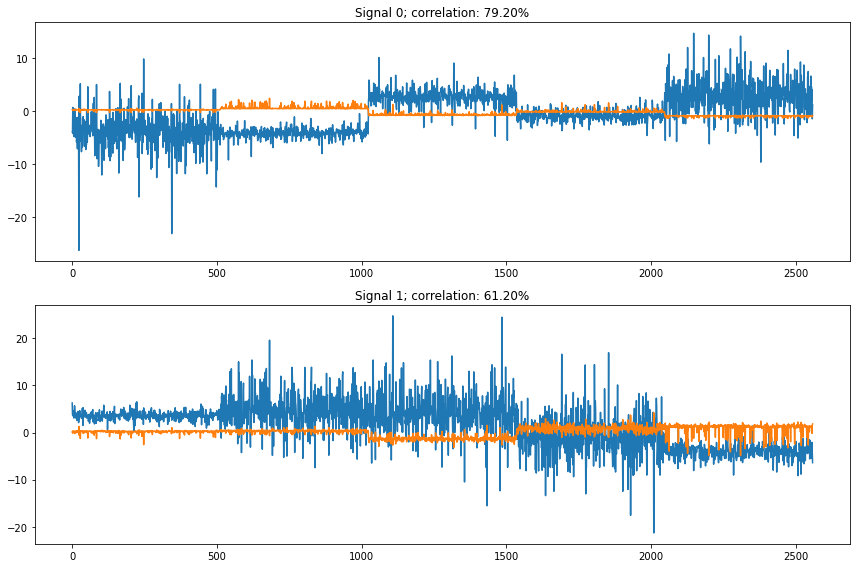

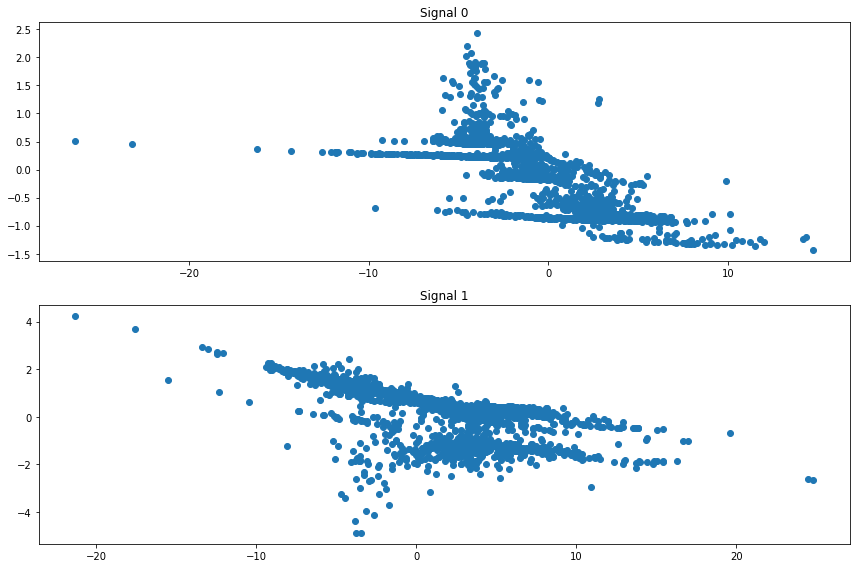

In [ ]:
with torch.no_grad():

    labels = torch.arange(0, U_size)
    U = torch.eye(U_size)
    mu, var = prior_model(labels.to(device))#

    mu = mu.cpu().numpy()
    var = var.cpu().numpy()

    mu_new = mu[data_sampler.sample_labels.numpy(), :]
    var_new = var[data_sampler.sample_labels.numpy(), :]

    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 3, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")


    #Prior space p(z|u)
    ax[1].set_title("Prior space")
    ax[1].scatter(Z_new[:, 0], Z_new[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")

    z, var = encoder_model(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))

    z_scatter = z + torch.randn_like(z) * torch.sqrt(var)
    recon, _ = decoder_model(z, torch.zeros_like(var))

    error = torch.sum((recon - data_sampler.mixed_data.to(device))**2, dim = 1).numpy() / data_size

    recon = recon.cpu().numpy()
    z = z.cpu().numpy()

    #Latent space p(z|x, u)
    ax[2].set_title("Latent space")
    ax[2].scatter(z_scatter[:, 0], z_scatter[:, 1], c = data_sampler.sample_labels)
    ax[2].set_xlabel(r"$z_1$")
    ax[2].set_ylabel(r"$z_2$")

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/latent_space_" + fig_label + ".png")
    plt.show()

    plt.figure()
    plt.title("Reconstruction error")
    plt.scatter(np.arange(len(error)), error)
    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/Error_" + fig_label + ".png")
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(recon[:, 0], recon[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_scatter_" + fig_label + ".png")
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(recon[:, 0])
    ax[1].plot(recon[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_signals_" + fig_label + ".png")
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources")
    ax[1].plot(z[:, 0])
    ax[1].plot(z[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/source_signals_" + fig_label + ".png")
    plt.show()

    """
    fig, ax = plt.subplots(5, 4, figsize = (10, 8))
    ax  = ax.flatten()
    fig.suptitle("Latent samples")
    for cnt, i in enumerate(range(0, 512 * U_size, 512)):
        ax[4 * cnt].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 0])
        ax[4 * cnt + 1].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 1])
        ax[4 * cnt + 2].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 0])
        ax[4 * cnt + 3].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 1])
    plt.tight_layout()
    plt.show()
    """


#########################################################
#CORRELATION
#########################################################
MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = True, save_fig = save_fig_flag, save_label = fig_label)


# ICA Analysis

In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components = data_size, whiten = True, algorithm = 'parallel', fun = 'logcosh')

S = ica.fit_transform(data_sampler.mixed_data.numpy())
recon_ICA = ica.inverse_transform(S)

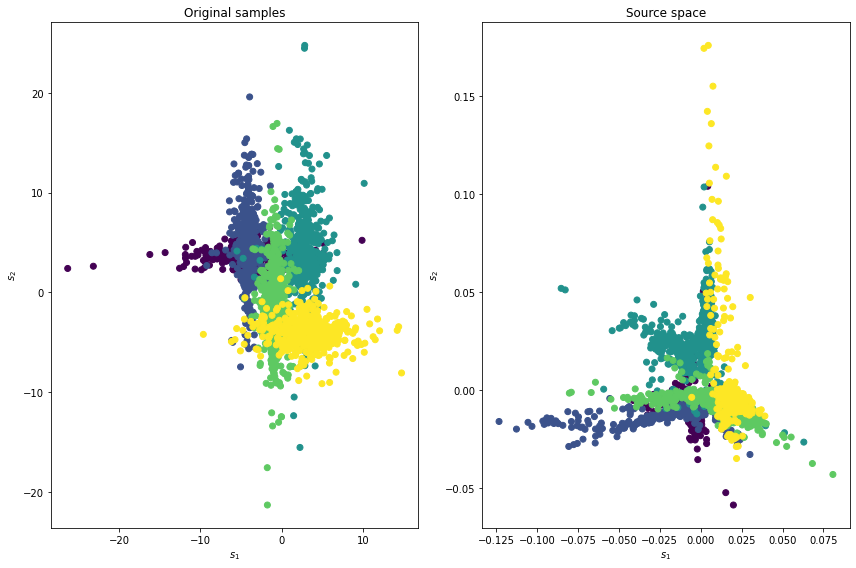

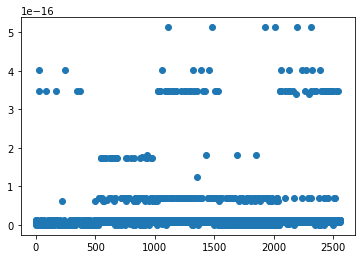

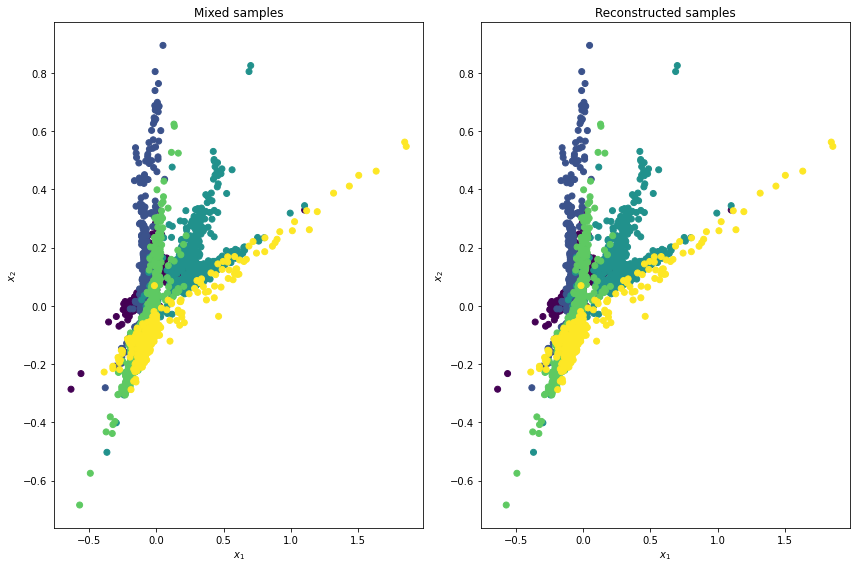

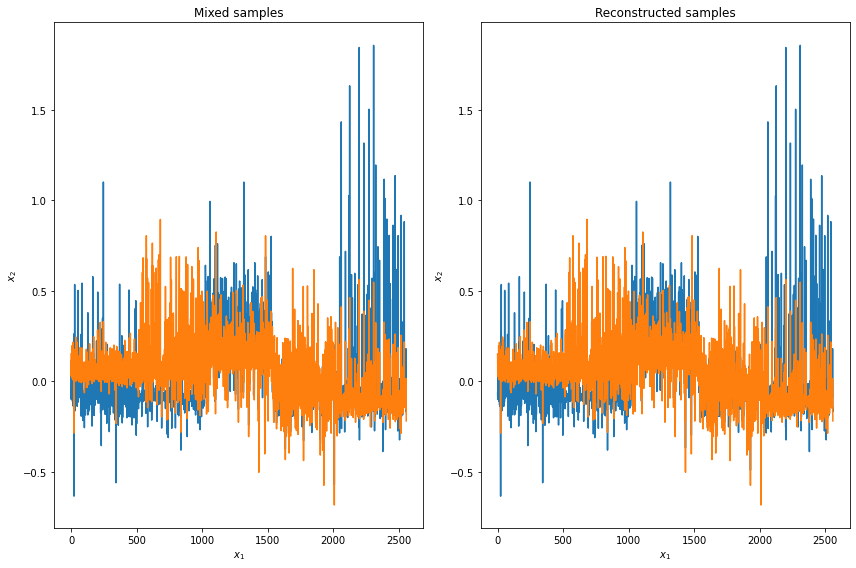

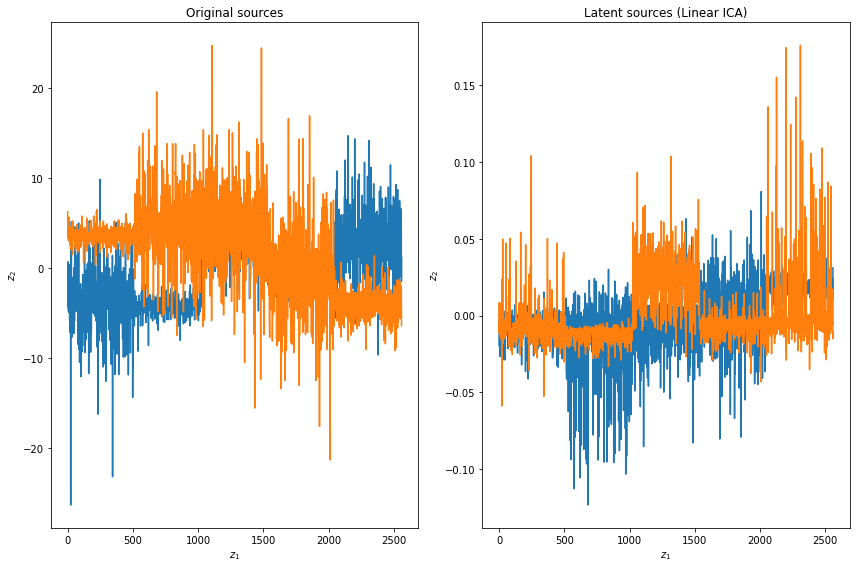

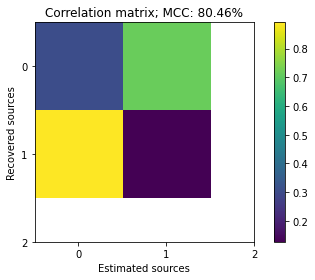

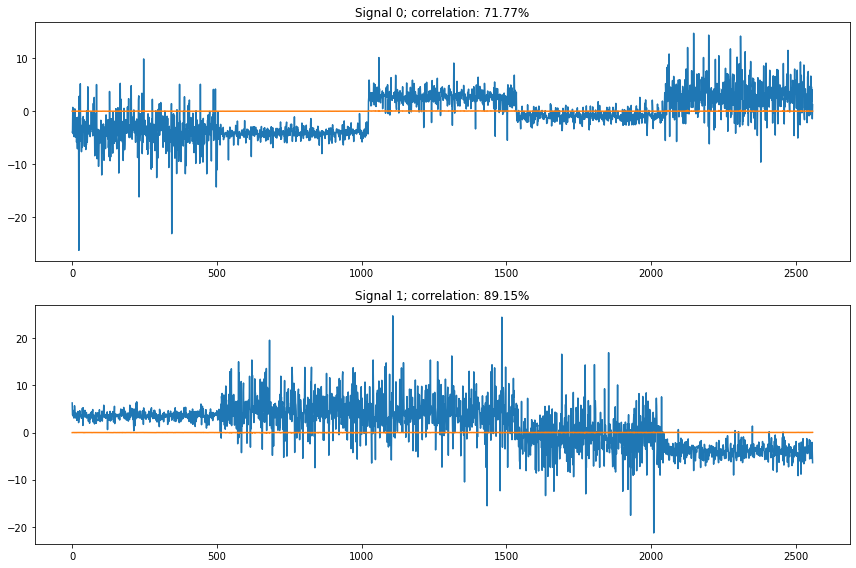

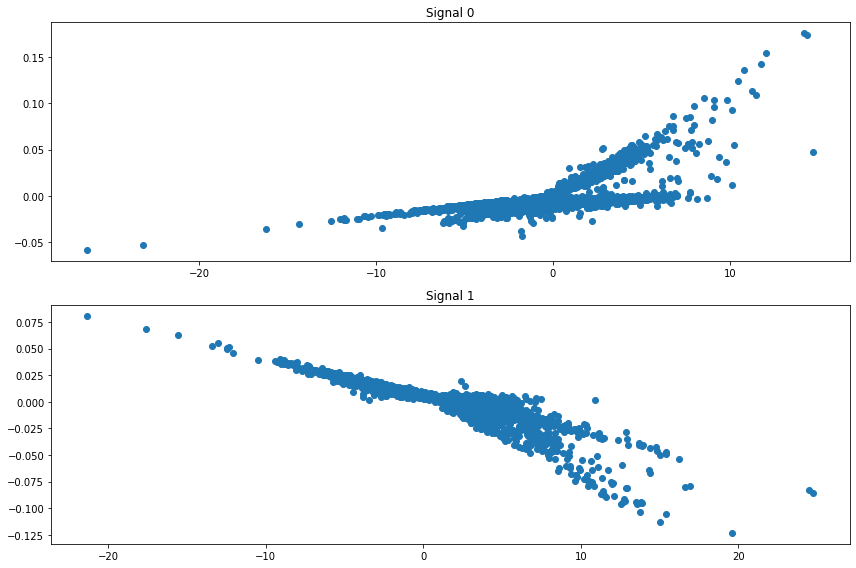

In [ ]:
with torch.no_grad():

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")


    #Latent space p(z|x, u)
    ax[1].set_title("Source space")
    ax[1].scatter(S[:, 0], S[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$s_1$")
    ax[1].set_ylabel(r"$s_2$")

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/ICA_latent_space_" + fig_label + ".png")
    plt.show()

    error = np.sum((recon_ICA - data_sampler.mixed_data.numpy())**2, axis = 1) / data_size

    plt.figure()
    plt.scatter(np.arange(len(error)), error)
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(recon_ICA[:, 0], recon_ICA[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_scatter_" + "LinearICA_mixL={}".format(mixL) + ".png")
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(recon_ICA[:, 0])
    ax[1].plot(recon_ICA[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()
    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_signals_" + "LinearICA_mixL={}".format(mixL) + ".png")
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources (Linear ICA)")
    ax[1].plot(S[:, 0])
    ax[1].plot(S[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()
    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/source_signals_" + "LinearICA_mixL={}".format(mixL) + ".png")
    plt.show()

    """
    fig, ax = plt.subplots(5, 4, figsize = (10, 8))
    ax  = ax.flatten()
    fig.suptitle("Latent samples")
    for cnt, i in enumerate(range(0, 512 * U_size, 512)):
        ax[4 * cnt].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 0])
        ax[4 * cnt + 1].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 0], z[i:i + 512, 1])
        ax[4 * cnt + 2].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 0])
        ax[4 * cnt + 3].scatter(data_sampler.data.cpu().numpy()[i:i + 512, 1], z[i:i + 512, 1])
    plt.tight_layout()
    plt.show()
    """


#########################################################
#CORRELATION
#########################################################
MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), S, PLOT = True, save_fig = save_fig_flag, save_label = "LinearICA_mixL={}".format(mixL))


In [ ]:
!zip -r /content/figures.zip /content/tmp_figures

updating: content/tmp_figures/ (stored 0%)
updating: content/tmp_figures/VAE_loss_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 5%)
updating: content/tmp_figures/reconstruction_scatter_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 2%)
updating: content/tmp_figures/Error_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 6%)
updating: content/tmp_figures/source_signals_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 2%)
updating: content/tmp_figures/correlated_signals_scatter_LinearICA_mixL=1.png (deflated 8%)
updating: content/tmp_figures/correlation_matrix_LinearICA_mixL=1.png (deflated 10%)
updating: content/tmp_figures/correlated_signals_LinearICA_mixL=1.png (deflated 3%)
updating: content/tmp_figures/correlated_signals_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 2%)
updating: content/tmp_figures/MCC_iVAE_toy_dataset_d=2_z=2_U=5_L=512_mixL=1.png (deflated 4%)
updating: content/tmp_figures/orig_samples.png (deflated 3%)
updating: content/t

In [ ]:
from google.colab import files
files.download("/content/figures.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running the model N times for each L mixing layers - examine average MCC for plotting

In [ ]:

Nl = 6
Nr = 100

MCC_mat = np.zeros((Nl, Nr))

for cnt, mixL in enumerate(range(1, Nl, 1)):

    data_size = 2
    latent_size = 2
    U_size = 5
    k = 2
    L = 512
    #mixL = 6
    batch_size = 64

    for reps in range(Nr):

        print("\nBeginning repetition {} for {} mixing layers...\n".format(reps, mixL))
        #fig_label = "iVAE_toy_dataset_d={}_z={}_U={}_L={}_mixL={}".format(data_size, latent_size, U_size, L, mixL)
        save_fig_flag = False

        #Define dataset
        data_sampler = iVAE_datasets(data_size, U_size, L, k, batch_size = batch_size, randomise = True, random_seed = False, mod_flag = False, mix_L = mixL, Gauss_source = False, seed = True)

        epochs = 100
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        encode_dict = { "ff_layers":[data_size + U_size, 128, 128, 128, latent_size],
                        "conv_flag":False }

        decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                        "conv_flag":False }

        prior_dict = {  "ff_layers":[U_size, 128, 128, 128, latent_size],
                        "conv_flag":False }

        model = VAE_model(data_size, latent_size, U_size, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False)
        VAE_cost = VAE_loss("L2", gamma = 100, beta = 1, std_normal = False)

        VAE_opt = VAE_optimiser(model, None)
        my_trainer = VAE_trainer(model, VAE_opt, VAE_cost, data_sampler, data_sampler, epochs)

        my_trainer.train_model()
        #my_trainer.plotter()

        #Determine sources from model
        with torch.no_grad():
            z, var = model.encoder(data_sampler.mixed_data.to(device), data_sampler.sample_labels.to(device))
            z = z.cpu().numpy()

        #Estimate MCC
        MCC, corr_vals = MCC_estimation(data_sampler.data.cpu().numpy(), z, PLOT = False, save_fig = False)

        MCC_mat[cnt, reps] = MCC

        print("\nIteration MCC: {:.2f}".format(MCC * 100))



Beginning repetition 0 for 1 mixing layers...



train cost: [400.48948, 3.85818, 14.6719], valid cost: [317.22339, 3.0651, 10.7131]:   1%|          | 1/100 [00:00<00:17,  5.71it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.59949, 0.04018, 3.58116], valid cost: [15.49715, 0.11791, 3.70643]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 78.71

Beginning repetition 1 for 1 mixing layers...



train cost: [514.29191, 5.07287, 7.00511], valid cost: [475.36913, 4.61046, 14.3228]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.4116, 0.07908, 3.50404], valid cost: [42.92751, 0.39381, 3.54606]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 97.31

Beginning repetition 2 for 1 mixing layers...



train cost: [429.80357, 4.20052, 9.75185], valid cost: [543.62043, 5.34624, 8.99661]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [19.02828, 0.15405, 3.62335], valid cost: [22.19588, 0.18409, 3.7868]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 78.34

Beginning repetition 3 for 1 mixing layers...



train cost: [390.14322, 3.79358, 10.78538], valid cost: [915.74058, 8.97069, 18.67154]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.09491, 0.04614, 3.48111], valid cost: [10.0506, 0.06489, 3.56146]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 91.44

Beginning repetition 4 for 1 mixing layers...



train cost: [259.04724, 2.46203, 12.84383], valid cost: [518.15833, 5.07068, 11.09018]:   1%|          | 1/100 [00:00<00:19,  5.19it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.49524, 0.0286, 3.63566], valid cost: [9.58714, 0.05974, 3.61265]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 92.39

Beginning repetition 5 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.73833, 0.05235, 3.50349], valid cost: [14.10134, 0.10714, 3.38693]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 95.19

Beginning repetition 6 for 1 mixing layers...



train cost: [281.14575, 2.66643, 14.50292], valid cost: [324.39765, 3.11964, 12.43338]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.99259, 0.043, 3.69248], valid cost: [9.59099, 0.05868, 3.72285]: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]



Iteration MCC: 77.85

Beginning repetition 7 for 1 mixing layers...



train cost: [336.01513, 3.24309, 11.70602], valid cost: [533.50335, 5.22643, 10.85986]:   1%|          | 1/100 [00:00<00:18,  5.32it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.71915, 0.04188, 3.53095], valid cost: [19.36447, 0.15836, 3.52881]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 89.97

Beginning repetition 8 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.55108, 0.0405, 3.50113], valid cost: [13.65024, 0.10144, 3.50646]: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]



Iteration MCC: 82.35

Beginning repetition 9 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.50548, 0.06978, 3.52718], valid cost: [18.67045, 0.15117, 3.55345]: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]



Iteration MCC: 98.61

Beginning repetition 10 for 1 mixing layers...



train cost: [365.79796, 3.55888, 9.90987], valid cost: [373.46715, 3.64423, 9.0444]:   1%|          | 1/100 [00:00<00:17,  5.71it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.1742, 0.11663, 3.51122], valid cost: [31.1078, 0.27496, 3.61223]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 94.73

Beginning repetition 11 for 1 mixing layers...



train cost: [303.6319, 2.86345, 17.28668], valid cost: [396.92759, 3.83269, 13.65881]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.16764, 0.0757, 3.5974], valid cost: [31.31936, 0.27698, 3.62144]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Iteration MCC: 78.09

Beginning repetition 12 for 1 mixing layers...



train cost: [364.71293, 3.49465, 15.24762], valid cost: [290.1064, 2.76172, 13.93435]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.1042, 0.09446, 3.65782], valid cost: [26.82602, 0.23111, 3.71544]: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]



Iteration MCC: 87.65

Beginning repetition 13 for 1 mixing layers...



train cost: [278.38016, 2.64606, 13.77447], valid cost: [424.39628, 4.12912, 11.48471]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.3465, 0.0488, 3.4662], valid cost: [21.96408, 0.18496, 3.46802]: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]



Iteration MCC: 98.05

Beginning repetition 14 for 1 mixing layers...



train cost: [269.30765, 2.53986, 15.32115], valid cost: [239.46068, 2.25141, 14.31959]:   1%|          | 1/100 [00:00<00:17,  5.74it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.25624, 0.06825, 3.43167], valid cost: [26.58977, 0.2272, 3.86973]: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]



Iteration MCC: 95.93

Beginning repetition 15 for 1 mixing layers...



train cost: [399.46409, 3.88688, 10.77583], valid cost: [661.80518, 6.57614, 4.19108]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.86987, 0.09941, 3.92842], valid cost: [33.21608, 0.29653, 3.56266]: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]



Iteration MCC: 93.91

Beginning repetition 16 for 1 mixing layers...



train cost: [530.21951, 5.23742, 6.47716], valid cost: [1247.57838, 12.27391, 20.18735]:   1%|          | 1/100 [00:00<00:17,  5.65it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [16.66211, 0.13218, 3.44413], valid cost: [37.57777, 0.34023, 3.55449]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 96.75

Beginning repetition 17 for 1 mixing layers...



train cost: [442.9607, 4.35833, 7.12725], valid cost: [821.74595, 8.15756, 5.99031]:   1%|          | 1/100 [00:00<00:18,  5.37it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [30.73975, 0.27039, 3.70045], valid cost: [49.43429, 0.45844, 3.5907]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 93.48

Beginning repetition 18 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [25.70237, 0.22265, 3.43757], valid cost: [55.89426, 0.52476, 3.41855]: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]



Iteration MCC: 90.91

Beginning repetition 19 for 1 mixing layers...



train cost: [396.1907, 3.84241, 11.94996], valid cost: [510.60364, 5.01469, 9.13435]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [12.30062, 0.08935, 3.36531], valid cost: [37.49403, 0.339, 3.59415]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 95.50

Beginning repetition 20 for 1 mixing layers...



train cost: [467.31227, 4.5807, 9.24203], valid cost: [801.29955, 7.89028, 12.27157]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.13748, 0.11715, 3.42294], valid cost: [40.83071, 0.37246, 3.58497]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]



Iteration MCC: 92.32

Beginning repetition 21 for 1 mixing layers...



train cost: [412.75604, 3.99838, 12.91816], valid cost: [441.08969, 4.27274, 13.81577]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [20.09249, 0.16544, 3.54879], valid cost: [30.06268, 0.2641, 3.65313]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]



Iteration MCC: 70.67

Beginning repetition 22 for 1 mixing layers...



train cost: [276.6985, 2.56827, 19.87132], valid cost: [141.5489, 1.24964, 16.5854]:   1%|          | 1/100 [00:00<00:19,  5.12it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.94795, 0.08217, 3.7309], valid cost: [25.1657, 0.21385, 3.78056]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 81.52

Beginning repetition 23 for 1 mixing layers...



train cost: [396.64559, 3.85642, 11.00369], valid cost: [666.80626, 6.55933, 10.8732]:   1%|          | 1/100 [00:00<00:17,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.56312, 0.08014, 3.54868], valid cost: [19.45961, 0.1582, 3.63948]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 71.87

Beginning repetition 24 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.1155, 0.10727, 3.3886], valid cost: [22.16054, 0.18571, 3.58915]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 98.48

Beginning repetition 25 for 1 mixing layers...



train cost: [306.65682, 2.96249, 10.40804], valid cost: [285.36237, 2.74006, 11.35679]:   1%|          | 1/100 [00:00<00:19,  5.10it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.68271, 0.02101, 3.58211], valid cost: [8.03434, 0.04391, 3.64286]: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]



Iteration MCC: 75.40

Beginning repetition 26 for 1 mixing layers...



train cost: [389.87122, 3.79648, 10.22284], valid cost: [551.53015, 5.42023, 9.5074]:   1%|          | 1/100 [00:00<00:18,  5.29it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [18.00512, 0.14353, 3.65236], valid cost: [22.36054, 0.18816, 3.54452]: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]



Iteration MCC: 83.08

Beginning repetition 27 for 1 mixing layers...



train cost: [494.74681, 4.8192, 12.82717], valid cost: [452.62159, 4.45197, 7.42503]:   1%|          | 1/100 [00:00<00:17,  5.80it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.07223, 0.05547, 3.52566], valid cost: [14.24858, 0.10801, 3.44746]: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]



Iteration MCC: 90.88

Beginning repetition 28 for 1 mixing layers...



train cost: [318.52228, 3.05832, 12.69066], valid cost: [224.0706, 2.12807, 11.26341]:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.75902, 0.07316, 3.44341], valid cost: [14.41184, 0.11011, 3.40076]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 98.04

Beginning repetition 29 for 1 mixing layers...



train cost: [474.83946, 4.654, 9.43996], valid cost: [508.98634, 5.02481, 6.50502]:   1%|          | 1/100 [00:00<00:19,  5.14it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.424, 0.05041, 3.38315], valid cost: [12.48027, 0.09028, 3.45177]: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]



Iteration MCC: 97.68

Beginning repetition 30 for 1 mixing layers...



train cost: [346.0152, 3.33638, 12.37705], valid cost: [379.12889, 3.69138, 9.9909]:   1%|          | 1/100 [00:00<00:17,  5.80it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.28688, 0.06875, 3.41227], valid cost: [39.00296, 0.354, 3.6033]: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]



Iteration MCC: 97.72

Beginning repetition 31 for 1 mixing layers...



train cost: [489.37753, 4.81486, 7.89175], valid cost: [677.88981, 6.70827, 7.06238]:   1%|          | 1/100 [00:00<00:16,  5.96it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.19353, 0.05591, 3.60227], valid cost: [20.05171, 0.16386, 3.66555]: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]



Iteration MCC: 75.37

Beginning repetition 32 for 1 mixing layers...



train cost: [321.98049, 3.08747, 13.23301], valid cost: [487.39939, 4.73593, 13.80623]:   1%|          | 1/100 [00:00<00:16,  5.94it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.71922, 0.11165, 3.55418], valid cost: [26.48488, 0.23136, 3.34853]: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]



Iteration MCC: 96.04

Beginning repetition 33 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.5991, 0.02135, 3.46403], valid cost: [7.16548, 0.03745, 3.42052]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 97.24

Beginning repetition 34 for 1 mixing layers...



train cost: [271.19375, 2.52825, 18.36868], valid cost: [199.30156, 1.84806, 14.49544]:   1%|          | 1/100 [00:00<00:19,  5.07it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [17.87362, 0.14481, 3.39286], valid cost: [19.98334, 0.16494, 3.48898]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 93.59

Beginning repetition 35 for 1 mixing layers...



train cost: [434.22997, 4.262, 8.02974], valid cost: [544.79534, 5.38258, 6.5378]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.38942, 0.1189, 3.49946], valid cost: [34.81447, 0.31237, 3.5776]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Iteration MCC: 97.36

Beginning repetition 36 for 1 mixing layers...



train cost: [283.0704, 2.71369, 11.70162], valid cost: [403.25331, 3.94307, 8.94635]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [18.05161, 0.14402, 3.64939], valid cost: [34.56485, 0.30962, 3.6033]: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]



Iteration MCC: 82.07

Beginning repetition 37 for 1 mixing layers...



train cost: [366.77725, 3.55474, 11.30338], valid cost: [544.75653, 5.35371, 9.3852]:   1%|          | 1/100 [00:00<00:16,  5.84it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.0212, 0.04656, 3.36552], valid cost: [13.40813, 0.09919, 3.48963]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 99.17

Beginning repetition 38 for 1 mixing layers...



train cost: [499.00523, 4.89026, 9.9792], valid cost: [663.36584, 6.5616, 7.20546]:   1%|          | 1/100 [00:00<00:18,  5.32it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [18.8695, 0.15361, 3.50868], valid cost: [31.43483, 0.28044, 3.39112]: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Iteration MCC: 95.89

Beginning repetition 39 for 1 mixing layers...



train cost: [389.57037, 3.75674, 13.89667], valid cost: [502.30153, 4.90299, 12.00222]:   1%|          | 1/100 [00:00<00:17,  5.71it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.50022, 0.0488, 3.61985], valid cost: [9.3017, 0.05689, 3.61232]: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]



Iteration MCC: 82.61

Beginning repetition 40 for 1 mixing layers...



train cost: [365.00899, 3.48772, 16.23656], valid cost: [233.84143, 2.21392, 12.44923]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.24464, 0.0365, 3.59426], valid cost: [11.53193, 0.0779, 3.74164]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 97.48

Beginning repetition 41 for 1 mixing layers...



train cost: [345.06826, 3.32248, 12.8206], valid cost: [521.85463, 5.07296, 14.55886]:   1%|          | 1/100 [00:00<00:17,  5.60it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.01186, 0.07401, 3.61051], valid cost: [9.90126, 0.06406, 3.49483]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 98.47

Beginning repetition 42 for 1 mixing layers...



train cost: [392.6617, 3.80511, 12.15055], valid cost: [605.30058, 5.93401, 11.89963]:   1%|          | 1/100 [00:00<00:18,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [25.27632, 0.21592, 3.684], valid cost: [47.36296, 0.43641, 3.72155]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 90.25

Beginning repetition 43 for 1 mixing layers...



train cost: [399.18838, 3.84583, 14.60558], valid cost: [283.02599, 2.64729, 18.29736]:   1%|          | 1/100 [00:00<00:19,  5.15it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [21.57572, 0.17887, 3.68896], valid cost: [41.57121, 0.38031, 3.54039]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 94.75

Beginning repetition 44 for 1 mixing layers...



train cost: [356.38319, 3.44022, 12.36108], valid cost: [298.6834, 2.85018, 13.66501]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [16.65306, 0.13076, 3.57734], valid cost: [58.77666, 0.55256, 3.52088]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 92.65

Beginning repetition 45 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.7953, 0.04254, 3.54086], valid cost: [14.2657, 0.10824, 3.44202]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 76.67

Beginning repetition 46 for 1 mixing layers...



train cost: [298.55829, 2.86024, 12.53475], valid cost: [295.38539, 2.83493, 11.89224]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.04624, 0.03544, 3.50248], valid cost: [15.42016, 0.11997, 3.423]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 96.01

Beginning repetition 47 for 1 mixing layers...



train cost: [435.94956, 4.26594, 9.35511], valid cost: [632.32505, 6.26462, 5.86278]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.93012, 0.11279, 3.65147], valid cost: [31.67484, 0.28182, 3.49312]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]



Iteration MCC: 71.18

Beginning repetition 48 for 1 mixing layers...



train cost: [390.04012, 3.73461, 16.57902], valid cost: [188.71383, 1.76743, 11.97076]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [16.43041, 0.12812, 3.61854], valid cost: [28.01773, 0.24332, 3.68531]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 76.53

Beginning repetition 49 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.4138, 0.04023, 3.391], valid cost: [9.57717, 0.06152, 3.42555]: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]



Iteration MCC: 97.49

Beginning repetition 50 for 1 mixing layers...



train cost: [387.13963, 3.75376, 11.76409], valid cost: [494.39875, 4.84557, 9.84131]:   1%|          | 1/100 [00:00<00:17,  5.76it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.53182, 0.05951, 3.58058], valid cost: [11.12115, 0.07622, 3.49889]: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]



Iteration MCC: 91.42

Beginning repetition 51 for 1 mixing layers...



train cost: [342.27275, 3.30314, 11.95836], valid cost: [511.58747, 4.98259, 13.32812]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.76851, 0.08193, 3.57562], valid cost: [26.82064, 0.23437, 3.384]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 91.69

Beginning repetition 52 for 1 mixing layers...



train cost: [403.52244, 3.92686, 10.83611], valid cost: [681.3013, 6.70205, 11.09601]:   1%|          | 1/100 [00:00<00:17,  5.74it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.60882, 0.11225, 3.38355], valid cost: [20.41024, 0.17034, 3.37601]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 97.57

Beginning repetition 53 for 1 mixing layers...



train cost: [285.62156, 2.72753, 12.86816], valid cost: [423.37431, 4.12004, 11.37006]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.7795, 0.10352, 3.42785], valid cost: [33.46041, 0.30167, 3.29376]: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]



Iteration MCC: 98.55

Beginning repetition 54 for 1 mixing layers...



train cost: [441.3283, 4.30641, 10.68702], valid cost: [443.13246, 4.3426, 8.87216]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.30975, 0.09561, 3.74867], valid cost: [42.35843, 0.3841, 3.94837]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]



Iteration MCC: 82.41

Beginning repetition 55 for 1 mixing layers...



train cost: [513.23554, 5.04144, 9.09201], valid cost: [542.15234, 5.35545, 6.6072]:   1%|          | 1/100 [00:00<00:16,  5.96it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.66772, 0.08194, 3.47414], valid cost: [20.94295, 0.17473, 3.47041]: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]



Iteration MCC: 96.45

Beginning repetition 56 for 1 mixing layers...



train cost: [299.71395, 2.85051, 14.66322], valid cost: [341.60983, 3.30516, 11.0937]:   1%|          | 1/100 [00:00<00:16,  5.97it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.62354, 0.10147, 3.47627], valid cost: [16.96025, 0.13314, 3.64632]: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]



Iteration MCC: 95.45

Beginning repetition 57 for 1 mixing layers...



train cost: [251.01141, 2.349, 16.111], valid cost: [198.5456, 1.84252, 14.29337]:   1%|          | 1/100 [00:00<00:17,  5.53it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.52539, 0.11983, 3.54251], valid cost: [25.3885, 0.21824, 3.56493]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 95.94

Beginning repetition 58 for 1 mixing layers...



train cost: [366.89965, 3.47591, 19.30876], valid cost: [299.33745, 2.83795, 15.54211]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [12.98963, 0.09443, 3.54691], valid cost: [31.1919, 0.27292, 3.90015]: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]



Iteration MCC: 94.38

Beginning repetition 59 for 1 mixing layers...



train cost: [440.09626, 4.30522, 9.57446], valid cost: [397.14864, 3.83018, 14.13102]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [12.14819, 0.08502, 3.64628], valid cost: [20.34444, 0.16676, 3.66798]: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]



Iteration MCC: 74.05

Beginning repetition 60 for 1 mixing layers...



train cost: [308.16846, 2.94229, 13.93903], valid cost: [538.03279, 5.23436, 14.59635]:   1%|          | 1/100 [00:00<00:16,  5.93it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.45232, 0.06661, 3.79134], valid cost: [12.68093, 0.08943, 3.73761]: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]



Iteration MCC: 81.47

Beginning repetition 61 for 1 mixing layers...



train cost: [292.67473, 2.77769, 14.90543], valid cost: [346.56463, 3.33107, 13.45735]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.59337, 0.1012, 3.47318], valid cost: [51.13363, 0.47493, 3.6408]: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]



Iteration MCC: 80.13

Beginning repetition 62 for 1 mixing layers...



train cost: [320.62096, 3.08263, 12.35775], valid cost: [554.09878, 5.43658, 10.4403]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.47534, 0.09695, 3.77991], valid cost: [67.18061, 0.62937, 4.24374]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]



Iteration MCC: 74.19

Beginning repetition 63 for 1 mixing layers...



train cost: [352.99931, 3.35888, 17.1111], valid cost: [383.97674, 3.67647, 16.32952]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.34008, 0.11724, 3.6156], valid cost: [43.18087, 0.39436, 3.74504]: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Iteration MCC: 74.61

Beginning repetition 64 for 1 mixing layers...



train cost: [401.38372, 3.88465, 12.91896], valid cost: [284.27944, 2.68277, 16.00255]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.54384, 0.10081, 3.46266], valid cost: [13.87547, 0.10312, 3.56318]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]



Iteration MCC: 95.03

Beginning repetition 65 for 1 mixing layers...



train cost: [269.89651, 2.53983, 15.91356], valid cost: [315.19177, 3.01075, 14.11675]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.80139, 0.04274, 3.52711], valid cost: [14.18392, 0.10534, 3.65022]: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Iteration MCC: 84.40

Beginning repetition 66 for 1 mixing layers...



train cost: [294.92278, 2.79166, 15.75675], valid cost: [175.96174, 1.63263, 12.69833]:   1%|          | 1/100 [00:00<00:17,  5.53it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [30.74999, 0.2701, 3.7401], valid cost: [57.53692, 0.53842, 3.69536]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Iteration MCC: 96.93

Beginning repetition 67 for 1 mixing layers...



train cost: [388.26787, 3.79932, 8.33598], valid cost: [705.35214, 6.99653, 5.69902]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.87555, 0.05303, 3.57214], valid cost: [16.91013, 0.13296, 3.61417]: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]



Iteration MCC: 82.42

Beginning repetition 68 for 1 mixing layers...



train cost: [421.71615, 4.15444, 6.27195], valid cost: [709.51175, 7.04238, 5.27347]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.27186, 0.03697, 3.57458], valid cost: [10.64533, 0.0705, 3.59521]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Iteration MCC: 96.27

Beginning repetition 69 for 1 mixing layers...



train cost: [510.11186, 5.02146, 7.96631], valid cost: [513.13377, 5.05316, 7.81741]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.05052, 0.10194, 3.85626], valid cost: [22.54375, 0.18642, 3.90223]: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Iteration MCC: 81.70

Beginning repetition 70 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.10239, 0.05632, 3.47071], valid cost: [12.42182, 0.08919, 3.50289]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 98.81

Beginning repetition 71 for 1 mixing layers...



train cost: [303.2057, 2.90774, 12.43165], valid cost: [348.84732, 3.34354, 14.49315]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [15.50749, 0.11966, 3.54159], valid cost: [27.94121, 0.24434, 3.50683]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]



Iteration MCC: 87.92

Beginning repetition 72 for 1 mixing layers...



train cost: [356.70091, 3.44264, 12.43692], valid cost: [558.65152, 5.47133, 11.5183]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.33592, 0.07725, 3.61113], valid cost: [18.22878, 0.14607, 3.62196]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 97.16

Beginning repetition 73 for 1 mixing layers...



train cost: [277.98863, 2.62293, 15.69585], valid cost: [310.60223, 2.94813, 15.78973]:   1%|          | 1/100 [00:00<00:18,  5.48it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.02012, 0.06564, 3.45648], valid cost: [16.63384, 0.13099, 3.53446]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]



Iteration MCC: 97.73

Beginning repetition 74 for 1 mixing layers...



train cost: [422.77997, 4.13612, 9.16808], valid cost: [184.55174, 1.6865, 15.90218]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.91765, 0.06285, 3.63242], valid cost: [13.80834, 0.10461, 3.34743]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 95.78

Beginning repetition 75 for 1 mixing layers...



train cost: [301.65653, 2.87635, 14.02151], valid cost: [375.25184, 3.65, 10.2518]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.1725, 0.07789, 3.38358], valid cost: [34.75039, 0.31144, 3.60665]: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]



Iteration MCC: 97.91

Beginning repetition 76 for 1 mixing layers...



train cost: [398.80791, 3.86951, 11.85678], valid cost: [518.73613, 5.08615, 10.12111]:   1%|          | 1/100 [00:00<00:17,  5.60it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.91839, 0.06465, 3.45306], valid cost: [28.4662, 0.24899, 3.5672]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]



Iteration MCC: 96.73

Beginning repetition 77 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [13.61793, 0.10057, 3.56083], valid cost: [22.84949, 0.19094, 3.75574]: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]



Iteration MCC: 88.90

Beginning repetition 78 for 1 mixing layers...



train cost: [456.19404, 4.45285, 10.9095], valid cost: [712.17441, 6.96006, 16.16806]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [17.18628, 0.1378, 3.40584], valid cost: [37.21543, 0.3365, 3.56533]: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]



Iteration MCC: 94.31

Beginning repetition 79 for 1 mixing layers...



train cost: [275.52345, 2.6566, 9.86298], valid cost: [443.02955, 4.34761, 8.26831]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.29359, 0.07622, 3.67181], valid cost: [30.82177, 0.27434, 3.3878]: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]



Iteration MCC: 96.08

Beginning repetition 80 for 1 mixing layers...



train cost: [346.02105, 3.33183, 12.8384], valid cost: [339.79902, 3.27921, 11.87772]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [17.07575, 0.13418, 3.65819], valid cost: [28.69561, 0.24793, 3.90231]: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]



Iteration MCC: 82.84

Beginning repetition 81 for 1 mixing layers...



train cost: [505.22022, 4.98646, 6.57379], valid cost: [431.06147, 4.19607, 11.45456]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.71268, 0.04298, 3.41478], valid cost: [11.90707, 0.08443, 3.46376]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]



Iteration MCC: 97.82

Beginning repetition 82 for 1 mixing layers...



train cost: [373.46003, 3.63114, 10.34587], valid cost: [609.07705, 5.97709, 11.36803]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.30794, 0.04911, 3.39732], valid cost: [15.31117, 0.11914, 3.39753]: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]



Iteration MCC: 98.44

Beginning repetition 83 for 1 mixing layers...



train cost: [381.1758, 3.654, 15.77555], valid cost: [296.17801, 2.84076, 12.10156]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.2569, 0.02723, 3.53375], valid cost: [10.75994, 0.07368, 3.39219]: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]



Iteration MCC: 92.71

Beginning repetition 84 for 1 mixing layers...



train cost: [393.15542, 3.78765, 14.39017], valid cost: [471.69108, 4.61636, 10.05474]:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [17.66291, 0.14239, 3.42367], valid cost: [18.01812, 0.14615, 3.40281]: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]



Iteration MCC: 95.14

Beginning repetition 85 for 1 mixing layers...



train cost: [407.26623, 3.99324, 7.94242], valid cost: [686.851, 6.77906, 8.94519]:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.00765, 0.07622, 3.38562], valid cost: [17.07719, 0.13747, 3.33016]: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]



Iteration MCC: 96.05

Beginning repetition 86 for 1 mixing layers...



train cost: [481.41083, 4.71467, 9.94367], valid cost: [472.78577, 4.67078, 5.70742]:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.05162, 0.0155, 3.50136], valid cost: [6.46721, 0.02902, 3.56536]: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



Iteration MCC: 86.89

Beginning repetition 87 for 1 mixing layers...



train cost: [306.60065, 2.91396, 15.20501], valid cost: [257.25858, 2.43612, 13.64688]:   1%|          | 1/100 [00:00<00:17,  5.81it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.95115, 0.11409, 3.54184], valid cost: [42.86991, 0.39161, 3.70918]: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Iteration MCC: 83.40

Beginning repetition 88 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.51294, 0.0302, 3.49294], valid cost: [9.72294, 0.06233, 3.49036]: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]



Iteration MCC: 96.91

Beginning repetition 89 for 1 mixing layers...



train cost: [316.49005, 3.01049, 15.44078], valid cost: [400.3963, 3.87325, 13.07106]:   1%|          | 1/100 [00:00<00:17,  5.79it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [35.01826, 0.31501, 3.51718], valid cost: [68.94695, 0.6504, 3.90679]: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]



Iteration MCC: 95.82

Beginning repetition 90 for 1 mixing layers...



train cost: [397.58978, 3.86186, 11.40378], valid cost: [633.19033, 6.25589, 7.60183]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.69678, 0.07115, 3.58167], valid cost: [24.45565, 0.20687, 3.76869]: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Iteration MCC: 91.85

Beginning repetition 91 for 1 mixing layers...



train cost: [473.83883, 4.67099, 6.73965], valid cost: [533.67576, 5.2147, 12.2059]:   1%|          | 1/100 [00:00<00:17,  5.81it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [18.72379, 0.1499, 3.73401], valid cost: [14.2809, 0.10557, 3.72377]: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]



Iteration MCC: 96.00

Beginning repetition 92 for 1 mixing layers...



train cost: [461.60185, 4.52001, 9.60115], valid cost: [639.35924, 6.19755, 19.60402]:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [11.73009, 0.08132, 3.59784], valid cost: [43.55804, 0.39669, 3.8893]: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]



Iteration MCC: 75.00

Beginning repetition 93 for 1 mixing layers...



train cost: [387.48152, 3.80398, 7.0837], valid cost: [871.9192, 8.6579, 6.12875]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.09135, 0.0543, 3.66131], valid cost: [18.16497, 0.14396, 3.76938]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 88.82

Beginning repetition 94 for 1 mixing layers...



train cost: [309.29115, 2.95042, 14.24946], valid cost: [374.98228, 3.64634, 10.34778]:   1%|          | 1/100 [00:00<00:19,  5.17it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [12.30173, 0.08878, 3.42406], valid cost: [15.25574, 0.11764, 3.49211]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 91.01

Beginning repetition 95 for 1 mixing layers...



train cost: [491.39286, 4.82374, 9.01934], valid cost: [461.73523, 4.52309, 9.42641]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [14.26123, 0.10808, 3.45309], valid cost: [24.48909, 0.21235, 3.25444]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 96.45

Beginning repetition 96 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.47174, 0.05979, 3.49273], valid cost: [15.35575, 0.11815, 3.54103]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 71.35

Beginning repetition 97 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.72108, 0.05187, 3.53372], valid cost: [12.86813, 0.09331, 3.53735]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 97.48

Beginning repetition 98 for 1 mixing layers...



train cost: [361.68076, 3.50325, 11.35596], valid cost: [632.89185, 6.22765, 10.12681]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.53516, 0.05075, 3.4598], valid cost: [31.33889, 0.27652, 3.68652]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 93.46

Beginning repetition 99 for 1 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.33811, 0.03795, 3.54349], valid cost: [15.27845, 0.11634, 3.64418]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 97.26

Beginning repetition 0 for 2 mixing layers...



train cost: [118.13864, 1.14494, 3.64483], valid cost: [192.06622, 1.88644, 3.42192]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.56145, 0.07008, 2.5532], valid cost: [15.17652, 0.12397, 2.77937]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 88.60

Beginning repetition 1 for 2 mixing layers...



train cost: [124.27438, 1.21442, 2.83256], valid cost: [202.8605, 1.99045, 3.81586]:   1%|          | 1/100 [00:00<00:18,  5.38it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.33419, 0.02769, 2.56555], valid cost: [8.04094, 0.0543, 2.61099]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 76.29

Beginning repetition 2 for 2 mixing layers...



train cost: [116.70857, 1.13641, 3.06797], valid cost: [240.08183, 2.37458, 2.62354]:   1%|          | 1/100 [00:00<00:19,  5.08it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.45743, 0.03909, 2.54826], valid cost: [12.89531, 0.10324, 2.57148]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 95.98

Beginning repetition 3 for 2 mixing layers...



train cost: [102.13851, 0.98861, 3.27769], valid cost: [192.07199, 1.86057, 6.01541]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.81211, 0.05266, 2.54643], valid cost: [14.59301, 0.12091, 2.5019]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 93.56

Beginning repetition 4 for 2 mixing layers...



train cost: [113.15647, 1.10562, 2.59493], valid cost: [252.0149, 2.49253, 2.76207]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.09646, 0.02707, 2.38952], valid cost: [8.82825, 0.06251, 2.57694]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 95.26

Beginning repetition 5 for 2 mixing layers...



train cost: [111.8393, 1.08348, 3.49114], valid cost: [181.7486, 1.76588, 5.16105]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.57242, 0.03069, 2.50372], valid cost: [13.58312, 0.10958, 2.62483]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 92.42

Beginning repetition 6 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.36993, 0.0774, 2.63014], valid cost: [16.75746, 0.1406, 2.69703]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 89.49

Beginning repetition 7 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.35664, 0.01863, 2.49378], valid cost: [5.50534, 0.03008, 2.49687]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 93.77

Beginning repetition 8 for 2 mixing layers...



train cost: [95.38846, 0.91646, 3.74252], valid cost: [148.10014, 1.42772, 5.32811]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.77504, 0.02228, 2.54712], valid cost: [5.91471, 0.03361, 2.55391]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 91.54

Beginning repetition 9 for 2 mixing layers...



train cost: [118.6747, 1.15888, 2.78713], valid cost: [198.23684, 1.94701, 3.53597]:   1%|          | 1/100 [00:00<00:17,  5.69it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.47998, 0.03029, 2.45099], valid cost: [10.21978, 0.0763, 2.59009]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]
cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]


Iteration MCC: 91.22

Beginning repetition 10 for 2 mixing layers...

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.23514, 0.01803, 2.43234], valid cost: [7.09604, 0.04638, 2.45802]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 92.35

Beginning repetition 11 for 2 mixing layers...



train cost: [101.33782, 0.97927, 3.41107], valid cost: [254.30051, 2.49473, 4.82755]:   1%|          | 1/100 [00:00<00:17,  5.56it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.08213, 0.05559, 2.52291], valid cost: [11.83854, 0.0919, 2.64857]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 70.12

Beginning repetition 12 for 2 mixing layers...



train cost: [111.99277, 1.08688, 3.30503], valid cost: [194.08958, 1.89745, 4.34493]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.84143, 0.08185, 2.65671], valid cost: [16.11148, 0.13451, 2.66094]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 76.71

Beginning repetition 13 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.87206, 0.02366, 2.50557], valid cost: [8.4756, 0.05991, 2.48478]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]
cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]


Iteration MCC: 88.30

Beginning repetition 14 for 2 mixing layers...

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.11659, 0.02646, 2.47101], valid cost: [9.87267, 0.07344, 2.52876]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 84.01

Beginning repetition 15 for 2 mixing layers...



train cost: [122.66576, 1.1925, 3.41617], valid cost: [204.85079, 1.9981, 5.04094]:   1%|          | 1/100 [00:00<00:19,  5.21it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.98205, 0.01507, 2.47543], valid cost: [5.12196, 0.02599, 2.52267]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]



Iteration MCC: 88.43

Beginning repetition 16 for 2 mixing layers...



train cost: [107.41023, 1.0439, 3.02063], valid cost: [230.94252, 2.26239, 4.70376]:   1%|          | 1/100 [00:00<00:18,  5.38it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.43528, 0.02935, 2.50067], valid cost: [8.82482, 0.06299, 2.52598]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]



Iteration MCC: 89.20

Beginning repetition 17 for 2 mixing layers...



train cost: [107.3517, 1.03941, 3.4108], valid cost: [219.03505, 2.13824, 5.21144]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.40407, 0.02908, 2.49635], valid cost: [10.51504, 0.07931, 2.58404]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 96.80

Beginning repetition 18 for 2 mixing layers...



train cost: [126.92957, 1.23016, 3.91375], valid cost: [201.37217, 1.97201, 4.17128]:   1%|          | 1/100 [00:00<00:16,  5.88it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.05339, 0.04529, 2.52468], valid cost: [15.04117, 0.12562, 2.47889]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 68.58

Beginning repetition 19 for 2 mixing layers...



train cost: [113.99897, 1.10164, 3.83513], valid cost: [193.57894, 1.88351, 5.22811]:   1%|          | 1/100 [00:00<00:19,  5.11it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.1131, 0.05476, 2.63702], valid cost: [13.29102, 0.10561, 2.73048]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]



Iteration MCC: 76.39

Beginning repetition 20 for 2 mixing layers...



train cost: [116.87061, 1.13422, 3.44858], valid cost: [174.38101, 1.71386, 2.99515]:   1%|          | 1/100 [00:00<00:17,  5.67it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.13177, 0.03605, 2.5263], valid cost: [12.01977, 0.09211, 2.80829]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Iteration MCC: 77.71

Beginning repetition 21 for 2 mixing layers...



train cost: [107.05624, 1.03547, 3.50896], valid cost: [249.8934, 2.46249, 3.64428]:   1%|          | 1/100 [00:00<00:17,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.61945, 0.04112, 2.50766], valid cost: [11.62145, 0.08876, 2.74537]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]



Iteration MCC: 95.93

Beginning repetition 22 for 2 mixing layers...



train cost: [128.5062, 1.24033, 4.47347], valid cost: [241.82602, 2.35215, 6.6108]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.09425, 0.01697, 2.39687], valid cost: [4.72699, 0.0216, 2.5667]: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]



Iteration MCC: 94.49

Beginning repetition 23 for 2 mixing layers...



train cost: [93.59067, 0.8799, 5.60032], valid cost: [127.90741, 1.19139, 8.7689]:   1%|          | 1/100 [00:00<00:16,  5.91it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.61209, 0.081, 2.51165], valid cost: [21.37089, 0.18711, 2.65941]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 68.24

Beginning repetition 24 for 2 mixing layers...



train cost: [134.05444, 1.31299, 2.75555], valid cost: [197.30741, 1.93239, 4.06816]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.75841, 0.03185, 2.57339], valid cost: [7.76578, 0.05186, 2.57966]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 72.31

Beginning repetition 25 for 2 mixing layers...



train cost: [104.28795, 1.01104, 3.18445], valid cost: [154.16322, 1.5038, 3.78354]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.91767, 0.0245, 2.4681], valid cost: [5.21315, 0.02769, 2.44456]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 90.76

Beginning repetition 26 for 2 mixing layers...



train cost: [118.50032, 1.15005, 3.49539], valid cost: [211.82355, 2.08208, 3.61535]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.05864, 0.01603, 2.45522], valid cost: [6.30467, 0.03736, 2.56827]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 86.15

Beginning repetition 27 for 2 mixing layers...



train cost: [124.89882, 1.2102, 3.87847], valid cost: [221.67552, 2.18067, 3.60884]:   1%|          | 1/100 [00:00<00:17,  5.69it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.15156, 0.06579, 2.57256], valid cost: [11.7618, 0.09265, 2.49726]: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]



Iteration MCC: 94.87

Beginning repetition 28 for 2 mixing layers...



train cost: [98.32506, 0.94339, 3.98637], valid cost: [147.09968, 1.41341, 5.75854]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.9606, 0.03489, 2.47202], valid cost: [8.97637, 0.06313, 2.66305]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 91.60

Beginning repetition 29 for 2 mixing layers...



train cost: [123.90944, 1.20025, 3.8843], valid cost: [244.18264, 2.39575, 4.60797]:   1%|          | 1/100 [00:00<00:17,  5.69it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.98072, 0.01536, 2.44471], valid cost: [5.19171, 0.02742, 2.44979]: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]



Iteration MCC: 92.45

Beginning repetition 30 for 2 mixing layers...



train cost: [91.67502, 0.86586, 5.08859], valid cost: [119.5428, 1.13407, 6.13592]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.1134, 0.01569, 2.54467], valid cost: [4.89335, 0.02299, 2.59452]: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]



Iteration MCC: 68.19

Beginning repetition 31 for 2 mixing layers...



train cost: [110.77488, 1.07609, 3.16541], valid cost: [230.85444, 2.27202, 3.65254]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.76236, 0.04177, 2.5857], valid cost: [11.14255, 0.08494, 2.64853]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 80.23

Beginning repetition 32 for 2 mixing layers...



train cost: [122.25883, 1.19607, 2.65154], valid cost: [193.04447, 1.90782, 2.26285]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.37511, 0.02896, 2.47874], valid cost: [8.35718, 0.05785, 2.57188]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]



Iteration MCC: 91.18

Beginning repetition 33 for 2 mixing layers...



train cost: [121.82214, 1.1911, 2.71197], valid cost: [220.90797, 2.18135, 2.77341]:   1%|          | 1/100 [00:00<00:17,  5.55it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.9505, 0.03441, 2.50979], valid cost: [8.26389, 0.05788, 2.47544]: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]



Iteration MCC: 78.07

Beginning repetition 34 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.53337, 0.0304, 2.4936], valid cost: [5.95191, 0.03462, 2.48974]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 80.78

Beginning repetition 35 for 2 mixing layers...



train cost: [101.53865, 0.9632, 5.21834], valid cost: [161.05219, 1.53843, 7.20968]:   1%|          | 1/100 [00:00<00:16,  5.92it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.98118, 0.01563, 2.41797], valid cost: [4.48658, 0.02066, 2.42041]: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]



Iteration MCC: 96.53

Beginning repetition 36 for 2 mixing layers...



train cost: [110.98044, 1.08156, 2.82448], valid cost: [212.84905, 2.09236, 3.61262]:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.49572, 0.02891, 2.60516], valid cost: [6.98432, 0.04204, 2.78002]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 92.18

Beginning repetition 37 for 2 mixing layers...



train cost: [127.63026, 1.23858, 3.77221], valid cost: [201.40245, 1.96863, 4.53974]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.39047, 0.0384, 2.55051], valid cost: [10.24163, 0.07702, 2.53939]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 91.83

Beginning repetition 38 for 2 mixing layers...



train cost: [122.80048, 1.18748, 4.05215], valid cost: [189.14122, 1.83417, 5.72399]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.41811, 0.01991, 2.42719], valid cost: [6.52325, 0.03979, 2.54395]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 90.02

Beginning repetition 39 for 2 mixing layers...



train cost: [105.03338, 0.99373, 5.66037], valid cost: [201.94971, 1.94026, 7.92323]:   1%|          | 1/100 [00:00<00:19,  5.18it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.62907, 0.02144, 2.48466], valid cost: [6.80611, 0.04344, 2.46202]: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]



Iteration MCC: 78.94

Beginning repetition 40 for 2 mixing layers...



train cost: [108.3297, 1.04495, 3.83465], valid cost: [178.75288, 1.74278, 4.4744]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.19783, 0.04684, 2.51348], valid cost: [10.75804, 0.08306, 2.452]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 79.20

Beginning repetition 41 for 2 mixing layers...



train cost: [98.81736, 0.95003, 3.81431], valid cost: [202.61215, 1.95772, 6.83998]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.55963, 0.03683, 2.87633], valid cost: [7.39157, 0.04617, 2.77445]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 84.24

Beginning repetition 42 for 2 mixing layers...



train cost: [116.95154, 1.14043, 2.90822], valid cost: [210.70211, 2.07893, 2.80951]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.57256, 0.03045, 2.52751], valid cost: [8.34759, 0.05777, 2.57096]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 69.80

Beginning repetition 43 for 2 mixing layers...



train cost: [121.84641, 1.18602, 3.24416], valid cost: [216.85421, 2.13502, 3.35217]:   1%|          | 1/100 [00:00<00:17,  5.68it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.14121, 0.01737, 2.40421], valid cost: [4.49716, 0.02098, 2.39884]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 94.43

Beginning repetition 44 for 2 mixing layers...



train cost: [123.76258, 1.18997, 4.76545], valid cost: [240.70526, 2.34217, 6.48831]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.07136, 0.03552, 2.5198], valid cost: [8.61175, 0.06032, 2.57991]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 81.08

Beginning repetition 45 for 2 mixing layers...



train cost: [103.8311, 0.99585, 4.24649], valid cost: [171.36519, 1.65169, 6.19636]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.94271, 0.01501, 2.44132], valid cost: [5.86583, 0.03271, 2.59472]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 94.82

Beginning repetition 46 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.12021, 0.02625, 2.49475], valid cost: [5.88597, 0.03383, 2.50326]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 70.39

Beginning repetition 47 for 2 mixing layers...



train cost: [126.36609, 1.21727, 4.63916], valid cost: [208.74726, 2.04664, 4.08363]:   1%|          | 1/100 [00:00<00:18,  5.38it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.68944, 0.05146, 2.54346], valid cost: [10.61169, 0.08068, 2.54397]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 84.18

Beginning repetition 48 for 2 mixing layers...



train cost: [125.09768, 1.20565, 4.53239], valid cost: [230.8894, 2.26918, 3.97148]:   1%|          | 1/100 [00:00<00:19,  5.14it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.51919, 0.02886, 2.63299], valid cost: [13.16987, 0.10635, 2.53528]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 68.37

Beginning repetition 49 for 2 mixing layers...



train cost: [104.34382, 1.00428, 3.91606], valid cost: [207.77549, 2.01493, 6.28251]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.03444, 0.03535, 2.49975], valid cost: [10.59394, 0.07892, 2.70187]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 83.23

Beginning repetition 50 for 2 mixing layers...



train cost: [117.14999, 1.14396, 2.75445], valid cost: [238.82932, 2.35751, 3.07845]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.89136, 0.03436, 2.45502], valid cost: [9.00372, 0.06483, 2.52071]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 94.51

Beginning repetition 51 for 2 mixing layers...



train cost: [100.90576, 0.96381, 4.52455], valid cost: [198.34554, 1.911, 7.2452]:   1%|          | 1/100 [00:00<00:17,  5.68it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.49265, 0.02982, 2.5108], valid cost: [7.54034, 0.04875, 2.66554]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 73.77

Beginning repetition 52 for 2 mixing layers...



train cost: [115.27279, 1.11997, 3.27624], valid cost: [201.99738, 1.97524, 4.47353]:   1%|          | 1/100 [00:00<00:17,  5.77it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.54376, 0.03069, 2.47503], valid cost: [8.13716, 0.05722, 2.41468]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 92.00

Beginning repetition 53 for 2 mixing layers...



train cost: [130.05872, 1.25864, 4.19449], valid cost: [204.20075, 1.99539, 4.6619]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.66514, 0.07168, 2.49702], valid cost: [14.26056, 0.11689, 2.57132]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 83.41

Beginning repetition 54 for 2 mixing layers...



train cost: [105.18502, 1.0182, 3.36545], valid cost: [205.3758, 2.01342, 4.03406]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [8.5886, 0.06088, 2.50041], valid cost: [11.74983, 0.09192, 2.55802]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 86.47

Beginning repetition 55 for 2 mixing layers...



train cost: [104.31892, 1.00542, 3.77665], valid cost: [191.88703, 1.86416, 5.4715]:   1%|          | 1/100 [00:00<00:18,  5.23it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.49994, 0.02045, 2.45541], valid cost: [6.93438, 0.04472, 2.4627]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 85.19

Beginning repetition 56 for 2 mixing layers...



train cost: [118.22635, 1.15041, 3.18585], valid cost: [193.55595, 1.9085, 2.70592]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.59824, 0.02125, 2.47343], valid cost: [6.2292, 0.03839, 2.38989]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 93.98

Beginning repetition 57 for 2 mixing layers...



train cost: [113.12248, 1.09814, 3.30883], valid cost: [201.12502, 1.97065, 4.05991]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.52227, 0.04008, 2.51415], valid cost: [8.26665, 0.05816, 2.45094]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 88.06

Beginning repetition 58 for 2 mixing layers...



train cost: [119.12224, 1.1537, 3.75194], valid cost: [193.18243, 1.87842, 5.34083]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.46401, 0.03002, 2.46182], valid cost: [6.11087, 0.03636, 2.47532]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 74.90

Beginning repetition 59 for 2 mixing layers...



train cost: [125.42738, 1.21793, 3.63487], valid cost: [150.24203, 1.4537, 4.87239]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.80865, 0.02371, 2.43799], valid cost: [7.16213, 0.04762, 2.39973]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 87.40

Beginning repetition 60 for 2 mixing layers...



train cost: [102.27895, 0.98473, 3.80604], valid cost: [222.18716, 2.16294, 5.89272]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.13462, 0.02652, 2.48312], valid cost: [8.8287, 0.06283, 2.54617]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 89.53

Beginning repetition 61 for 2 mixing layers...



train cost: [109.47538, 1.06041, 3.43422], valid cost: [228.32086, 2.2422, 4.10082]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.04495, 0.04564, 2.48123], valid cost: [11.87668, 0.09236, 2.6407]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 95.60

Beginning repetition 62 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.84076, 0.01403, 2.43739], valid cost: [6.63464, 0.04204, 2.43067]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 88.38

Beginning repetition 63 for 2 mixing layers...



train cost: [118.09079, 1.13824, 4.26727], valid cost: [218.16468, 2.13093, 5.0721]:   1%|          | 1/100 [00:00<00:19,  5.13it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.65109, 0.05148, 2.5028], valid cost: [12.42121, 0.09847, 2.57416]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 91.75

Beginning repetition 64 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.64364, 0.04107, 2.53667], valid cost: [8.86203, 0.06257, 2.60507]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 80.42

Beginning repetition 65 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.79407, 0.04356, 2.43814], valid cost: [13.50256, 0.10794, 2.70903]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 78.20

Beginning repetition 66 for 2 mixing layers...



train cost: [94.6961, 0.91357, 3.3389], valid cost: [190.23952, 1.85482, 4.75793]:   1%|          | 1/100 [00:00<00:16,  5.88it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.62337, 0.02154, 2.46984], valid cost: [5.19534, 0.02721, 2.47421]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 90.95

Beginning repetition 67 for 2 mixing layers...



train cost: [118.95707, 1.15619, 3.33775], valid cost: [203.02859, 1.98247, 4.78133]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.27909, 0.06732, 2.54736], valid cost: [13.41152, 0.10872, 2.53912]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 94.00

Beginning repetition 68 for 2 mixing layers...



train cost: [130.57961, 1.26774, 3.8057], valid cost: [200.7213, 1.96914, 3.80724]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.10275, 0.0163, 2.47304], valid cost: [6.63533, 0.04163, 2.47208]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 96.04

Beginning repetition 69 for 2 mixing layers...



train cost: [111.89455, 1.0884, 3.0542], valid cost: [203.57327, 1.9904, 4.53374]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.4456, 0.01962, 2.48383], valid cost: [5.14236, 0.02758, 2.3843]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 92.81

Beginning repetition 70 for 2 mixing layers...



train cost: [111.00744, 1.07676, 3.33159], valid cost: [222.59803, 2.18793, 3.80469]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.16582, 0.02711, 2.45452], valid cost: [6.55167, 0.03927, 2.62456]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 78.73

Beginning repetition 71 for 2 mixing layers...



train cost: [124.86983, 1.22008, 2.86204], valid cost: [240.47449, 2.37068, 3.40683]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.03393, 0.03547, 2.48664], valid cost: [11.88907, 0.09413, 2.47589]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 84.60

Beginning repetition 72 for 2 mixing layers...



train cost: [120.67152, 1.16938, 3.7338], valid cost: [200.89603, 1.97482, 3.41405]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.24515, 0.04765, 2.47998], valid cost: [9.88195, 0.07268, 2.61417]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]
cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]


Iteration MCC: 92.91

Beginning repetition 73 for 2 mixing layers...

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.44171, 0.06936, 2.50562], valid cost: [15.5732, 0.12955, 2.61827]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 83.43

Beginning repetition 74 for 2 mixing layers...



train cost: [128.21571, 1.24546, 3.66939], valid cost: [242.16151, 2.38233, 3.92851]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.17078, 0.04654, 2.51703], valid cost: [6.99033, 0.04376, 2.61384]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 95.05

Beginning repetition 75 for 2 mixing layers...



train cost: [131.67572, 1.27647, 4.02852], valid cost: [255.66631, 2.50879, 4.78727]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.95288, 0.07435, 2.51804], valid cost: [21.45972, 0.19129, 2.33102]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 79.32

Beginning repetition 76 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.61808, 0.0217, 2.44822], valid cost: [7.19095, 0.04691, 2.50038]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 94.22

Beginning repetition 77 for 2 mixing layers...



train cost: [117.32556, 1.13252, 4.07355], valid cost: [199.55683, 1.93576, 5.98066]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.68302, 0.02139, 2.54355], valid cost: [5.41244, 0.02781, 2.63157]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 69.12

Beginning repetition 78 for 2 mixing layers...



train cost: [116.07673, 1.10333, 5.74401], valid cost: [236.03229, 2.29174, 6.85859]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.76802, 0.03223, 2.54457], valid cost: [8.06762, 0.05734, 2.33329]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 81.12

Beginning repetition 79 for 2 mixing layers...



train cost: [107.11006, 1.04327, 2.78296], valid cost: [193.10282, 1.88565, 4.53776]:   1%|          | 1/100 [00:00<00:18,  5.22it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.33471, 0.03819, 2.51574], valid cost: [6.2512, 0.03728, 2.52284]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 92.08

Beginning repetition 80 for 2 mixing layers...



train cost: [113.72453, 1.10495, 3.22954], valid cost: [202.00474, 1.97126, 4.87893]:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.45538, 0.03998, 2.45743], valid cost: [9.31602, 0.06896, 2.42046]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 90.90

Beginning repetition 81 for 2 mixing layers...



train cost: [108.21663, 1.04653, 3.56358], valid cost: [256.93702, 2.52807, 4.13009]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.88016, 0.02304, 2.57648], valid cost: [7.67065, 0.05167, 2.50378]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 91.04

Beginning repetition 82 for 2 mixing layers...



train cost: [118.20651, 1.14582, 3.62419], valid cost: [230.31856, 2.26838, 3.48104]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.01017, 0.04446, 2.56403], valid cost: [8.51642, 0.0604, 2.47594]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 90.55

Beginning repetition 83 for 2 mixing layers...



train cost: [117.22695, 1.13519, 3.70805], valid cost: [181.80887, 1.77606, 4.20238]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.36717, 0.03696, 2.67154], valid cost: [12.00108, 0.09452, 2.5488]: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Iteration MCC: 91.87

Beginning repetition 84 for 2 mixing layers...



train cost: [132.12234, 1.28166, 3.95632], valid cost: [226.69475, 2.21585, 5.10937]:   1%|          | 1/100 [00:00<00:19,  5.05it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.29836, 0.01874, 2.42476], valid cost: [6.66477, 0.04204, 2.46051]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 94.57

Beginning repetition 85 for 2 mixing layers...



train cost: [101.23005, 0.96076, 5.15379], valid cost: [159.29623, 1.53324, 5.97177]:   1%|          | 1/100 [00:00<00:18,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.50328, 0.03063, 2.43979], valid cost: [6.10086, 0.03741, 2.35943]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 85.67

Beginning repetition 86 for 2 mixing layers...



train cost: [127.02747, 1.23809, 3.21853], valid cost: [224.91629, 2.21389, 3.52689]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.50537, 0.02937, 2.56789], valid cost: [6.61789, 0.04043, 2.5747]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 82.25

Beginning repetition 87 for 2 mixing layers...



train cost: [110.47962, 1.06969, 3.51112], valid cost: [199.9281, 1.95643, 4.28522]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.61103, 0.05163, 2.44816], valid cost: [10.09362, 0.07283, 2.81073]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 93.14

Beginning repetition 88 for 2 mixing layers...



train cost: [115.94539, 1.12089, 3.85627], valid cost: [256.50302, 2.52007, 4.49593]:   1%|          | 1/100 [00:00<00:19,  5.20it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.19553, 0.02709, 2.48682], valid cost: [5.32665, 0.02853, 2.47377]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 75.42

Beginning repetition 89 for 2 mixing layers...



train cost: [113.53574, 1.09521, 4.01457], valid cost: [181.57043, 1.76071, 5.49961]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.65558, 0.02189, 2.46649], valid cost: [6.58393, 0.04085, 2.49919]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 95.46

Beginning repetition 90 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.25864, 0.04729, 2.53009], valid cost: [9.41152, 0.06753, 2.65842]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 81.69

Beginning repetition 91 for 2 mixing layers...



train cost: [127.88863, 1.23981, 3.90725], valid cost: [229.67274, 2.25082, 4.59053]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.72235, 0.04168, 2.55404], valid cost: [15.40225, 0.1271, 2.69208]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 68.99

Beginning repetition 92 for 2 mixing layers...



train cost: [112.74465, 1.08955, 3.78954], valid cost: [189.56208, 1.8562, 3.94225]:   1%|          | 1/100 [00:00<00:17,  5.51it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.26707, 0.01813, 2.45369], valid cost: [6.12406, 0.03762, 2.36245]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 94.58

Beginning repetition 93 for 2 mixing layers...



train cost: [104.90303, 0.99186, 5.71673], valid cost: [179.26845, 1.72233, 7.03507]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [10.18516, 0.07681, 2.50372], valid cost: [13.84, 0.11442, 2.39753]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 85.48

Beginning repetition 94 for 2 mixing layers...



train cost: [106.51358, 1.02987, 3.52608], valid cost: [197.63945, 1.93315, 4.32429]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.6089, 0.03114, 2.49451], valid cost: [10.63609, 0.08147, 2.48923]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 91.04

Beginning repetition 95 for 2 mixing layers...



train cost: [116.67129, 1.13756, 2.9149], valid cost: [219.98259, 2.15845, 4.13803]:   1%|          | 1/100 [00:00<00:17,  5.60it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [9.32647, 0.06827, 2.49988], valid cost: [16.12496, 0.13613, 2.51238]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 93.78

Beginning repetition 96 for 2 mixing layers...



train cost: [114.49692, 1.11237, 3.25943], valid cost: [223.65633, 2.19649, 4.00772]:   1%|          | 1/100 [00:00<00:19,  5.09it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.3163, 0.0292, 2.3961], valid cost: [7.85074, 0.05367, 2.48342]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 96.28

Beginning repetition 97 for 2 mixing layers...



train cost: [93.09103, 0.89925, 3.166], valid cost: [167.79741, 1.63473, 4.3247]:   1%|          | 1/100 [00:00<00:17,  5.53it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.10671, 0.04628, 2.47862], valid cost: [8.45058, 0.06081, 2.36934]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 91.66

Beginning repetition 98 for 2 mixing layers...



train cost: [124.53819, 1.20913, 3.62524], valid cost: [231.24384, 2.26499, 4.74444]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.8866, 0.01427, 2.45912], valid cost: [5.669, 0.03226, 2.4431]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 93.92

Beginning repetition 99 for 2 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.22237, 0.03679, 2.54348], valid cost: [9.56572, 0.07059, 2.50683]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 95.25

Beginning repetition 0 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.58516, 0.01976, 1.60921], valid cost: [6.43947, 0.04789, 1.65032]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 80.76

Beginning repetition 1 for 3 mixing layers...



train cost: [69.5377, 0.67872, 1.66616], valid cost: [50.65557, 0.49008, 1.64789]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.12316, 0.01481, 1.64249], valid cost: [4.22381, 0.02619, 1.60461]: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Iteration MCC: 91.98

Beginning repetition 2 for 3 mixing layers...



train cost: [25.11401, 0.22621, 2.49316], valid cost: [44.15602, 0.41714, 2.44198]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.6671, 0.01037, 1.63012], valid cost: [3.37901, 0.01856, 1.52293]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 86.88

Beginning repetition 3 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.22133, 0.01459, 1.76188], valid cost: [3.77701, 0.02166, 1.61108]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 94.16

Beginning repetition 4 for 3 mixing layers...



train cost: [27.32241, 0.2487, 2.45259], valid cost: [49.18408, 0.4709, 2.09409]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.76538, 0.01197, 1.56842], valid cost: [2.99176, 0.01283, 1.70925]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 89.01

Beginning repetition 5 for 3 mixing layers...



train cost: [31.01864, 0.28417, 2.60178], valid cost: [42.65504, 0.39758, 2.89656]:   1%|          | 1/100 [00:00<00:17,  5.77it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.7632, 0.0205, 1.71273], valid cost: [4.49291, 0.02791, 1.70149]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 87.03

Beginning repetition 6 for 3 mixing layers...



train cost: [26.99418, 0.25164, 1.83057], valid cost: [38.00068, 0.35741, 2.25944]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.86687, 0.01277, 1.59033], valid cost: [4.40448, 0.02741, 1.66362]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 90.46

Beginning repetition 7 for 3 mixing layers...



train cost: [29.00147, 0.26907, 2.09487], valid cost: [51.85763, 0.49735, 2.1222]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.59155, 0.0286, 1.73188], valid cost: [7.22831, 0.05461, 1.76718]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 89.39

Beginning repetition 8 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.41209, 0.00765, 1.64665], valid cost: [2.67441, 0.01131, 1.54311]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 87.83

Beginning repetition 9 for 3 mixing layers...



train cost: [24.02826, 0.21808, 2.22028], valid cost: [29.99625, 0.27633, 2.36295]:   1%|          | 1/100 [00:00<00:18,  5.48it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.98961, 0.01221, 1.76843], valid cost: [5.48187, 0.03766, 1.71596]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 73.23

Beginning repetition 10 for 3 mixing layers...



train cost: [28.73276, 0.26683, 2.04989], valid cost: [52.59073, 0.5042, 2.17058]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.76001, 0.01926, 1.83419], valid cost: [7.97914, 0.06371, 1.60808]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 90.88

Beginning repetition 11 for 3 mixing layers...



train cost: [28.50911, 0.26239, 2.26997], valid cost: [42.44274, 0.39678, 2.7645]:   1%|          | 1/100 [00:00<00:17,  5.67it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.60507, 0.00874, 1.73156], valid cost: [2.69713, 0.01023, 1.67364]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 81.09

Beginning repetition 12 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.52951, 0.01899, 1.63032], valid cost: [5.90329, 0.04406, 1.49696]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 87.09

Beginning repetition 13 for 3 mixing layers...



train cost: [38.9313, 0.378, 1.13132], valid cost: [49.80882, 0.48242, 1.56712]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.902, 0.02246, 1.6565], valid cost: [9.61706, 0.0788, 1.73661]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 91.81

Beginning repetition 14 for 3 mixing layers...



train cost: [27.42245, 0.25032, 2.39063], valid cost: [46.59421, 0.44266, 2.32843]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.59782, 0.01005, 1.59306], valid cost: [2.75696, 0.0118, 1.57682]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 91.32

Beginning repetition 15 for 3 mixing layers...



train cost: [27.04669, 0.2427, 2.77698], valid cost: [61.93618, 0.59669, 2.26711]:   1%|          | 1/100 [00:00<00:18,  5.21it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.08651, 0.01369, 1.71794], valid cost: [5.46206, 0.03912, 1.55015]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 91.69

Beginning repetition 16 for 3 mixing layers...



train cost: [35.17067, 0.31961, 3.20925], valid cost: [36.48387, 0.33333, 3.15076]:   1%|          | 1/100 [00:00<00:18,  5.38it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.52478, 0.00856, 1.66897], valid cost: [3.52552, 0.01981, 1.5442]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 83.34

Beginning repetition 17 for 3 mixing layers...



train cost: [26.78101, 0.24462, 2.31918], valid cost: [43.27522, 0.41068, 2.20747]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.36566, 0.00825, 1.54069], valid cost: [2.51745, 0.0103, 1.48728]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 95.23

Beginning repetition 18 for 3 mixing layers...



train cost: [26.69065, 0.2385, 2.84069], valid cost: [36.21804, 0.33601, 2.61752]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.50917, 0.00957, 1.5524], valid cost: [3.20658, 0.01524, 1.68283]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 91.10

Beginning repetition 19 for 3 mixing layers...



train cost: [21.22153, 0.18819, 2.40283], valid cost: [53.56587, 0.51074, 2.49206]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.58698, 0.01896, 1.69057], valid cost: [3.98305, 0.02448, 1.53544]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 87.95

Beginning repetition 20 for 3 mixing layers...



train cost: [66.10977, 0.648, 1.30973], valid cost: [52.73142, 0.50276, 2.45543]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.74593, 0.02044, 1.70178], valid cost: [5.24462, 0.03543, 1.70173]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 66.46

Beginning repetition 21 for 3 mixing layers...



train cost: [26.67151, 0.24371, 2.30029], valid cost: [38.12018, 0.35607, 2.51269]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.70391, 0.01171, 1.53273], valid cost: [3.2744, 0.01541, 1.73329]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 90.70

Beginning repetition 22 for 3 mixing layers...



train cost: [25.39373, 0.21954, 3.43937], valid cost: [44.74408, 0.41794, 2.95005]:   1%|          | 1/100 [00:00<00:19,  5.03it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.92476, 0.01213, 1.7121], valid cost: [3.56906, 0.01756, 1.81313]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 85.28

Beginning repetition 23 for 3 mixing layers...



train cost: [24.86925, 0.22357, 2.51271], valid cost: [42.08745, 0.39451, 2.63676]:   1%|          | 1/100 [00:00<00:18,  5.25it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.32305, 0.00807, 1.516], valid cost: [2.29256, 0.00665, 1.6273]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 92.94

Beginning repetition 24 for 3 mixing layers...



train cost: [26.37835, 0.24356, 2.02215], valid cost: [49.22425, 0.46973, 2.25138]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.80865, 0.02118, 1.69051], valid cost: [11.38182, 0.09715, 1.66731]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 82.99

Beginning repetition 25 for 3 mixing layers...



train cost: [32.36889, 0.30024, 2.34535], valid cost: [52.47627, 0.50359, 2.1177]:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.13392, 0.02455, 1.67905], valid cost: [10.41576, 0.08746, 1.66973]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 84.19

Beginning repetition 26 for 3 mixing layers...



train cost: [27.04584, 0.24524, 2.52162], valid cost: [38.51763, 0.36533, 1.98443]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.07501, 0.01456, 1.61899], valid cost: [6.78426, 0.05121, 1.66295]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 90.50

Beginning repetition 27 for 3 mixing layers...



train cost: [27.42735, 0.23724, 3.70299], valid cost: [41.62215, 0.3884, 2.78246]:   1%|          | 1/100 [00:00<00:16,  5.95it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.65759, 0.01974, 1.68348], valid cost: [7.4406, 0.05916, 1.52504]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 84.27

Beginning repetition 28 for 3 mixing layers...



train cost: [26.35999, 0.23833, 2.527], valid cost: [41.74441, 0.39163, 2.58132]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.30275, 0.01641, 1.66192], valid cost: [5.06336, 0.03438, 1.62565]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 86.94

Beginning repetition 29 for 3 mixing layers...



train cost: [27.72824, 0.25193, 2.53523], valid cost: [37.20669, 0.34453, 2.75395]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.09937, 0.0135, 1.74922], valid cost: [5.31392, 0.03831, 1.48327]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 72.91

Beginning repetition 30 for 3 mixing layers...



train cost: [27.74756, 0.251, 2.6479], valid cost: [54.16985, 0.52538, 1.63162]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.42939, 0.00888, 1.54138], valid cost: [2.87161, 0.01302, 1.56939]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 89.82

Beginning repetition 31 for 3 mixing layers...



train cost: [28.46964, 0.26214, 2.25526], valid cost: [38.95844, 0.3667, 2.28847]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [5.70408, 0.04002, 1.70166], valid cost: [5.63824, 0.03891, 1.74738]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 90.55

Beginning repetition 32 for 3 mixing layers...



train cost: [34.20053, 0.29468, 4.73255], valid cost: [37.08906, 0.33276, 3.81308]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.89567, 0.01244, 1.65191], valid cost: [3.69987, 0.01967, 1.73245]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 90.63

Beginning repetition 33 for 3 mixing layers...



train cost: [23.70026, 0.20505, 3.19576], valid cost: [52.68416, 0.50298, 2.38583]:   1%|          | 1/100 [00:00<00:18,  5.38it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.7233, 0.02046, 1.67737], valid cost: [7.37253, 0.05707, 1.66558]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 90.81

Beginning repetition 34 for 3 mixing layers...



train cost: [27.11235, 0.24431, 2.68085], valid cost: [38.48778, 0.35835, 2.65262]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.54361, 0.02896, 1.64765], valid cost: [11.06351, 0.09363, 1.70042]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 85.34

Beginning repetition 35 for 3 mixing layers...



train cost: [29.18444, 0.26428, 2.7561], valid cost: [40.39048, 0.37768, 2.62215]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.5434, 0.01896, 1.64711], valid cost: [3.9752, 0.02273, 1.70175]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 86.08

Beginning repetition 36 for 3 mixing layers...



train cost: [28.98154, 0.25579, 3.40216], valid cost: [40.37803, 0.37635, 2.743]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.43386, 0.00767, 1.66637], valid cost: [2.79437, 0.01234, 1.56007]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 89.31

Beginning repetition 37 for 3 mixing layers...



train cost: [28.28283, 0.25479, 2.80373], valid cost: [50.1132, 0.47616, 2.49726]:   1%|          | 1/100 [00:00<00:17,  5.51it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.17057, 0.01537, 1.63392], valid cost: [8.79473, 0.07085, 1.71019]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 81.02

Beginning repetition 38 for 3 mixing layers...



train cost: [26.7346, 0.24434, 2.30086], valid cost: [42.66792, 0.40443, 2.22521]:   1%|          | 1/100 [00:00<00:17,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.92719, 0.01362, 1.56568], valid cost: [3.93774, 0.02366, 1.57194]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 90.00

Beginning repetition 39 for 3 mixing layers...



train cost: [27.22631, 0.24381, 2.84556], valid cost: [51.63991, 0.49478, 2.16158]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.07423, 0.01464, 1.60974], valid cost: [4.12257, 0.02511, 1.61126]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 87.10

Beginning repetition 40 for 3 mixing layers...



train cost: [28.92501, 0.26761, 2.16379], valid cost: [49.1002, 0.46375, 2.72546]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.93553, 0.01297, 1.63872], valid cost: [4.66953, 0.03085, 1.58455]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 89.13

Beginning repetition 41 for 3 mixing layers...



train cost: [32.56382, 0.30221, 2.34254], valid cost: [31.54733, 0.29075, 2.47223]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.84963, 0.01202, 1.64777], valid cost: [4.32841, 0.02695, 1.63331]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 88.16

Beginning repetition 42 for 3 mixing layers...



train cost: [28.23315, 0.25303, 2.93001], valid cost: [38.31611, 0.35478, 2.83857]:   1%|          | 1/100 [00:00<00:18,  5.45it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.28185, 0.01675, 1.60713], valid cost: [4.42568, 0.02605, 1.821]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 89.36

Beginning repetition 43 for 3 mixing layers...



train cost: [28.89483, 0.25778, 3.11726], valid cost: [56.08967, 0.53995, 2.09474]:   1%|          | 1/100 [00:00<00:17,  5.68it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.67466, 0.01067, 1.60808], valid cost: [2.95043, 0.014, 1.55023]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 94.76

Beginning repetition 44 for 3 mixing layers...



train cost: [27.47742, 0.24448, 3.02921], valid cost: [46.69589, 0.44625, 2.07094]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.83552, 0.01231, 1.60452], valid cost: [3.5947, 0.02166, 1.42918]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 94.08

Beginning repetition 45 for 3 mixing layers...



train cost: [28.12869, 0.25596, 2.5329], valid cost: [42.76115, 0.40137, 2.62426]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.83007, 0.01117, 1.71335], valid cost: [3.85175, 0.02301, 1.55055]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 90.29

Beginning repetition 46 for 3 mixing layers...



train cost: [24.73535, 0.22465, 2.27034], valid cost: [40.41129, 0.37803, 2.60807]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.67706, 0.01122, 1.55512], valid cost: [3.32617, 0.01694, 1.63219]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 93.91

Beginning repetition 47 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.73199, 0.01017, 1.71458], valid cost: [3.11916, 0.01741, 1.37799]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 89.36

Beginning repetition 48 for 3 mixing layers...



train cost: [27.48, 0.24422, 3.05831], valid cost: [43.23753, 0.40619, 2.61855]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [6.72185, 0.04965, 1.75688], valid cost: [11.08308, 0.09198, 1.88499]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 80.67

Beginning repetition 49 for 3 mixing layers...



train cost: [28.88321, 0.25434, 3.44872], valid cost: [44.44185, 0.41709, 2.7329]:   1%|          | 1/100 [00:00<00:19,  5.10it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.56834, 0.0089, 1.67864], valid cost: [2.99533, 0.01389, 1.60669]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 89.85

Beginning repetition 50 for 3 mixing layers...



train cost: [27.22146, 0.24941, 2.28017], valid cost: [42.70798, 0.40559, 2.14874]:   1%|          | 1/100 [00:00<00:17,  5.65it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.18621, 0.01437, 1.74927], valid cost: [3.74177, 0.02097, 1.64493]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 88.24

Beginning repetition 51 for 3 mixing layers...



train cost: [35.85584, 0.33926, 1.92948], valid cost: [50.95889, 0.49418, 1.54095]:   1%|          | 1/100 [00:00<00:19,  5.13it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.51596, 0.00821, 1.69449], valid cost: [3.72627, 0.02195, 1.53157]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 81.85

Beginning repetition 52 for 3 mixing layers...



train cost: [28.21893, 0.25325, 2.89385], valid cost: [43.42799, 0.41248, 2.18022]:   1%|          | 1/100 [00:00<00:19,  5.06it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.02014, 0.02347, 1.67309], valid cost: [6.09822, 0.04446, 1.65259]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 86.42

Beginning repetition 53 for 3 mixing layers...



train cost: [30.08383, 0.27693, 2.39063], valid cost: [43.21522, 0.41013, 2.20217]:   1%|          | 1/100 [00:00<00:18,  5.25it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.48222, 0.00911, 1.57127], valid cost: [3.02484, 0.01436, 1.58919]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 93.77

Beginning repetition 54 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.4112, 0.00841, 1.56972], valid cost: [2.60112, 0.0103, 1.57081]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 92.18

Beginning repetition 55 for 3 mixing layers...



train cost: [28.80182, 0.26907, 1.89453], valid cost: [35.8235, 0.33405, 2.41899]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.22459, 0.00636, 1.58858], valid cost: [2.53668, 0.01013, 1.52384]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 90.25

Beginning repetition 56 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.30862, 0.01603, 1.70578], valid cost: [4.87012, 0.03192, 1.67769]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 92.91

Beginning repetition 57 for 3 mixing layers...



train cost: [27.687, 0.24648, 3.03902], valid cost: [30.21765, 0.27699, 2.51864]:   1%|          | 1/100 [00:00<00:19,  5.06it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.32737, 0.00784, 1.54314], valid cost: [2.22101, 0.00712, 1.50865]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 93.86

Beginning repetition 58 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.3983, 0.01637, 1.76123], valid cost: [7.12972, 0.05203, 1.92711]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 91.03

Beginning repetition 59 for 3 mixing layers...



train cost: [23.87425, 0.21457, 2.41734], valid cost: [41.19056, 0.38813, 2.37715]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.30538, 0.01729, 1.57598], valid cost: [3.28605, 0.01823, 1.46352]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 94.39

Beginning repetition 60 for 3 mixing layers...



train cost: [31.89634, 0.28577, 3.31981], valid cost: [50.00565, 0.47828, 2.17741]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.0624, 0.0146, 1.60262], valid cost: [4.51795, 0.02887, 1.63125]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 91.06

Beginning repetition 61 for 3 mixing layers...



train cost: [26.81193, 0.2431, 2.50159], valid cost: [43.5028, 0.4146, 2.04262]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.7671, 0.0108, 1.68747], valid cost: [4.05291, 0.02147, 1.90552]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 85.67

Beginning repetition 62 for 3 mixing layers...



train cost: [28.99962, 0.25579, 3.4204], valid cost: [45.57579, 0.42612, 2.96344]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.6421, 0.00915, 1.72662], valid cost: [3.24367, 0.01552, 1.6916]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 88.61

Beginning repetition 63 for 3 mixing layers...



train cost: [22.52128, 0.20083, 2.43865], valid cost: [43.73807, 0.41183, 2.55505]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.31389, 0.01598, 1.71582], valid cost: [3.35034, 0.01573, 1.77774]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 89.89

Beginning repetition 64 for 3 mixing layers...



train cost: [27.78737, 0.25433, 2.35409], valid cost: [47.69564, 0.44985, 2.71042]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.98512, 0.01382, 1.60354], valid cost: [5.78065, 0.04061, 1.71956]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 86.71

Beginning repetition 65 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.91554, 0.0125, 1.66564], valid cost: [3.38023, 0.01805, 1.57486]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 92.67

Beginning repetition 66 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.03178, 0.01395, 1.63632], valid cost: [5.60394, 0.03871, 1.73246]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 88.64

Beginning repetition 67 for 3 mixing layers...



train cost: [29.20152, 0.26589, 2.61208], valid cost: [35.20453, 0.32472, 2.7325]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.67479, 0.00946, 1.72915], valid cost: [2.69576, 0.01217, 1.47849]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 83.71

Beginning repetition 68 for 3 mixing layers...



train cost: [24.10167, 0.21913, 2.18906], valid cost: [37.16096, 0.34577, 2.58404]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.84949, 0.01178, 1.67188], valid cost: [4.32552, 0.02763, 1.56274]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 92.88

Beginning repetition 69 for 3 mixing layers...



train cost: [28.37979, 0.26264, 2.11542], valid cost: [38.3799, 0.35977, 2.4028]:   1%|          | 1/100 [00:00<00:18,  5.32it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.04776, 0.01391, 1.65629], valid cost: [5.5674, 0.03981, 1.58666]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 86.29

Beginning repetition 70 for 3 mixing layers...



train cost: [27.31929, 0.24478, 2.84136], valid cost: [38.60613, 0.35928, 2.67802]:   1%|          | 1/100 [00:00<00:17,  5.56it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.77533, 0.01106, 1.66913], valid cost: [4.43571, 0.02904, 1.53148]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 86.48

Beginning repetition 71 for 3 mixing layers...



train cost: [27.32525, 0.25574, 1.75156], valid cost: [47.83644, 0.45782, 2.05487]:   1%|          | 1/100 [00:00<00:17,  5.69it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.88775, 0.02147, 1.74034], valid cost: [7.898, 0.06206, 1.69188]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 89.59

Beginning repetition 72 for 3 mixing layers...



train cost: [28.60106, 0.25598, 3.00302], valid cost: [54.19351, 0.51898, 2.29543]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.44076, 0.00743, 1.69754], valid cost: [3.18174, 0.01414, 1.76773]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 79.84

Beginning repetition 73 for 3 mixing layers...



train cost: [28.71829, 0.25614, 3.10383], valid cost: [47.78144, 0.45353, 2.42819]:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.91009, 0.01256, 1.65422], valid cost: [3.0973, 0.01485, 1.6125]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 79.84

Beginning repetition 74 for 3 mixing layers...



train cost: [27.66331, 0.24671, 2.99262], valid cost: [41.14112, 0.38587, 2.55376]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.56312, 0.01004, 1.55949], valid cost: [2.65156, 0.01152, 1.49915]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 91.91

Beginning repetition 75 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.30977, 0.00773, 1.53688], valid cost: [2.56301, 0.00996, 1.56733]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 91.40

Beginning repetition 76 for 3 mixing layers...



train cost: [26.94149, 0.24447, 2.4946], valid cost: [36.38684, 0.33364, 3.02292]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [7.77611, 0.05965, 1.81069], valid cost: [7.34958, 0.0536, 1.98992]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 88.74

Beginning repetition 77 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.36384, 0.00784, 1.57988], valid cost: [2.82955, 0.01121, 1.70822]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 94.02

Beginning repetition 78 for 3 mixing layers...



train cost: [25.19243, 0.23162, 2.03049], valid cost: [41.19722, 0.38784, 2.41322]:   1%|          | 1/100 [00:00<00:18,  5.37it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.53869, 0.01931, 1.60785], valid cost: [4.23888, 0.02549, 1.68964]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 84.59

Beginning repetition 79 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.41096, 0.00773, 1.63826], valid cost: [3.18409, 0.01526, 1.65807]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 86.34

Beginning repetition 80 for 3 mixing layers...



train cost: [24.8481, 0.22948, 1.90058], valid cost: [34.91425, 0.32065, 2.84971]:   1%|          | 1/100 [00:00<00:18,  5.29it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.41586, 0.00731, 1.68459], valid cost: [2.88634, 0.0125, 1.636]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 94.01

Beginning repetition 81 for 3 mixing layers...



train cost: [24.52157, 0.21027, 3.49474], valid cost: [49.96978, 0.47445, 2.52455]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.55087, 0.00831, 1.7199], valid cost: [3.11275, 0.01406, 1.70686]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 71.27

Beginning repetition 82 for 3 mixing layers...



train cost: [29.96676, 0.27337, 2.6299], valid cost: [45.59703, 0.4287, 2.72714]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.81481, 0.02081, 1.7335], valid cost: [9.48554, 0.07845, 1.64009]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 68.07

Beginning repetition 83 for 3 mixing layers...



train cost: [27.96118, 0.24843, 3.11795], valid cost: [45.58385, 0.43126, 2.45784]:   1%|          | 1/100 [00:00<00:18,  5.34it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.99433, 0.01312, 1.68207], valid cost: [4.34758, 0.02682, 1.66593]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 85.34

Beginning repetition 84 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.30868, 0.00715, 1.59348], valid cost: [2.46191, 0.00839, 1.62338]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 91.34

Beginning repetition 85 for 3 mixing layers...



train cost: [29.1094, 0.268, 2.30976], valid cost: [35.6703, 0.33134, 2.53663]:   1%|          | 1/100 [00:00<00:19,  5.15it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.22296, 0.015, 1.72301], valid cost: [8.33372, 0.06757, 1.577]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 87.35

Beginning repetition 86 for 3 mixing layers...



train cost: [27.19539, 0.24209, 2.98646], valid cost: [46.48509, 0.44142, 2.34292]:   1%|          | 1/100 [00:00<00:19,  5.09it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.78972, 0.01217, 1.57309], valid cost: [2.87872, 0.01231, 1.6477]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 91.16

Beginning repetition 87 for 3 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.60871, 0.01053, 1.55563], valid cost: [2.33333, 0.008, 1.5338]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 92.11

Beginning repetition 88 for 3 mixing layers...



train cost: [28.25132, 0.25871, 2.37992], valid cost: [47.50339, 0.45381, 2.12288]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.80919, 0.01214, 1.59532], valid cost: [3.57054, 0.02018, 1.55243]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 91.24

Beginning repetition 89 for 3 mixing layers...



train cost: [33.69996, 0.30871, 2.82882], valid cost: [36.70807, 0.33939, 2.76943]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.74465, 0.02092, 1.65315], valid cost: [8.70879, 0.07158, 1.55091]: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]



Iteration MCC: 88.27

Beginning repetition 90 for 3 mixing layers...



train cost: [28.67923, 0.25572, 3.10677], valid cost: [42.74729, 0.40268, 2.47923]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.08189, 0.01343, 1.73908], valid cost: [4.72998, 0.03101, 1.62884]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 92.01

Beginning repetition 91 for 3 mixing layers...



train cost: [28.362, 0.25655, 2.70665], valid cost: [40.20761, 0.37765, 2.44248]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.67855, 0.01019, 1.65974], valid cost: [3.46808, 0.0181, 1.65761]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 89.73

Beginning repetition 92 for 3 mixing layers...



train cost: [25.73108, 0.2309, 2.64066], valid cost: [46.52768, 0.43591, 2.93658]:   1%|          | 1/100 [00:00<00:18,  5.22it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.50665, 0.01852, 1.65501], valid cost: [7.24975, 0.0555, 1.69951]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 93.70

Beginning repetition 93 for 3 mixing layers...



train cost: [28.39934, 0.25124, 3.2749], valid cost: [37.73357, 0.35276, 2.45805]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.4714, 0.00836, 1.63504], valid cost: [3.17889, 0.01567, 1.61164]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 87.91

Beginning repetition 94 for 3 mixing layers...



train cost: [25.63876, 0.22892, 2.74724], valid cost: [54.75758, 0.52343, 2.41482]:   1%|          | 1/100 [00:00<00:19,  5.10it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.5038, 0.00909, 1.59437], valid cost: [3.03899, 0.01464, 1.57476]: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]



Iteration MCC: 85.16

Beginning repetition 95 for 3 mixing layers...



train cost: [28.09339, 0.25486, 2.6071], valid cost: [41.68874, 0.39406, 2.28319]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.45314, 0.00752, 1.70085], valid cost: [2.71494, 0.01022, 1.69332]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 67.84

Beginning repetition 96 for 3 mixing layers...



train cost: [28.32951, 0.25768, 2.5617], valid cost: [40.53014, 0.37675, 2.85548]:   1%|          | 1/100 [00:00<00:17,  5.60it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.96641, 0.0118, 1.78672], valid cost: [4.69351, 0.02912, 1.78192]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 70.41

Beginning repetition 97 for 3 mixing layers...



train cost: [29.55539, 0.26822, 2.73323], valid cost: [45.27595, 0.42901, 2.37522]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [4.10673, 0.02467, 1.63995], valid cost: [6.21473, 0.04518, 1.69627]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 93.40

Beginning repetition 98 for 3 mixing layers...



train cost: [28.13279, 0.25789, 2.34414], valid cost: [41.09258, 0.38597, 2.49596]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.26021, 0.01613, 1.64733], valid cost: [3.71933, 0.02063, 1.65634]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 84.46

Beginning repetition 99 for 3 mixing layers...



train cost: [29.89953, 0.27702, 2.19706], valid cost: [41.83222, 0.39769, 2.0634]:   1%|          | 1/100 [00:00<00:18,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.44364, 0.0072, 1.72374], valid cost: [2.97941, 0.01342, 1.63767]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 90.31

Beginning repetition 0 for 4 mixing layers...



train cost: [16.77146, 0.15889, 0.88283], valid cost: [20.83871, 0.19337, 1.50187]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25507, 0.01084, 1.1708], valid cost: [2.75042, 0.01371, 1.37955]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 89.57

Beginning repetition 1 for 4 mixing layers...



train cost: [21.77907, 0.21158, 0.62098], valid cost: [23.80248, 0.22148, 1.65461]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.95748, 0.00739, 1.21881], valid cost: [2.06238, 0.00879, 1.18385]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 88.86

Beginning repetition 2 for 4 mixing layers...



train cost: [17.50179, 0.1641, 1.09216], valid cost: [24.70117, 0.2283, 1.87078]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25053, 0.01033, 1.21712], valid cost: [2.15119, 0.00943, 1.20868]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 90.11

Beginning repetition 3 for 4 mixing layers...



train cost: [15.48441, 0.14665, 0.81962], valid cost: [23.30557, 0.21486, 1.81994]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.13089, 0.00849, 1.28151], valid cost: [2.51161, 0.01416, 1.09591]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 91.14

Beginning repetition 4 for 4 mixing layers...



train cost: [18.76408, 0.18083, 0.68079], valid cost: [14.40817, 0.128, 1.60776]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.8751, 0.00651, 1.22456], valid cost: [1.90024, 0.007, 1.20017]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 90.73

Beginning repetition 5 for 4 mixing layers...



train cost: [18.62599, 0.17747, 0.87933], valid cost: [25.65427, 0.24469, 1.18542]:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.27481, 0.01094, 1.18091], valid cost: [2.42922, 0.01211, 1.21825]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 89.41

Beginning repetition 6 for 4 mixing layers...



train cost: [18.32342, 0.17759, 0.5644], valid cost: [26.9759, 0.25646, 1.33001]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.93683, 0.00639, 1.29741], valid cost: [1.94071, 0.00588, 1.35268]: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Iteration MCC: 85.36

Beginning repetition 7 for 4 mixing layers...



train cost: [16.04465, 0.15211, 0.83406], valid cost: [17.66237, 0.16147, 1.51531]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.84756, 0.00622, 1.22559], valid cost: [2.04533, 0.00815, 1.23037]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 90.37

Beginning repetition 8 for 4 mixing layers...



train cost: [19.87722, 0.19313, 0.56449], valid cost: [20.86285, 0.19303, 1.55997]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.90215, 0.0067, 1.23183], valid cost: [2.49632, 0.01363, 1.13285]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 90.00

Beginning repetition 9 for 4 mixing layers...



train cost: [14.89962, 0.14171, 0.72819], valid cost: [16.90559, 0.15376, 1.52994]:   1%|          | 1/100 [00:00<00:18,  5.24it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.92601, 0.00726, 1.19996], valid cost: [2.7962, 0.01601, 1.19547]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 90.22

Beginning repetition 10 for 4 mixing layers...



train cost: [22.73751, 0.22162, 0.57578], valid cost: [21.1391, 0.19597, 1.54168]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.11212, 0.00775, 1.33734], valid cost: [2.81361, 0.01417, 1.39638]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 85.44

Beginning repetition 11 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.01146, 0.00812, 1.19958], valid cost: [2.18172, 0.00859, 1.32225]: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Iteration MCC: 90.11

Beginning repetition 12 for 4 mixing layers...



train cost: [17.24854, 0.16591, 0.65744], valid cost: [25.54502, 0.23979, 1.56579]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.06868, 0.00823, 1.24535], valid cost: [3.31538, 0.01979, 1.33593]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 89.42

Beginning repetition 13 for 4 mixing layers...



train cost: [17.13964, 0.16293, 0.84627], valid cost: [20.33831, 0.18685, 1.65283]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.12553, 0.00908, 1.21718], valid cost: [2.18204, 0.00976, 1.2061]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 90.93

Beginning repetition 14 for 4 mixing layers...



train cost: [19.59692, 0.18686, 0.91068], valid cost: [21.90372, 0.19964, 1.93944]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25765, 0.01044, 1.2135], valid cost: [4.06132, 0.02885, 1.17591]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 85.97

Beginning repetition 15 for 4 mixing layers...



train cost: [16.3533, 0.15621, 0.73229], valid cost: [25.26336, 0.23483, 1.78017]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.26806, 0.01041, 1.22719], valid cost: [2.18343, 0.00921, 1.26201]: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]



Iteration MCC: 90.01

Beginning repetition 16 for 4 mixing layers...



train cost: [16.97843, 0.16189, 0.78949], valid cost: [19.41199, 0.17855, 1.55697]:   1%|          | 1/100 [00:00<00:19,  5.12it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.0393, 0.00777, 1.26241], valid cost: [2.23199, 0.01066, 1.1664]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 89.56

Beginning repetition 17 for 4 mixing layers...



train cost: [15.20584, 0.14357, 0.84862], valid cost: [13.44124, 0.11574, 1.86724]:   1%|          | 1/100 [00:00<00:17,  5.65it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.71591, 0.00497, 1.21917], valid cost: [1.84416, 0.00713, 1.1311]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 89.81

Beginning repetition 18 for 4 mixing layers...



train cost: [16.69907, 0.1583, 0.86914], valid cost: [20.40647, 0.18462, 1.94438]:   1%|          | 1/100 [00:00<00:18,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.39403, 0.01083, 1.31055], valid cost: [2.88171, 0.01624, 1.25808]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 89.25

Beginning repetition 19 for 4 mixing layers...



train cost: [16.60631, 0.15972, 0.63421], valid cost: [29.84184, 0.28587, 1.25491]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.12964, 0.00825, 1.30468], valid cost: [2.1332, 0.00831, 1.3026]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 78.87

Beginning repetition 20 for 4 mixing layers...



train cost: [16.90503, 0.1576, 1.1455], valid cost: [19.89032, 0.18002, 1.88832]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.78453, 0.00578, 1.20651], valid cost: [1.87949, 0.006, 1.27901]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 91.89

Beginning repetition 21 for 4 mixing layers...



train cost: [16.7403, 0.1604, 0.70035], valid cost: [21.54759, 0.19651, 1.89636]:   1%|          | 1/100 [00:00<00:18,  5.29it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.18021, 0.00949, 1.23098], valid cost: [2.29243, 0.01098, 1.19446]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 90.05

Beginning repetition 22 for 4 mixing layers...



train cost: [14.74767, 0.13609, 1.13821], valid cost: [20.72801, 0.18223, 2.50505]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.40935, 0.01173, 1.23598], valid cost: [3.43544, 0.02274, 1.1619]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 89.56

Beginning repetition 23 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25286, 0.0097, 1.28308], valid cost: [2.42669, 0.01224, 1.20246]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 89.77

Beginning repetition 24 for 4 mixing layers...



train cost: [20.07716, 0.19654, 0.42346], valid cost: [20.42032, 0.19008, 1.41247]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.06497, 0.00753, 1.31192], valid cost: [2.40729, 0.01233, 1.17476]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 89.62

Beginning repetition 25 for 4 mixing layers...



train cost: [14.16421, 0.13345, 0.81944], valid cost: [13.67546, 0.12306, 1.36949]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.73515, 0.00521, 1.21439], valid cost: [1.96082, 0.00837, 1.12364]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 90.97

Beginning repetition 26 for 4 mixing layers...



train cost: [15.94608, 0.15175, 0.77067], valid cost: [17.4157, 0.15688, 1.72732]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.85535, 0.00642, 1.21357], valid cost: [1.99974, 0.00774, 1.22613]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 91.15

Beginning repetition 27 for 4 mixing layers...



train cost: [15.74377, 0.14968, 0.7756], valid cost: [29.01617, 0.27458, 1.55831]:   1%|          | 1/100 [00:00<00:17,  5.68it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.86571, 0.0062, 1.24554], valid cost: [2.00369, 0.00847, 1.15684]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 90.02

Beginning repetition 28 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25323, 0.00887, 1.36577], valid cost: [2.49635, 0.01226, 1.27017]: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Iteration MCC: 81.72

Beginning repetition 29 for 4 mixing layers...



train cost: [18.8035, 0.17771, 1.03249], valid cost: [34.91173, 0.3373, 1.18141]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.99426, 0.0077, 1.22469], valid cost: [2.05572, 0.00855, 1.20084]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 89.43

Beginning repetition 30 for 4 mixing layers...



train cost: [16.94419, 0.16218, 0.7259], valid cost: [21.58265, 0.20155, 1.42769]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.01632, 0.00805, 1.21157], valid cost: [2.57295, 0.01326, 1.24654]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 89.74

Beginning repetition 31 for 4 mixing layers...



train cost: [16.47631, 0.15814, 0.66183], valid cost: [24.72123, 0.23005, 1.71651]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.80054, 0.00567, 1.23307], valid cost: [1.788, 0.00545, 1.24307]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 90.77

Beginning repetition 32 for 4 mixing layers...



train cost: [15.08578, 0.14107, 0.9788], valid cost: [18.89493, 0.17064, 1.8313]:   1%|          | 1/100 [00:00<00:18,  5.48it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.97663, 0.00739, 1.23772], valid cost: [2.26075, 0.00979, 1.28135]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 87.04

Beginning repetition 33 for 4 mixing layers...



train cost: [16.52062, 0.15525, 0.99547], valid cost: [18.34323, 0.16889, 1.45412]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.16554, 0.00945, 1.2203], valid cost: [2.43933, 0.01136, 1.30367]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 87.81

Beginning repetition 34 for 4 mixing layers...



train cost: [21.62221, 0.20955, 0.66714], valid cost: [16.40353, 0.14179, 2.22483]:   1%|          | 1/100 [00:00<00:18,  5.41it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.80342, 0.00607, 1.19688], valid cost: [2.37848, 0.01109, 1.26916]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 89.99

Beginning repetition 35 for 4 mixing layers...



train cost: [15.49251, 0.14706, 0.78674], valid cost: [21.36589, 0.19787, 1.57928]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.06753, 0.00799, 1.26821], valid cost: [2.26103, 0.01119, 1.14236]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 91.58

Beginning repetition 36 for 4 mixing layers...



train cost: [19.84389, 0.18961, 0.88296], valid cost: [16.14972, 0.14339, 1.81055]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.90528, 0.00705, 1.20067], valid cost: [2.28169, 0.01069, 1.21258]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 90.17

Beginning repetition 37 for 4 mixing layers...



train cost: [17.31854, 0.16602, 0.71663], valid cost: [22.67096, 0.20724, 1.94714]:   1%|          | 1/100 [00:00<00:19,  5.19it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.06437, 0.00805, 1.25907], valid cost: [2.3422, 0.01111, 1.23124]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 88.92

Beginning repetition 38 for 4 mixing layers...



train cost: [16.43199, 0.15649, 0.78283], valid cost: [19.21502, 0.17146, 2.06868]:   1%|          | 1/100 [00:00<00:18,  5.23it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.95083, 0.00675, 1.27622], valid cost: [2.05847, 0.00781, 1.27743]: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Iteration MCC: 86.04

Beginning repetition 39 for 4 mixing layers...



train cost: [16.81073, 0.16045, 0.76584], valid cost: [26.65517, 0.24984, 1.67074]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.10711, 0.00788, 1.31864], valid cost: [2.45214, 0.01146, 1.30589]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 80.20

Beginning repetition 40 for 4 mixing layers...



train cost: [15.20039, 0.14456, 0.74447], valid cost: [26.88947, 0.25573, 1.31647]:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.1203, 0.00872, 1.24793], valid cost: [2.68314, 0.01484, 1.19959]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 88.64

Beginning repetition 41 for 4 mixing layers...



train cost: [19.25276, 0.18625, 0.62804], valid cost: [17.67061, 0.15838, 1.83217]:   1%|          | 1/100 [00:00<00:19,  5.14it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.8658, 0.00598, 1.26733], valid cost: [1.93916, 0.00695, 1.24403]: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]



Iteration MCC: 90.13

Beginning repetition 42 for 4 mixing layers...



train cost: [19.4864, 0.18838, 0.64861], valid cost: [29.01504, 0.27734, 1.28149]:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.03633, 0.00785, 1.25129], valid cost: [2.32677, 0.01159, 1.1676]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 90.28

Beginning repetition 43 for 4 mixing layers...



train cost: [21.87827, 0.21315, 0.56336], valid cost: [23.56246, 0.21745, 1.81741]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.7572, 0.00521, 1.23573], valid cost: [1.80695, 0.0072, 1.08662]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 91.98

Beginning repetition 44 for 4 mixing layers...



train cost: [25.89125, 0.2531, 0.5817], valid cost: [20.85876, 0.19618, 1.24026]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.83276, 0.00633, 1.19975], valid cost: [2.27438, 0.01028, 1.24599]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 90.73

Beginning repetition 45 for 4 mixing layers...



train cost: [18.583, 0.17483, 1.10025], valid cost: [25.55953, 0.23918, 1.64151]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.8696, 0.00662, 1.20775], valid cost: [2.53274, 0.01358, 1.17511]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 91.28

Beginning repetition 46 for 4 mixing layers...



train cost: [15.7323, 0.14968, 0.76394], valid cost: [18.76347, 0.17186, 1.57758]:   1%|          | 1/100 [00:00<00:19,  5.09it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.75554, 0.00527, 1.22804], valid cost: [1.89643, 0.00693, 1.20368]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 92.02

Beginning repetition 47 for 4 mixing layers...



train cost: [17.2451, 0.16555, 0.68976], valid cost: [21.51742, 0.19771, 1.74677]:   1%|          | 1/100 [00:00<00:19,  5.17it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.96788, 0.00665, 1.30291], valid cost: [2.06531, 0.00816, 1.2498]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 79.56

Beginning repetition 48 for 4 mixing layers...



train cost: [16.79962, 0.15913, 0.88673], valid cost: [14.94213, 0.13577, 1.36487]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.74129, 0.00568, 1.17317], valid cost: [1.95108, 0.00677, 1.27429]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 91.78

Beginning repetition 49 for 4 mixing layers...



train cost: [17.07979, 0.16229, 0.85056], valid cost: [23.98924, 0.22389, 1.59987]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.25284, 0.0099, 1.26295], valid cost: [2.82494, 0.01581, 1.2437]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 89.31

Beginning repetition 50 for 4 mixing layers...



train cost: [15.49572, 0.14634, 0.86164], valid cost: [14.29884, 0.12753, 1.54562]:   1%|          | 1/100 [00:00<00:17,  5.69it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.11513, 0.0083, 1.28555], valid cost: [2.35509, 0.01164, 1.19125]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 90.21

Beginning repetition 51 for 4 mixing layers...



train cost: [18.91967, 0.18313, 0.60676], valid cost: [25.33747, 0.23821, 1.51624]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.41428, 0.01181, 1.23295], valid cost: [4.21501, 0.02982, 1.23256]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 88.35

Beginning repetition 52 for 4 mixing layers...



train cost: [16.54599, 0.15747, 0.79858], valid cost: [23.49041, 0.21516, 1.97483]:   1%|          | 1/100 [00:00<00:17,  5.56it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.84844, 0.00628, 1.2204], valid cost: [2.18227, 0.00981, 1.20122]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 87.56

Beginning repetition 53 for 4 mixing layers...



train cost: [16.94138, 0.15989, 0.95208], valid cost: [16.25993, 0.14717, 1.54317]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.24909, 0.01059, 1.19028], valid cost: [2.68588, 0.01355, 1.33067]: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Iteration MCC: 89.06

Beginning repetition 54 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.87584, 0.00661, 1.21454], valid cost: [2.22519, 0.00778, 1.4471]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 90.87

Beginning repetition 55 for 4 mixing layers...



train cost: [16.65822, 0.15883, 0.77556], valid cost: [17.58073, 0.16201, 1.37981]:   1%|          | 1/100 [00:00<00:19,  5.18it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.39568, 0.01124, 1.27139], valid cost: [2.90377, 0.01741, 1.16293]: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Iteration MCC: 87.88

Beginning repetition 56 for 4 mixing layers...



train cost: [19.15341, 0.18578, 0.57526], valid cost: [24.95814, 0.23772, 1.18596]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.97021, 0.00715, 1.25519], valid cost: [2.18778, 0.00977, 1.21042]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 84.72

Beginning repetition 57 for 4 mixing layers...



train cost: [19.8175, 0.19114, 0.70352], valid cost: [21.77184, 0.20041, 1.73099]:   1%|          | 1/100 [00:00<00:18,  5.35it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.87921, 0.00645, 1.23416], valid cost: [1.87788, 0.00637, 1.24111]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 90.01

Beginning repetition 58 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.84077, 0.00639, 1.20144], valid cost: [2.00275, 0.00699, 1.30354]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 91.60

Beginning repetition 59 for 4 mixing layers...



train cost: [17.91032, 0.17262, 0.64874], valid cost: [21.87199, 0.20295, 1.57709]:   1%|          | 1/100 [00:00<00:19,  5.18it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.09706, 0.00798, 1.29939], valid cost: [2.24679, 0.00984, 1.26252]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 85.63

Beginning repetition 60 for 4 mixing layers...



train cost: [17.65509, 0.16927, 0.72792], valid cost: [22.60846, 0.2116, 1.44821]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.86977, 0.00668, 1.20181], valid cost: [1.97224, 0.00768, 1.20414]: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]



Iteration MCC: 90.03

Beginning repetition 61 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.21258, 0.00923, 1.28982], valid cost: [2.16355, 0.0094, 1.22347]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 80.72

Beginning repetition 62 for 4 mixing layers...



train cost: [21.97892, 0.21219, 0.75985], valid cost: [20.54178, 0.19241, 1.30077]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.14432, 0.00864, 1.2806], valid cost: [2.23316, 0.01025, 1.2086]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 89.59

Beginning repetition 63 for 4 mixing layers...



train cost: [17.04982, 0.16096, 0.9543], valid cost: [19.21329, 0.17768, 1.44562]:   1%|          | 1/100 [00:00<00:17,  5.50it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.92113, 0.00705, 1.21623], valid cost: [2.50424, 0.01242, 1.26218]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 90.30

Beginning repetition 64 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.9498, 0.00755, 1.19474], valid cost: [2.14094, 0.00903, 1.23826]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 90.17

Beginning repetition 65 for 4 mixing layers...



train cost: [14.42843, 0.13631, 0.79786], valid cost: [32.07666, 0.30318, 1.75859]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.06089, 0.00801, 1.26019], valid cost: [2.31795, 0.01023, 1.29448]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 87.43

Beginning repetition 66 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.14959, 0.00894, 1.25515], valid cost: [2.25113, 0.01012, 1.23878]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 89.20

Beginning repetition 67 for 4 mixing layers...



train cost: [17.13956, 0.1634, 0.79967], valid cost: [18.36877, 0.165, 1.8687]:   1%|          | 1/100 [00:00<00:19,  5.17it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.91812, 0.00619, 1.29936], valid cost: [2.05706, 0.00698, 1.35944]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 89.42

Beginning repetition 68 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.84232, 0.0064, 1.20243], valid cost: [1.85036, 0.00697, 1.1538]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 91.38

Beginning repetition 69 for 4 mixing layers...



train cost: [16.10904, 0.15293, 0.81579], valid cost: [18.66858, 0.1613, 2.53831]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.03456, 0.00806, 1.229], valid cost: [2.25041, 0.01006, 1.24456]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 91.57

Beginning repetition 70 for 4 mixing layers...



train cost: [17.5312, 0.16703, 0.82791], valid cost: [26.26765, 0.24842, 1.42558]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.82138, 0.00565, 1.25591], valid cost: [2.26458, 0.01196, 1.06821]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 89.71

Beginning repetition 71 for 4 mixing layers...



train cost: [19.44621, 0.18828, 0.61868], valid cost: [25.26495, 0.2372, 1.5454]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.09568, 0.00829, 1.26645], valid cost: [2.78238, 0.01675, 1.10769]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 91.42

Beginning repetition 72 for 4 mixing layers...



train cost: [17.28095, 0.1652, 0.76076], valid cost: [23.29562, 0.21536, 1.7599]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.80195, 0.006, 1.20157], valid cost: [1.94333, 0.00761, 1.18233]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 91.25

Beginning repetition 73 for 4 mixing layers...



train cost: [16.46441, 0.1558, 0.88443], valid cost: [20.23253, 0.18949, 1.28351]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.39346, 0.01183, 1.20996], valid cost: [2.61831, 0.01367, 1.25131]: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Iteration MCC: 89.68

Beginning repetition 74 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.09981, 0.00854, 1.24618], valid cost: [2.18136, 0.00974, 1.20765]: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]



Iteration MCC: 87.53

Beginning repetition 75 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.91589, 0.00684, 1.23161], valid cost: [2.10299, 0.00933, 1.17044]: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]



Iteration MCC: 91.36

Beginning repetition 76 for 4 mixing layers...



train cost: [18.60327, 0.17661, 0.94202], valid cost: [18.45107, 0.16819, 1.63177]:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.33834, 0.01076, 1.26195], valid cost: [2.79183, 0.01637, 1.1548]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 88.74

Beginning repetition 77 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.09038, 0.00874, 1.21652], valid cost: [2.27645, 0.00956, 1.32038]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 87.10

Beginning repetition 78 for 4 mixing layers...



train cost: [14.61378, 0.13762, 0.8519], valid cost: [32.08601, 0.30425, 1.66151]:   1%|          | 1/100 [00:00<00:19,  5.14it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.96209, 0.00749, 1.2128], valid cost: [3.23147, 0.01915, 1.31605]: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]



Iteration MCC: 90.80

Beginning repetition 79 for 4 mixing layers...



train cost: [19.11189, 0.18428, 0.68372], valid cost: [22.70172, 0.21232, 1.46926]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.96084, 0.00643, 1.31827], valid cost: [2.44832, 0.01179, 1.26949]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 73.12

Beginning repetition 80 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.48838, 0.01291, 1.19762], valid cost: [2.95526, 0.01657, 1.2985]: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



Iteration MCC: 88.70

Beginning repetition 81 for 4 mixing layers...



train cost: [18.27599, 0.17427, 0.84889], valid cost: [20.07584, 0.18612, 1.46341]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.81475, 0.01553, 1.26187], valid cost: [4.49858, 0.03232, 1.2668]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 86.73

Beginning repetition 82 for 4 mixing layers...



train cost: [16.43615, 0.15643, 0.79331], valid cost: [22.91111, 0.21377, 1.53384]:   1%|          | 1/100 [00:00<00:19,  5.20it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.12628, 0.00857, 1.26925], valid cost: [2.55847, 0.01443, 1.11546]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 90.27

Beginning repetition 83 for 4 mixing layers...



train cost: [24.41327, 0.23565, 0.84828], valid cost: [22.91569, 0.20673, 2.24309]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.98064, 0.00711, 1.27002], valid cost: [2.14661, 0.00927, 1.21913]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 89.76

Beginning repetition 84 for 4 mixing layers...



train cost: [16.61372, 0.15876, 0.73727], valid cost: [18.67103, 0.16952, 1.71923]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [3.40345, 0.02038, 1.36548], valid cost: [3.21417, 0.01824, 1.39008]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 87.69

Beginning repetition 85 for 4 mixing layers...



train cost: [15.86929, 0.15138, 0.73164], valid cost: [22.08609, 0.2045, 1.63585]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.01873, 0.0083, 1.18829], valid cost: [2.25394, 0.01081, 1.17287]: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Iteration MCC: 88.53

Beginning repetition 86 for 4 mixing layers...



train cost: [17.79477, 0.17096, 0.69872], valid cost: [25.574, 0.24089, 1.48502]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.28599, 0.01044, 1.24167], valid cost: [2.60535, 0.01421, 1.18423]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 90.55

Beginning repetition 87 for 4 mixing layers...



train cost: [16.86332, 0.16022, 0.84089], valid cost: [20.51714, 0.18958, 1.55923]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.33626, 0.01105, 1.23111], valid cost: [3.16601, 0.01944, 1.22188]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 87.38

Beginning repetition 88 for 4 mixing layers...



train cost: [15.40009, 0.14553, 0.84715], valid cost: [22.75004, 0.2106, 1.68974]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.00685, 0.00795, 1.21211], valid cost: [2.34384, 0.01028, 1.31612]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 89.46

Beginning repetition 89 for 4 mixing layers...



train cost: [17.70796, 0.16961, 0.74735], valid cost: [23.39703, 0.20879, 2.51797]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.00173, 0.00778, 1.22372], valid cost: [2.39105, 0.01167, 1.22401]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 91.31

Beginning repetition 90 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.44557, 0.01234, 1.21167], valid cost: [4.90185, 0.03694, 1.20821]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 89.68

Beginning repetition 91 for 4 mixing layers...



train cost: [23.7658, 0.23325, 0.44085], valid cost: [18.30307, 0.17193, 1.10997]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.2926, 0.01026, 1.26627], valid cost: [2.74671, 0.01616, 1.13097]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 89.01

Beginning repetition 92 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.8452, 0.00622, 1.22304], valid cost: [1.92015, 0.00709, 1.21074]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 89.93

Beginning repetition 93 for 4 mixing layers...



train cost: [16.74995, 0.15824, 0.92567], valid cost: [17.1921, 0.15359, 1.83311]:   1%|          | 1/100 [00:00<00:17,  5.51it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.13998, 0.0095, 1.18954], valid cost: [2.78486, 0.01379, 1.40571]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 89.12

Beginning repetition 94 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.02854, 0.00801, 1.22783], valid cost: [2.21682, 0.01093, 1.12389]: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]



Iteration MCC: 91.41

Beginning repetition 95 for 4 mixing layers...



train cost: [21.67906, 0.21141, 0.53802], valid cost: [29.30235, 0.2816, 1.14278]:   1%|          | 1/100 [00:00<00:18,  5.39it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.18322, 0.00956, 1.22768], valid cost: [2.43554, 0.01128, 1.30788]: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Iteration MCC: 88.25

Beginning repetition 96 for 4 mixing layers...



train cost: [16.85174, 0.15895, 0.95706], valid cost: [16.70399, 0.15051, 1.65292]:   1%|          | 1/100 [00:00<00:17,  5.54it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [1.906, 0.00689, 1.21744], valid cost: [2.05187, 0.00889, 1.16294]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 90.60

Beginning repetition 97 for 4 mixing layers...



train cost: [14.74808, 0.13926, 0.82232], valid cost: [12.17884, 0.10269, 1.90956]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.36785, 0.01072, 1.29579], valid cost: [2.86213, 0.01464, 1.39767]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 88.11

Beginning repetition 98 for 4 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.56353, 0.01275, 1.28807], valid cost: [2.28111, 0.00969, 1.3122]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 85.81

Beginning repetition 99 for 4 mixing layers...



train cost: [18.24783, 0.17671, 0.57676], valid cost: [30.97232, 0.29802, 1.17067]:   1%|          | 1/100 [00:00<00:18,  5.37it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [2.00526, 0.00798, 1.20727], valid cost: [2.48182, 0.01209, 1.27274]: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]



Iteration MCC: 88.90

Beginning repetition 0 for 5 mixing layers...



train cost: [2.90359, 0.02764, 0.13957], valid cost: [2.72273, 0.02445, 0.27768]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.81294, 0.00546, 0.26653], valid cost: [0.8598, 0.00569, 0.29121]: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]



Iteration MCC: 59.47

Beginning repetition 1 for 5 mixing layers...



train cost: [3.38397, 0.0326, 0.1244], valid cost: [3.87944, 0.03626, 0.25299]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66678, 0.00391, 0.27575], valid cost: [0.65934, 0.00401, 0.25863]: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]



Iteration MCC: 67.76

Beginning repetition 2 for 5 mixing layers...



train cost: [2.59904, 0.02505, 0.09406], valid cost: [2.66717, 0.02518, 0.14906]:   1%|          | 1/100 [00:00<00:18,  5.22it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.73079, 0.00416, 0.31493], valid cost: [0.86532, 0.00467, 0.39826]: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]



Iteration MCC: 61.09

Beginning repetition 3 for 5 mixing layers...



train cost: [2.18777, 0.02063, 0.12489], valid cost: [2.64811, 0.0259, 0.0582]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66122, 0.00389, 0.2719], valid cost: [0.6452, 0.0033, 0.31528]: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]



Iteration MCC: 58.02

Beginning repetition 4 for 5 mixing layers...



train cost: [3.48762, 0.03381, 0.10618], valid cost: [3.42349, 0.03375, 0.04848]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.62832, 0.00385, 0.24356], valid cost: [0.73604, 0.00433, 0.30309]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 81.14

Beginning repetition 5 for 5 mixing layers...



train cost: [3.24092, 0.03165, 0.07628], valid cost: [3.8536, 0.03662, 0.19166]:   1%|          | 1/100 [00:00<00:17,  5.77it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71916, 0.00435, 0.28422], valid cost: [0.77072, 0.004, 0.37085]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 67.64

Beginning repetition 6 for 5 mixing layers...



train cost: [2.93197, 0.02815, 0.1171], valid cost: [2.49418, 0.0238, 0.11402]:   1%|          | 1/100 [00:00<00:16,  5.95it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68569, 0.00401, 0.28486], valid cost: [0.72492, 0.00403, 0.32172]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 68.26

Beginning repetition 7 for 5 mixing layers...



train cost: [2.17073, 0.02128, 0.04305], valid cost: [3.28275, 0.03205, 0.07801]:   1%|          | 1/100 [00:00<00:18,  5.30it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.74456, 0.00523, 0.22184], valid cost: [0.74105, 0.00467, 0.27411]: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]



Iteration MCC: 39.67

Beginning repetition 8 for 5 mixing layers...



train cost: [2.30874, 0.02277, 0.03187], valid cost: [3.01155, 0.02974, 0.03752]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69397, 0.00406, 0.28768], valid cost: [0.7913, 0.00483, 0.30828]: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



Iteration MCC: 59.11

Beginning repetition 9 for 5 mixing layers...



train cost: [2.20962, 0.02195, 0.01435], valid cost: [2.11787, 0.02088, 0.02966]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65067, 0.00376, 0.27506], valid cost: [0.6765, 0.00389, 0.28756]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 67.97

Beginning repetition 10 for 5 mixing layers...



train cost: [2.00246, 0.01927, 0.07557], valid cost: [2.0789, 0.02019, 0.0603]:   1%|          | 1/100 [00:00<00:16,  5.94it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.6838, 0.0038, 0.30393], valid cost: [0.8129, 0.00492, 0.32102]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 59.66

Beginning repetition 11 for 5 mixing layers...



train cost: [1.96009, 0.01893, 0.06701], valid cost: [2.07468, 0.01999, 0.07535]:   1%|          | 1/100 [00:00<00:17,  5.80it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65887, 0.00373, 0.28559], valid cost: [0.72319, 0.00466, 0.25692]: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s]



Iteration MCC: 60.52

Beginning repetition 12 for 5 mixing layers...



train cost: [2.20042, 0.02081, 0.11967], valid cost: [3.10563, 0.02674, 0.43207]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65263, 0.0039, 0.2629], valid cost: [0.71736, 0.00419, 0.29837]: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Iteration MCC: 59.86

Beginning repetition 13 for 5 mixing layers...



train cost: [2.35238, 0.02265, 0.08764], valid cost: [3.3847, 0.03177, 0.20745]:   1%|          | 1/100 [00:00<00:16,  5.93it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68927, 0.00374, 0.31486], valid cost: [0.83747, 0.00578, 0.25977]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 63.14

Beginning repetition 14 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.62273, 0.00346, 0.27648], valid cost: [0.69881, 0.00422, 0.27659]: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Iteration MCC: 59.84

Beginning repetition 15 for 5 mixing layers...



train cost: [2.73267, 0.02674, 0.05832], valid cost: [2.69056, 0.02567, 0.12377]:   1%|          | 1/100 [00:00<00:16,  5.84it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67533, 0.00408, 0.26761], valid cost: [0.71016, 0.00418, 0.29196]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 67.22

Beginning repetition 16 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69359, 0.00421, 0.27257], valid cost: [0.73935, 0.00442, 0.29698]: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]



Iteration MCC: 63.33

Beginning repetition 17 for 5 mixing layers...



train cost: [2.60517, 0.02497, 0.10863], valid cost: [3.32068, 0.03159, 0.16215]:   1%|          | 1/100 [00:00<00:17,  5.55it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67757, 0.00382, 0.29576], valid cost: [0.69995, 0.00417, 0.28254]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 64.37

Beginning repetition 18 for 5 mixing layers...



train cost: [2.18535, 0.02128, 0.05701], valid cost: [2.29494, 0.02075, 0.21947]:   1%|          | 1/100 [00:00<00:17,  5.57it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.74221, 0.0047, 0.27267], valid cost: [0.91258, 0.00399, 0.5136]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 63.52

Beginning repetition 19 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69502, 0.00423, 0.27178], valid cost: [0.70903, 0.00375, 0.33439]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 58.33

Beginning repetition 20 for 5 mixing layers...



train cost: [2.47918, 0.02416, 0.06335], valid cost: [2.19515, 0.02106, 0.08951]:   1%|          | 1/100 [00:00<00:16,  5.86it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64017, 0.00328, 0.31181], valid cost: [0.67945, 0.0042, 0.2597]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 60.86

Beginning repetition 21 for 5 mixing layers...



train cost: [2.19157, 0.02138, 0.0538], valid cost: [2.43924, 0.02344, 0.09568]:   1%|          | 1/100 [00:00<00:17,  5.67it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.7786, 0.00462, 0.31621], valid cost: [0.69944, 0.00385, 0.31453]: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Iteration MCC: 64.39

Beginning repetition 22 for 5 mixing layers...

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.82792, 0.00587, 0.24082], valid cost: [0.82907, 0.00548, 0.2807]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Iteration MCC: 44.00

Beginning repetition 23 for 5 mixing layers...



train cost: [2.2948, 0.02263, 0.03167], valid cost: [2.51972, 0.02402, 0.11769]:   1%|          | 1/100 [00:00<00:17,  5.59it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65203, 0.00363, 0.28858], valid cost: [0.68315, 0.00387, 0.29581]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 60.85

Beginning repetition 24 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.671, 0.00388, 0.28276], valid cost: [0.73451, 0.00396, 0.33806]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 57.76

Beginning repetition 25 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.73886, 0.00453, 0.28544], valid cost: [0.82973, 0.00532, 0.2973]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 61.80

Beginning repetition 26 for 5 mixing layers...



train cost: [2.68559, 0.02655, 0.03069], valid cost: [2.42675, 0.02284, 0.14261]:   1%|          | 1/100 [00:00<00:17,  5.79it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66058, 0.00365, 0.29531], valid cost: [0.65918, 0.00381, 0.27828]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 61.14

Beginning repetition 27 for 5 mixing layers...



train cost: [2.15466, 0.02096, 0.05884], valid cost: [1.91204, 0.01838, 0.0738]:   1%|          | 1/100 [00:00<00:17,  5.81it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.73741, 0.00491, 0.24657], valid cost: [0.73405, 0.00468, 0.26614]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 66.90

Beginning repetition 28 for 5 mixing layers...



train cost: [2.25724, 0.02222, 0.03481], valid cost: [2.98147, 0.028, 0.18114]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.70699, 0.00425, 0.28239], valid cost: [0.70882, 0.00432, 0.27697]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 65.24

Beginning repetition 29 for 5 mixing layers...



train cost: [2.83132, 0.02759, 0.07228], valid cost: [2.62048, 0.02523, 0.09731]:   1%|          | 1/100 [00:00<00:17,  5.61it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68962, 0.00411, 0.27826], valid cost: [0.91205, 0.00613, 0.29911]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 63.12

Beginning repetition 30 for 5 mixing layers...



train cost: [1.92234, 0.01896, 0.02684], valid cost: [2.44429, 0.0241, 0.03386]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69068, 0.0041, 0.28102], valid cost: [0.84222, 0.00493, 0.34908]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 58.84

Beginning repetition 31 for 5 mixing layers...



train cost: [2.20121, 0.02127, 0.07393], valid cost: [2.5298, 0.02334, 0.19579]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71932, 0.00452, 0.26752], valid cost: [0.71484, 0.00468, 0.24693]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 66.10

Beginning repetition 32 for 5 mixing layers...



train cost: [2.2831, 0.02227, 0.05586], valid cost: [1.9025, 0.01808, 0.09409]:   1%|          | 1/100 [00:00<00:18,  5.47it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71479, 0.00428, 0.28674], valid cost: [0.79467, 0.00489, 0.30582]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Iteration MCC: 61.47

Beginning repetition 33 for 5 mixing layers...



train cost: [2.73078, 0.02633, 0.09757], valid cost: [3.0553, 0.02688, 0.36761]:   1%|          | 1/100 [00:00<00:17,  5.81it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68416, 0.00404, 0.28033], valid cost: [0.71406, 0.00371, 0.3433]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 65.84

Beginning repetition 34 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.74001, 0.00493, 0.24735], valid cost: [0.80203, 0.00544, 0.25776]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 58.95

Beginning repetition 35 for 5 mixing layers...



train cost: [2.17978, 0.02098, 0.08186], valid cost: [2.93518, 0.02871, 0.06416]:   1%|          | 1/100 [00:00<00:17,  5.56it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65628, 0.0037, 0.28603], valid cost: [0.72147, 0.00425, 0.29694]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 63.90

Beginning repetition 36 for 5 mixing layers...



train cost: [2.47376, 0.02408, 0.0657], valid cost: [2.62868, 0.02547, 0.0812]:   1%|          | 1/100 [00:00<00:18,  5.45it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63147, 0.00331, 0.29999], valid cost: [0.64628, 0.00368, 0.2787]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 62.95

Beginning repetition 37 for 5 mixing layers...



train cost: [2.88879, 0.02785, 0.10408], valid cost: [2.72024, 0.02631, 0.08895]:   1%|          | 1/100 [00:00<00:17,  5.73it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64984, 0.00362, 0.28806], valid cost: [0.81269, 0.00497, 0.31572]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 60.54

Beginning repetition 38 for 5 mixing layers...



train cost: [2.98326, 0.02899, 0.08419], valid cost: [2.78305, 0.02621, 0.16243]:   1%|          | 1/100 [00:00<00:16,  5.88it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71117, 0.00419, 0.29231], valid cost: [0.71839, 0.00398, 0.32087]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Iteration MCC: 63.33

Beginning repetition 39 for 5 mixing layers...



train cost: [2.4303, 0.02312, 0.11828], valid cost: [2.76632, 0.0263, 0.13599]:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.72479, 0.00421, 0.30374], valid cost: [0.69436, 0.00376, 0.31818]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 66.14

Beginning repetition 40 for 5 mixing layers...



train cost: [3.09209, 0.02995, 0.09723], valid cost: [2.45489, 0.02327, 0.12744]:   1%|          | 1/100 [00:00<00:18,  5.33it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63994, 0.00366, 0.27346], valid cost: [0.70767, 0.00407, 0.30017]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 59.87

Beginning repetition 41 for 5 mixing layers...



train cost: [4.03848, 0.03858, 0.18005], valid cost: [2.52595, 0.02379, 0.14692]:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69986, 0.00387, 0.31322], valid cost: [0.68213, 0.00426, 0.25608]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 62.72

Beginning repetition 42 for 5 mixing layers...



train cost: [2.48276, 0.02451, 0.03164], valid cost: [2.37481, 0.02338, 0.03711]:   1%|          | 1/100 [00:00<00:17,  5.72it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69113, 0.00402, 0.2896], valid cost: [0.81703, 0.00465, 0.35183]: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]



Iteration MCC: 61.42

Beginning repetition 43 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71856, 0.0044, 0.27827], valid cost: [0.73565, 0.00461, 0.27452]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 62.51

Beginning repetition 44 for 5 mixing layers...



train cost: [3.81508, 0.03745, 0.0703], valid cost: [2.45382, 0.02403, 0.05127]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68315, 0.00421, 0.26236], valid cost: [0.70413, 0.004, 0.30443]: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Iteration MCC: 57.16

Beginning repetition 45 for 5 mixing layers...



train cost: [2.92011, 0.02854, 0.06641], valid cost: [3.01537, 0.02881, 0.13467]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66461, 0.0039, 0.27437], valid cost: [0.7862, 0.0046, 0.32594]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 61.08

Beginning repetition 46 for 5 mixing layers...



train cost: [2.41422, 0.02368, 0.04623], valid cost: [2.77299, 0.02709, 0.06372]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63804, 0.00358, 0.27976], valid cost: [0.65665, 0.00375, 0.28206]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 61.80

Beginning repetition 47 for 5 mixing layers...



train cost: [2.1557, 0.02054, 0.10156], valid cost: [2.74396, 0.02566, 0.17798]:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69936, 0.00409, 0.29026], valid cost: [0.82323, 0.00483, 0.34044]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 60.94

Beginning repetition 48 for 5 mixing layers...



train cost: [2.34607, 0.02295, 0.05078], valid cost: [3.32826, 0.03286, 0.04183]:   1%|          | 1/100 [00:00<00:17,  5.79it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67329, 0.00389, 0.28431], valid cost: [0.72273, 0.00399, 0.32412]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 65.31

Beginning repetition 49 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.78717, 0.00465, 0.32229], valid cost: [0.88585, 0.0059, 0.29546]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 71.37

Beginning repetition 50 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69442, 0.00388, 0.30594], valid cost: [0.78898, 0.00476, 0.31279]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 63.29

Beginning repetition 51 for 5 mixing layers...



train cost: [2.76734, 0.02719, 0.04853], valid cost: [2.2016, 0.02087, 0.11424]:   1%|          | 1/100 [00:00<00:18,  5.27it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66818, 0.00385, 0.28337], valid cost: [0.6543, 0.00387, 0.2669]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 64.45

Beginning repetition 52 for 5 mixing layers...



train cost: [2.07781, 0.01994, 0.08402], valid cost: [2.94162, 0.0285, 0.09118]:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68014, 0.00402, 0.27769], valid cost: [0.70423, 0.00416, 0.28814]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 59.89

Beginning repetition 53 for 5 mixing layers...



train cost: [2.56688, 0.02454, 0.11321], valid cost: [2.70599, 0.02557, 0.14855]:   1%|          | 1/100 [00:00<00:17,  5.82it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67053, 0.00364, 0.30652], valid cost: [0.66025, 0.00394, 0.26619]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 60.48

Beginning repetition 54 for 5 mixing layers...



train cost: [2.7915, 0.02723, 0.06887], valid cost: [2.28002, 0.02183, 0.09671]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68858, 0.00399, 0.28991], valid cost: [0.69453, 0.00443, 0.2515]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 60.49

Beginning repetition 55 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65193, 0.00361, 0.29059], valid cost: [0.67211, 0.00342, 0.32999]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 66.42

Beginning repetition 56 for 5 mixing layers...



train cost: [2.33366, 0.02251, 0.08243], valid cost: [2.83512, 0.02639, 0.19611]:   1%|          | 1/100 [00:00<00:17,  5.55it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65107, 0.0039, 0.26117], valid cost: [0.68777, 0.0041, 0.27793]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 60.93

Beginning repetition 57 for 5 mixing layers...



train cost: [2.08837, 0.02015, 0.07365], valid cost: [2.14191, 0.02008, 0.1342]:   1%|          | 1/100 [00:00<00:19,  5.17it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66978, 0.00381, 0.28839], valid cost: [0.7066, 0.00434, 0.27247]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 65.69

Beginning repetition 58 for 5 mixing layers...



train cost: [2.41433, 0.02338, 0.0765], valid cost: [3.13214, 0.03, 0.13173]:   1%|          | 1/100 [00:00<00:16,  6.03it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68873, 0.00409, 0.28004], valid cost: [0.7049, 0.00419, 0.28547]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 58.68

Beginning repetition 59 for 5 mixing layers...



train cost: [2.11398, 0.02054, 0.05993], valid cost: [1.96467, 0.01878, 0.08708]:   1%|          | 1/100 [00:00<00:16,  5.95it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66516, 0.00375, 0.29034], valid cost: [0.72072, 0.00425, 0.2954]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 71.15

Beginning repetition 60 for 5 mixing layers...



train cost: [2.22642, 0.02101, 0.12526], valid cost: [2.6856, 0.02483, 0.20241]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.76643, 0.00528, 0.23892], valid cost: [0.82386, 0.00543, 0.28136]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 41.66

Beginning repetition 61 for 5 mixing layers...



train cost: [2.43888, 0.02342, 0.09695], valid cost: [2.23419, 0.02076, 0.1577]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.73798, 0.005, 0.23828], valid cost: [0.755, 0.00513, 0.24205]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 57.59

Beginning repetition 62 for 5 mixing layers...



train cost: [2.79151, 0.02682, 0.10947], valid cost: [2.80924, 0.02709, 0.10029]:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65654, 0.00387, 0.26991], valid cost: [0.74379, 0.00465, 0.27865]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 63.07

Beginning repetition 63 for 5 mixing layers...



train cost: [2.54878, 0.02444, 0.10499], valid cost: [3.50382, 0.03202, 0.30231]:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.77724, 0.00542, 0.23561], valid cost: [0.92259, 0.00617, 0.30517]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 67.94

Beginning repetition 64 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.70414, 0.00394, 0.31025], valid cost: [0.68917, 0.00447, 0.24248]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 69.45

Beginning repetition 65 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.74352, 0.00424, 0.3192], valid cost: [0.84476, 0.00564, 0.28073]: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Iteration MCC: 62.05

Beginning repetition 66 for 5 mixing layers...



train cost: [2.3129, 0.02266, 0.04664], valid cost: [3.20265, 0.0312, 0.08245]:   1%|          | 1/100 [00:00<00:16,  5.89it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68882, 0.00395, 0.29407], valid cost: [0.94679, 0.00604, 0.34292]: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]



Iteration MCC: 55.48

Beginning repetition 67 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63935, 0.00355, 0.28456], valid cost: [0.62331, 0.0035, 0.27331]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 61.73

Beginning repetition 68 for 5 mixing layers...



train cost: [2.26819, 0.02206, 0.06209], valid cost: [3.17904, 0.0307, 0.10946]:   1%|          | 1/100 [00:00<00:19,  5.16it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64257, 0.00361, 0.28169], valid cost: [0.68368, 0.00357, 0.32649]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 59.77

Beginning repetition 69 for 5 mixing layers...



train cost: [2.35444, 0.0227, 0.08457], valid cost: [3.47989, 0.03279, 0.20075]:   1%|          | 1/100 [00:00<00:18,  5.26it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64214, 0.0036, 0.282], valid cost: [0.6856, 0.00362, 0.32367]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 63.15

Beginning repetition 70 for 5 mixing layers...



train cost: [2.90335, 0.02798, 0.10509], valid cost: [3.0553, 0.02796, 0.25919]:   1%|          | 1/100 [00:00<00:17,  5.56it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66051, 0.00368, 0.29205], valid cost: [0.68611, 0.00381, 0.30559]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 66.19

Beginning repetition 71 for 5 mixing layers...



train cost: [2.09827, 0.02017, 0.08104], valid cost: [2.5385, 0.02304, 0.23439]:   1%|          | 1/100 [00:00<00:16,  5.87it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69006, 0.00411, 0.27861], valid cost: [0.90729, 0.00594, 0.3136]: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]



Iteration MCC: 62.19

Beginning repetition 72 for 5 mixing layers...



train cost: [2.77234, 0.02699, 0.07376], valid cost: [2.84191, 0.02697, 0.14473]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69266, 0.0039, 0.3024], valid cost: [0.76979, 0.00466, 0.30363]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 62.20

Beginning repetition 73 for 5 mixing layers...



train cost: [3.00711, 0.02911, 0.09565], valid cost: [2.8713, 0.02695, 0.17598]:   1%|          | 1/100 [00:00<00:17,  5.65it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64906, 0.00362, 0.28756], valid cost: [0.63955, 0.00357, 0.28255]: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Iteration MCC: 60.27

Beginning repetition 74 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66364, 0.00368, 0.29608], valid cost: [0.78991, 0.00515, 0.27528]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 60.00

Beginning repetition 75 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66004, 0.00367, 0.29352], valid cost: [0.73947, 0.00467, 0.27277]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 69.51

Beginning repetition 76 for 5 mixing layers...



train cost: [2.0906, 0.0195, 0.14027], valid cost: [2.6778, 0.02554, 0.12395]:   1%|          | 1/100 [00:00<00:17,  5.82it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.71418, 0.00386, 0.32866], valid cost: [0.79894, 0.00531, 0.26797]: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]



Iteration MCC: 61.73

Beginning repetition 77 for 5 mixing layers...



train cost: [2.82675, 0.02752, 0.07438], valid cost: [3.16435, 0.03081, 0.0837]:   1%|          | 1/100 [00:00<00:17,  5.71it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64966, 0.00364, 0.28568], valid cost: [0.65915, 0.00352, 0.30716]: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Iteration MCC: 61.20

Beginning repetition 78 for 5 mixing layers...



train cost: [2.64785, 0.02595, 0.05313], valid cost: [2.92069, 0.02849, 0.07145]:   1%|          | 1/100 [00:00<00:19,  5.18it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65586, 0.00366, 0.29025], valid cost: [0.7109, 0.00423, 0.28771]: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Iteration MCC: 66.45

Beginning repetition 79 for 5 mixing layers...



train cost: [3.05713, 0.0298, 0.07713], valid cost: [2.76743, 0.02601, 0.16663]:   1%|          | 1/100 [00:00<00:17,  5.79it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.74359, 0.00508, 0.23509], valid cost: [0.74706, 0.00493, 0.25362]: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]



Iteration MCC: 46.42

Beginning repetition 80 for 5 mixing layers...



train cost: [3.27221, 0.03129, 0.14333], valid cost: [4.06748, 0.03713, 0.35434]:   1%|          | 1/100 [00:00<00:18,  5.36it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.65387, 0.00365, 0.28891], valid cost: [0.75221, 0.00465, 0.28715]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 72.77

Beginning repetition 81 for 5 mixing layers...



train cost: [2.86581, 0.02746, 0.11959], valid cost: [2.92918, 0.02763, 0.16581]:   1%|          | 1/100 [00:00<00:18,  5.43it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67847, 0.00402, 0.27674], valid cost: [0.69232, 0.00403, 0.289]: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



Iteration MCC: 63.34

Beginning repetition 82 for 5 mixing layers...



train cost: [2.26068, 0.02179, 0.08138], valid cost: [3.02076, 0.02373, 0.64739]:   1%|          | 1/100 [00:00<00:18,  5.45it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.73842, 0.00478, 0.26001], valid cost: [0.72299, 0.0047, 0.2532]: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Iteration MCC: 58.77

Beginning repetition 83 for 5 mixing layers...



train cost: [2.40269, 0.02303, 0.10008], valid cost: [2.80726, 0.02461, 0.34596]:   1%|          | 1/100 [00:00<00:18,  5.40it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67696, 0.00387, 0.28991], valid cost: [0.71449, 0.004, 0.31414]: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Iteration MCC: 59.87

Beginning repetition 84 for 5 mixing layers...



train cost: [2.14101, 0.02093, 0.04769], valid cost: [3.29998, 0.03166, 0.1336]:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66992, 0.00368, 0.30151], valid cost: [0.67463, 0.00381, 0.2935]: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]



Iteration MCC: 60.18

Beginning repetition 85 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.72939, 0.00417, 0.31249], valid cost: [0.77674, 0.00495, 0.2817]: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]



Iteration MCC: 56.59

Beginning repetition 86 for 5 mixing layers...



train cost: [3.25132, 0.03123, 0.12788], valid cost: [2.72099, 0.02413, 0.30761]:   1%|          | 1/100 [00:00<00:18,  5.21it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.84391, 0.00568, 0.2756], valid cost: [0.96839, 0.00664, 0.30462]: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]



Iteration MCC: 63.85

Beginning repetition 87 for 5 mixing layers...



train cost: [3.24118, 0.03134, 0.1073], valid cost: [3.62196, 0.03561, 0.06101]:   1%|          | 1/100 [00:00<00:17,  5.62it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.81792, 0.00562, 0.25637], valid cost: [1.01185, 0.00719, 0.29312]: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]



Iteration MCC: 49.24

Beginning repetition 88 for 5 mixing layers...



train cost: [2.08964, 0.02035, 0.05441], valid cost: [2.84593, 0.0263, 0.21593]:   1%|          | 1/100 [00:00<00:18,  5.44it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63976, 0.00355, 0.28509], valid cost: [0.72321, 0.00402, 0.32093]: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]



Iteration MCC: 62.39

Beginning repetition 89 for 5 mixing layers...



train cost: [2.71336, 0.02631, 0.08196], valid cost: [3.00469, 0.02833, 0.17162]:   1%|          | 1/100 [00:00<00:17,  5.71it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67612, 0.00402, 0.27411], valid cost: [0.70785, 0.00355, 0.35265]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 66.29

Beginning repetition 90 for 5 mixing layers...



train cost: [2.60829, 0.02555, 0.05284], valid cost: [2.91995, 0.02793, 0.12675]:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.75794, 0.0047, 0.28809], valid cost: [0.7557, 0.00416, 0.34005]: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Iteration MCC: 62.47

Beginning repetition 91 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.63749, 0.00363, 0.2748], valid cost: [0.68635, 0.00373, 0.31298]: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]



Iteration MCC: 59.29

Beginning repetition 92 for 5 mixing layers...



train cost: [3.73172, 0.03642, 0.09003], valid cost: [2.68027, 0.02519, 0.16163]:   1%|          | 1/100 [00:00<00:17,  5.75it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.69359, 0.00409, 0.28474], valid cost: [0.64817, 0.00375, 0.27345]: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Iteration MCC: 69.47

Beginning repetition 93 for 5 mixing layers...



train cost: [2.34737, 0.02219, 0.12867], valid cost: [3.1706, 0.02866, 0.30468]:   1%|          | 1/100 [00:00<00:17,  5.52it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66942, 0.00383, 0.28661], valid cost: [0.67649, 0.00388, 0.2888]: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Iteration MCC: 64.39

Beginning repetition 94 for 5 mixing layers...



train cost: [2.17816, 0.02121, 0.05669], valid cost: [2.48174, 0.02403, 0.07894]:   1%|          | 1/100 [00:00<00:16,  5.85it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.68132, 0.00382, 0.29934], valid cost: [0.72952, 0.0041, 0.31975]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 58.37

Beginning repetition 95 for 5 mixing layers...



train cost: [2.23583, 0.02159, 0.07668], valid cost: [2.59922, 0.02521, 0.07842]:   1%|          | 1/100 [00:00<00:18,  5.31it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.75563, 0.00488, 0.2674], valid cost: [0.74572, 0.00482, 0.26401]: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]



Iteration MCC: 63.49

Beginning repetition 96 for 5 mixing layers...



cost at epoch 0: inf:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.66315, 0.00396, 0.26701], valid cost: [0.72126, 0.00412, 0.3088]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 63.15

Beginning repetition 97 for 5 mixing layers...



train cost: [2.1665, 0.02114, 0.05268], valid cost: [2.62608, 0.02515, 0.11129]:   1%|          | 1/100 [00:00<00:18,  5.45it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.64418, 0.00355, 0.28877], valid cost: [0.67617, 0.00372, 0.30452]: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]



Iteration MCC: 63.53

Beginning repetition 98 for 5 mixing layers...



train cost: [2.42445, 0.02336, 0.0889], valid cost: [3.23264, 0.03041, 0.19174]:   1%|          | 1/100 [00:00<00:17,  5.78it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.62856, 0.00352, 0.27705], valid cost: [0.71965, 0.00412, 0.30738]: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Iteration MCC: 64.74

Beginning repetition 99 for 5 mixing layers...



train cost: [3.32789, 0.03229, 0.09859], valid cost: [4.11912, 0.03928, 0.19112]:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

Learning rate is just 1e-3. Need to feed in correct parameters.


train cost: [0.67455, 0.00383, 0.29128], valid cost: [0.719, 0.00413, 0.30595]: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]



Iteration MCC: 69.05


In [ ]:

np.save("MCC_matrix_iVAE_2.npy", MCC_mat)
from google.colab import files
files.download("/content/MCC_matrix_iVAE_2.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

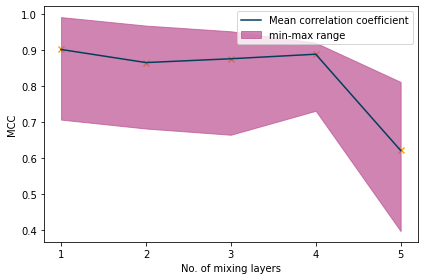

In [ ]:
Nl = 6
MCC_mat = np.load("MCC_matrix_iVAE_2.npy")[0:-1, :]
mean_MCC = np.mean(MCC_mat, axis = 1)
std_MCC = np.std(MCC_mat, axis = 1)
max_MCC = np.max(MCC_mat, axis = 1)
min_MCC = np.min(MCC_mat, axis = 1)

plt.figure()
plt.plot(range(1, Nl, 1), mean_MCC, color = "#003f5c", label = "Mean correlation coefficient")
plt.scatter(range(1, Nl, 1), mean_MCC, marker = "x", color = "#ffa600")
plt.fill_between(range(1, Nl, 1), min_MCC, max_MCC, color = "#bc5090", alpha = 0.7, label = "min-max range")
plt.xlabel("No. of mixing layers")
plt.ylabel("MCC")
plt.legend()
plt.tight_layout()
plt.xticks(range(1, 6, 1))
plt.show()


In [ ]:
"""
np.save("MCC_matrix_iVAE.npy", MCC_mat[1:, :])
from google.colab import files
files.download("/content/MCC_matrix_iVAE.npy")
"""

'\nnp.save("MCC_matrix_iVAE.npy", MCC_mat[1:, :])\nfrom google.colab import files\nfiles.download("/content/MCC_matrix_iVAE.npy")\n'